# Summary

This project analyzes the relationship between assesed value and sale amounts in the Conneticut real estate market. Using ridge regression, we found that assessed value alone explains the sale amount with the model scoring $R^2 \approx 0.90$. Using LightBGM, we found that the list year of the property contributed the most to the ratio of assessed value and sale amount, with the model scoring $R^2 \approx 0.50$.

# Problem

This project asks the following questions about the Conneticut real estate market:

**How well does the assessed value of properties in Conneticut correlate to their sales prices?**

**How do other features contribute to sales prices for property in Conneticut?**

**What features cause the difference between assessed value and sale price?**

# Data Collection
Data sourced from [Connecticut Open Data](https://data.ct.gov/Housing-and-Development/Real-Estate-Sales-2001-2023-GL/5mzw-sjtu/about_data)

The features from the dataset are:
- **Serial Number**: Serial number
- **List Year**: Year the property was listed for sale
- **Date Recorded**: Date the sale was recorded locally
- **Town**: Town name
- **Address**: Address
- **Assessed Value**: Value of the property used for local tax assesment
- **Sale Amount**: Amount the property was sold for
- **Sales Ratio**: Ratio of the sale price to the assessed value
- **Property Type**: Type of property including: Residential, Commercial, Industrial, Apartments, Vacant, etc
- **Residential Type**: Indicates whether property is single or multifamily residential
- **Non Use Code**: Non usable sale code typically means the sale price is not reliable for use in the determination of a property value. See attachments in the dataset description page for a listing of codes
- **Assessor Remarks**: Remarks from the assessor
- **OPM Remarks**: Remarks from OPM
- **Locations**: Lat / lon coordinates

In [1]:
import pandas as pd
df = pd.read_csv(
    'Real_Estate_Sales_2001-2023_GL.csv',
    low_memory=False,
    dtype = {
        'Serial Number':'int64',
        'List Year':'float64',
        'Date Recorded':'string',
        'Town':'string',
        'Address':'string',
        'Assessed Value':'float64',
        'Sale Amount':'float64',
        #'Sales Ratio':'float64', This crashes since there is a value which cannot be converted to a float
        'Property Type':'string',
        'Residential Type':'string',
        'Non Use Code':'string',
        'Assessor Remarks':'string',
        'OPM remarks':'string',
        'Location':'string',
    },
)

# Data Understanding

**Sales Ratio**: Defined as `Assessed Value` / `Sale Amount`.

**Low Sales Ratio (< 1)**: sold for less than assessed value $\implies$ bad for buyers, good for sellers.

**High sales Ratio (> 1)**: sold for more than assessed value $\implies$ good for buyers, bad for sellers.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1141722 entries, 0 to 1141721
Data columns (total 14 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Serial Number     1141722 non-null  int64  
 1   List Year         1141722 non-null  float64
 2   Date Recorded     1141720 non-null  string 
 3   Town              1141722 non-null  string 
 4   Address           1141671 non-null  string 
 5   Assessed Value    1141722 non-null  float64
 6   Sale Amount       1141722 non-null  float64
 7   Sales Ratio       1141722 non-null  object 
 8   Property Type     759276 non-null   string 
 9   Residential Type  738804 non-null   string 
 10  Non Use Code      324807 non-null   string 
 11  Assessor Remarks  181090 non-null   string 
 12  OPM remarks       14346 non-null    string 
 13  Location          341241 non-null   string 
dtypes: float64(3), int64(1), object(1), string(9)
memory usage: 121.9+ MB


**Missing Values:** Features like `Non Use Code`, `Assessor Remarks`, `OPM remarks`, and `Location` have over half of their entrances missing.

In [3]:
df.describe(include='all')

Serial Number     List Year Date Recorded        Town  \
count    1.141722e+06  1.141722e+06       1141720     1141722   
unique            NaN           NaN          7382         170   
top               NaN           NaN    07/01/2005  Bridgeport   
freq              NaN           NaN           877       39680   
mean     5.457366e+05  2.011673e+03           NaN         NaN   
std      7.450110e+06  7.018679e+00           NaN         NaN   
min      0.000000e+00  2.001000e+03           NaN         NaN   
25%      3.090300e+04  2.005000e+03           NaN         NaN   
50%      9.016000e+04  2.012000e+03           NaN         NaN   
75%      1.801550e+05  2.018000e+03           NaN         NaN   
max      2.000500e+09  2.023000e+03           NaN         NaN   

                Address  Assessed Value   Sale Amount Sales Ratio  \
count           1141671    1.141722e+06  1.141722e+06     1141722   
unique           795911             NaN           NaN      555302   
top     MULTI ADDRESSES             NaN           NaN           0   
freq                620             NaN           NaN        8595   
mean                NaN    2.833275e+05  4.104510e+05         NaN   
std                 NaN    1.656128e+06  5.048996e+06         NaN   
min                 NaN    0.000000e+00  0.000000e+00         NaN   
25%                 NaN    8.991000e+04  1.461000e+05         NaN   
50%                 NaN    1.419800e+05  2.375000e+05         NaN   
75%                 NaN    2.300600e+05  3.837500e+05         NaN   
max                 NaN    8.815100e+08  5.000000e+09         NaN   

        Property Type Residential Type Non Use Code Assessor Remarks  \
count          759276           738804       324807           181090   
unique             11                5           74            79270   
top     Single Family    Single Family   25 - Other      ESTATE SALE   
freq           401612           535359        70687             6001   
mean              NaN              NaN          NaN              NaN   
std               NaN              NaN          NaN              NaN   
min               NaN              NaN          NaN              NaN   
25%               NaN              NaN          NaN              NaN   
50%               NaN              NaN          NaN              NaN   
75%               NaN              NaN          NaN              NaN   
max               NaN              NaN          NaN              NaN   

              OPM remarks                    Location  
count               14346                      341241  
unique               7205                      250270  
top     GOOD SALE PER MLS  POINT (-72.36336 41.97461)  
freq                 1230                         204  
mean                  NaN                         NaN  
std                   NaN                         NaN  
min                   NaN                         NaN  
25%                   NaN                         NaN  
50%                   NaN                         NaN  
75%                   NaN                         NaN  
max                   NaN                         NaN

In [4]:
df.head()

Serial Number  List Year Date Recorded     Town          Address  \
0        2020177     2020.0    04/14/2021  Ansonia    323 BEAVER ST   
1        2020225     2020.0    05/26/2021  Ansonia   152 JACKSON ST   
2        2020348     2020.0    09/13/2021  Ansonia  230 WAKELEE AVE   
3        2020090     2020.0    12/14/2020  Ansonia      57 PLATT ST   
4         210288     2021.0    06/20/2022     Avon   12 BYRON DRIVE   

   Assessed Value  Sale Amount Sales Ratio Property Type Residential Type  \
0        133000.0     248400.0      0.5354   Residential    Single Family   
1        110500.0     239900.0      0.4606   Residential     Three Family   
2        150500.0     325000.0       0.463    Commercial             <NA>   
3        127400.0     202500.0      0.6291   Residential       Two Family   
4        179990.0     362500.0      0.4965   Residential            Condo   

  Non Use Code Assessor Remarks OPM remarks  \
0         <NA>             <NA>        <NA>   
1         <NA>             <NA>        <NA>   
2         <NA>             <NA>        <NA>   
3         <NA>             <NA>        <NA>   
4         <NA>             <NA>        <NA>   

                             Location  
0          POINT (-73.06822 41.35014)  
1                                <NA>  
2                                <NA>  
3                                <NA>  
4  POINT (-72.879115982 41.773452988)

In [5]:
df.tail()

Serial Number  List Year Date Recorded         Town  \
1141717         230299     2023.0    04/19/2024  Southington   
1141718         230568     2023.0    05/15/2024   West Haven   
1141719         230217     2023.0    02/20/2024  Southington   
1141720         230097     2023.0    05/30/2024     Old Lyme   
1141721         230383     2023.0    06/06/2024      Shelton   

                               Address  Assessed Value  Sale Amount  \
1141717  580-23 MERIDEN WATERBURY TPKE         26540.0     509900.0   
1141718                 165 MILTON AVE        148050.0     400300.0   
1141719                    242 LAZY LN        177340.0     334750.0   
1141720               21 BUTTONBALL RD          8030.0      35000.0   
1141721               512 ANTELOPE TRL        306460.0     659813.0   

        Sales Ratio Property Type Residential Type             Non Use Code  \
1141717      0.0520   Residential            Condo  07 - Change in Property   
1141718      0.3698   Residential    Single Family                     <NA>   
1141719      0.5297   Residential    Single Family                     <NA>   
1141720      0.2294   Vacant Land             <NA>                     <NA>   
1141721      0.4645   Residential            Condo               25 - Other   

                       Assessor Remarks                       OPM remarks  \
1141717  NEW CONSTRUCTION OVER 55 CONDO                              <NA>   
1141718                            <NA>                              <NA>   
1141719                            <NA>                              <NA>   
1141720    DEVELOPERS LOT FOR NEW CONST                              <NA>   
1141721                       89 33 512  PER MLS CLOSING PRICE = $675,000   

                           Location  
1141717  POINT (-72.86373 41.56032)  
1141718  POINT (-72.97401 41.24665)  
1141719  POINT (-72.88193 41.62094)  
1141720  POINT (-72.30557 41.29054)  
1141721  POINT (-73.13448 41.29345)

# Preprocessing

# Data Cleaning

## Date Recorded

Some entries in `Date Recorded` have misformatted with years like 0023 and 0024. This can be fixed by replacing the leading '00' with '20'.

In [6]:
df['Date Recorded'].sort_values(key=lambda x: x.str[6:]).head(10)

1128837    11/08/0023
1132341    11/08/0023
1133088    12/06/0023
1123783    12/30/0023
1133393    11/24/0023
1102626    10/20/0023
1133557    11/22/0023
1122962    11/23/0023
1133803    10/26/0023
1133902    10/15/0023
Name: Date Recorded, dtype: string

In [7]:
df['Date Recorded'] = df['Date Recorded'].str.replace("/00", "/20")
df['Date Recorded'] = pd.to_datetime(df['Date Recorded'])

## Sales Ratio

`Sales Ratio` contains values that cannot be converted to a float. We need to find the problematic data, reformat it, and convert the column to floats.

In [8]:
def is_float(x)->None:
    try:
        float(x)
        return True
    except:
        print(f'Misformatted Sales Ratio: {x}')
        return False
        
df['Sales Ratio'].apply(is_float).value_counts()

Misformatted Sales Ratio: 1,787.3333


Sales Ratio
True     1141721
False          1
Name: count, dtype: int64

Of all the strings in `Sales Ratio`, there is only one which cannot be converted to a float, so we can fix this individual datapoint.

Now every element in `Sales Ratio` is a float

In [9]:
df['Sales Ratio'] = df['Sales Ratio'].replace('1,787.3333','1787.3333')
df['Sales Ratio'] = pd.to_numeric(df['Sales Ratio'])

## Property Type / Residential Type

Some values in `Residential Type` have been copied to `Property type`. By replacing the `Residential` values in `Property Type` values with their respective value in `Residential Type`, these columns can be merged and `Residential Type` can be dropped.

In [10]:
df['Property Type'].value_counts()

Property Type
Single Family     401612
Residential       190628
Condo             105420
Two Family         26408
Three Family       12586
Vacant Land         9957
Commercial          7828
Four Family         2150
Apartments          1646
Industrial          1029
Public Utility        12
Name: count, dtype: Int64

In [11]:
df['Residential Type'].value_counts()

Residential Type
Single Family    535359
Condo            145436
Two Family        37173
Three Family      17670
Four Family        3166
Name: count, dtype: Int64

In [12]:
row = 500000
df[['Property Type','Residential Type']][row:row + 10]

Property Type Residential Type
500000     Two Family       Two Family
500001  Single Family    Single Family
500002   Three Family     Three Family
500003           <NA>             <NA>
500004  Single Family    Single Family
500005           <NA>             <NA>
500006  Single Family    Single Family
500007     Two Family       Two Family
500008           <NA>             <NA>
500009  Single Family    Single Family

In [13]:
import numpy as np

df['Property Type'] = df['Residential Type'].combine_first(df['Property Type'])
df = df.drop(['Residential Type'],axis=1)
df.head()

Serial Number  List Year Date Recorded     Town          Address  \
0        2020177     2020.0    2021-04-14  Ansonia    323 BEAVER ST   
1        2020225     2020.0    2021-05-26  Ansonia   152 JACKSON ST   
2        2020348     2020.0    2021-09-13  Ansonia  230 WAKELEE AVE   
3        2020090     2020.0    2020-12-14  Ansonia      57 PLATT ST   
4         210288     2021.0    2022-06-20     Avon   12 BYRON DRIVE   

   Assessed Value  Sale Amount  Sales Ratio  Property Type Non Use Code  \
0        133000.0     248400.0       0.5354  Single Family         <NA>   
1        110500.0     239900.0       0.4606   Three Family         <NA>   
2        150500.0     325000.0       0.4630     Commercial         <NA>   
3        127400.0     202500.0       0.6291     Two Family         <NA>   
4        179990.0     362500.0       0.4965          Condo         <NA>   

  Assessor Remarks OPM remarks                            Location  
0             <NA>        <NA>          POINT (-73.06822 41.35014)  
1             <NA>        <NA>                                <NA>  
2             <NA>        <NA>                                <NA>  
3             <NA>        <NA>                                <NA>  
4             <NA>        <NA>  POINT (-72.879115982 41.773452988)

## Non Use Code

From Connecticut Open Data:

"Non usable sale code typically means the sale price is not reliable for use in the determination of a property value."

Rows with non-null `Non Use Code` are removed since they're marked as unreliable

In [14]:
df = df[df['Non Use Code'].isna()]
df = df.drop(['Non Use Code'],axis=1)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 816915 entries, 0 to 1141720
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Serial Number     816915 non-null  int64         
 1   List Year         816915 non-null  float64       
 2   Date Recorded     816913 non-null  datetime64[ns]
 3   Town              816915 non-null  string        
 4   Address           816912 non-null  string        
 5   Assessed Value    816915 non-null  float64       
 6   Sale Amount       816915 non-null  float64       
 7   Sales Ratio       816915 non-null  float64       
 8   Property Type     538952 non-null  string        
 9   Assessor Remarks  45535 non-null   string        
 10  OPM remarks       2575 non-null    string        
 11  Location          251976 non-null  string        
dtypes: datetime64[ns](1), float64(4), int64(1), string(6)
memory usage: 81.0 MB


# Feature Engineering



## Street
We create a `Street` feature from the raw `Address` feature.

In [16]:
import re

bad_numbers = '0123456789'
bad_chars = ' ~`!@#$%^&*()-+={}[]\\:;\'"<>,./?'
bad_letters = 'qwertyuiopasdfghjklzxcvbnmQWERTYUIOPASDFGHJKLZXCVBNM'

def remove_direction(street:str)->str:
    for end_direction in [' N', ' E', ' S', ' W', ' NORTH', 'EAST', ' SOUTH', ' WEST', ' NO', ' SO', ' UT']:
        if street.endswith(end_direction):
            street = street.removesuffix(end_direction)
    return street

def remove_lot(street:str)->str:
    if ' LT' in street or street.startswith('LT '):
        street = street.replace(' LT', ' LOT ')
    if ' LOTS' in street or street.startswith('LOTS '):
        street = street.replace(' LOTS', ' LOT ')

    if re.search(r'(?<![A-Za-z])LOT ', street):
        split_street = street.split('LOT')
        if split_street:
            street = split_street[0]
        elif len(split_street) > 1:
            street = split_street[1]
        street = street.strip(bad_chars)
    if street.startswith('LOT '):
        street = street.removeprefix('LOT ')
    if street.endswith(' LOT'):
        street = street.removesuffix(' LOT')
    return street

def remove_unit(street:str)->str:
    if re.search(r'(?<![A-Za-z])UNIT ', street):
        split_street = street.split('UNIT')
        if split_street:
            street = split_street[0]
        elif len(split_street) > 1:
            street = split_street[1]
        street = street.strip(bad_chars)
    return street
    
def remove_dock(street:str)->str:
    if (
        street.endswith(' RD')
        or street.endswith(' DR') 
        or street.endswith(' STREET') 
        or street.endswith(' ROAD') 
        or street.endswith(' DRIVE')
        or street.endswith(' ST')
        or street.endswith(' LN')        
        or street.endswith(' LANE')
    ):
        return street.strip(bad_chars+bad_numbers)
        
    if re.search(r'(?<![A-Za-z])DOCK(?![A-Za-z])', street):
        if street.endswith('DOCK') and 'OYSTER' not in street:
            street = street.removesuffix('DOCK')
        split_street = street.split('DOCK')
        if split_street:
            street = split_street[0]
        elif len(split_street) > 1:
            street = split_street[1]

    street = street.strip(bad_chars+bad_numbers)       
  
    return street
    
def format_route(street:str)->str:
    street = remove_lot(street)
    street = street.lstrip(bad_numbers).rstrip(bad_chars + bad_letters)
    return street

def format_street(address:str)->str:
    if pd.isna(address):
        return address

    street = address.lstrip(bad_numbers)
    if street.startswith('ROUTE '):
        street = format_route(street)
        return street
    if street.startswith('RT '):
        street = address.replace('RT','ROUTE')
        street = format_route(street)
        return street

    if 'UNIT' in street:
        street = remove_unit(street)

    if 'LOT' in street or 'LT' in street:
        street = remove_lot(street)

    if 'DOCK' in street:
        street = remove_dock(street)

    street = street.strip(bad_chars+bad_numbers)
    #street = re.sub(r'\s+UT$', '', street, flags=re.IGNORECASE)
    street = re.sub(r'#[A-Za-z]', '', street)
    street = re.sub(r'\d+[A-Za-z]$', '', street)
    street = re.sub(r'[A-Za-z]\d+$', '', street)
    street = re.sub(r'^[A-Za-z]\d+', '', street)
    street = re.sub(r'^\d+[A-Za-z]', '', street)
    street = street.strip(bad_chars+bad_numbers)
    street = re.sub(r'^[A-Za-z] ', '', street)
    street = re.sub(r' [A-Za-z]$', '', street)
    street = remove_direction(street)
    street = street.strip(bad_chars+bad_numbers)     
    return street
    
street = df['Address'].apply(format_street)

simple_streets = [
    'MAIN ST',
    'SUMMER ST',
    'NORDEN PL',
    'WASHINGTON BLVD',
    'NORTH WATER ST',
    'MAIN AVE',
    #'HERITAGE VLG',
    'NORTH AVENUE',
    'PARK AVE',
    'FREDERICK STREET',
    'GLENDALE AVENUE',
    'LAKESIDE BLVD',
    'FIELD POINT ROAD',
    'LAFAYETTE BLVD',
    'EAST HIGH ST',
    'WHALLEY AVENUE',
    'LONG HILL RD',
    'GLENBROOK ROAD',
    'NOB HILL',
    'GAYLORD MT RD',
    'VENICE AVE',
    'BOSTON AVENUE',
    'THOMPSON RD',
    'CHERRY HILL DR',
    'HORSE POND RD',
    'CARTRIGHT',
    'MADISON AVE',
    'ELY AVE',
    'LAKESIDE DR',
    'JOYCE RD',
    'NEW NORWALK',
    'HARBOR DRIVE',
    'BREAKWATER KEY',
    'GLASGO RD',
    'AETNA AVE',
    'NAUBUC AVE',
    'KELLY RD',
    'SOUTH AVE',    
    'CORPORATE DR',
    'HUNTINGTON ST',

]

#simple_streets=[]

for street_name in simple_streets:
    street = street.mask(
        street.str.contains(
            street_name,
            case=False,
            na=False,
        ),
        street_name,
    )

street_replacements = {
    'HERITAGE VILLAGE':'HERITAGE VLG',
    'HERITAGE VLD':'HERITAGE VLG',
    'S WHITNEY':'SOUTH WHITNEY ST',
    'STRAWBERRY HL AVE':'STRAWBERRY HILL AVE',
    'NIANTIC DOCKO':'NIANTIC DOCKOMINIUM',
    'NIANTIC':'NIANTIC DOCKOMINIUM',
    'SOUTHFIELD AVE DOCK':'SOUTHFIELD AVE',
    'BYRAM':'BYRAM DOCK ST',
    'WEST ELM SSTREET':'WEST ELM STREET',
}

for street_name in street_replacements:
    street = street.mask(
        street.str.contains(
            street_name,
            case=False,
            na=False,
        ),
        street_replacements[street_name]
    )

street = street + ', ' + df['Town']

df.insert(len(df.columns),'Street',street)

## X Location / y Location

Using the Location feature, we make `X Location` and `y Location` features

In [17]:
location = df['Location'].str.lstrip('POINT (').str.rstrip(')')

locations = location.str.split(' ',expand=True)
X_location = locations[0].astype('float64')
y_location = locations[1].astype('float64')
df.insert(len(df.columns),'X Location',X_location)
df.insert(len(df.columns),'y Location',y_location)
df = df.drop(['Location'],axis=1)

## Year Sold / Years On Market / Day of Year Sold / Day of Week Sold

Using the `Date Recorded` and `List Year` features, we make `Year Sold`, `Years On Market`, `Day of Year Sold`, and `Day of Week Sold` features

In [18]:
df['sin(Day of Week Sold)'] = np.sin(2 * np.pi * df['Date Recorded'].dt.day_of_week / 7)
df['cos(Day of Week Sold)'] = np.cos(2 * np.pi * df['Date Recorded'].dt.day_of_week / 7)

df['sin(Day of Year Sold)'] = np.sin(2 * np.pi * df['Date Recorded'].dt.day_of_year / 365)
df['cos(Day of Year Sold)'] = np.cos(2 * np.pi * df['Date Recorded'].dt.day_of_year / 365)

df['Year Sold'] = df['Date Recorded'].dt.year.astype('Float64')
df['Years on Market'] = df['Year Sold'] - df['List Year']

df.head()

Serial Number  List Year Date Recorded     Town          Address  \
0        2020177     2020.0    2021-04-14  Ansonia    323 BEAVER ST   
1        2020225     2020.0    2021-05-26  Ansonia   152 JACKSON ST   
2        2020348     2020.0    2021-09-13  Ansonia  230 WAKELEE AVE   
3        2020090     2020.0    2020-12-14  Ansonia      57 PLATT ST   
4         210288     2021.0    2022-06-20     Avon   12 BYRON DRIVE   

   Assessed Value  Sale Amount  Sales Ratio  Property Type Assessor Remarks  \
0        133000.0     248400.0       0.5354  Single Family             <NA>   
1        110500.0     239900.0       0.4606   Three Family             <NA>   
2        150500.0     325000.0       0.4630     Commercial             <NA>   
3        127400.0     202500.0       0.6291     Two Family             <NA>   
4        179990.0     362500.0       0.4965          Condo             <NA>   

  OPM remarks                Street  X Location  y Location  \
0        <NA>    BEAVER ST, Ansonia  -73.068220   41.350140   
1        <NA>   JACKSON ST, Ansonia         NaN         NaN   
2        <NA>  WAKELEE AVE, Ansonia         NaN         NaN   
3        <NA>     PLATT ST, Ansonia         NaN         NaN   
4        <NA>     BYRON DRIVE, Avon  -72.879116   41.773453   

   sin(Day of Week Sold)  cos(Day of Week Sold)  sin(Day of Year Sold)  \
0               0.974928              -0.222521               0.976011   
1               0.974928              -0.222521               0.587785   
2               0.000000               1.000000              -0.953681   
3               0.000000               1.000000              -0.271958   
4               0.000000               1.000000               0.196673   

   cos(Day of Year Sold)  Year Sold  Years on Market  
0              -0.217723     2021.0              1.0  
1              -0.809017     2021.0              1.0  
2              -0.300820     2021.0              1.0  
3               0.962309     2020.0              0.0  
4              -0.980469     2022.0              1.0

Any row with Years on Market less than 0 is invalid, and needs to be removed

In [19]:
df = df[df['Years on Market']>=0]

## Replacing Null Values

Now that new features have been added, null values can be replaced

In [20]:
df = df[df['Date Recorded'].notnull()]
#df['Date Recorded'] = df['Date Recorded'].map(lambda x: x.toordinal()).astype('Float64')
df = df.drop(['Date Recorded'],axis=1)
for col in df.select_dtypes(include='string'):
    df[col] = df[col].fillna('Missing')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 816871 entries, 0 to 1141720
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Serial Number          816871 non-null  int64  
 1   List Year              816871 non-null  float64
 2   Town                   816871 non-null  string 
 3   Address                816871 non-null  string 
 4   Assessed Value         816871 non-null  float64
 5   Sale Amount            816871 non-null  float64
 6   Sales Ratio            816871 non-null  float64
 7   Property Type          816871 non-null  string 
 8   Assessor Remarks       816871 non-null  string 
 9   OPM remarks            816871 non-null  string 
 10  Street                 816871 non-null  string 
 11  X Location             251968 non-null  float64
 12  y Location             251968 non-null  float64
 13  sin(Day of Week Sold)  816871 non-null  float64
 14  cos(Day of Week Sold)  816871 non-null  

Now there are no more mixed types

In [21]:
df.describe()

Serial Number      List Year  Assessed Value   Sale Amount  \
count   8.168710e+05  816871.000000    8.168710e+05  8.168710e+05   
mean    6.053749e+05    2011.552516    2.409097e+05  4.154772e+05   
std     8.074416e+06       7.191449    6.905130e+05  1.238287e+06   
min     2.100000e+01    2001.000000    0.000000e+00  0.000000e+00   
25%     3.071800e+04    2004.000000    9.555000e+04  1.720000e+05   
50%     8.042100e+04    2012.000000    1.481900e+05  2.599000e+05   
75%     1.804270e+05    2018.000000    2.373300e+05  4.004000e+05   
max     2.000500e+09    2023.000000    1.106702e+08  1.630000e+08   

         Sales Ratio     X Location     y Location  sin(Day of Week Sold)  \
count  816871.000000  251968.000000  251968.000000          816871.000000   
mean        0.795164     -72.887446      41.490848               0.327360   
std       182.627422       0.428519       0.259121               0.512585   
min         0.000000     -85.168900      37.591070              -0.974928   
25%         0.472740     -73.204200      41.282710               0.000000   
50%         0.578831     -72.904235      41.488999               0.433884   
75%         0.691492     -72.640583      41.710380               0.781831   
max    165060.000000     -71.788500      44.934590               0.974928   

       cos(Day of Week Sold)  sin(Day of Year Sold)  cos(Day of Year Sold)  \
count          816871.000000          816871.000000          816871.000000   
mean               -0.014384              -0.068751              -0.108345   
std                 0.793654               0.695952               0.706531   
min                -0.900969              -0.999991              -0.999963   
25%                -0.900969              -0.752667              -0.819015   
50%                -0.222521              -0.145799              -0.200891   
75%                 0.623490               0.601624               0.570242   
max                 1.000000               0.999991               1.000000   

         Year Sold  Years on Market  
count     816871.0         816871.0  
mean   2012.299931         0.747415  
std       7.194271         0.434509  
min         2001.0              0.0  
25%         2005.0              0.0  
50%         2012.0              1.0  
75%         2019.0              1.0  
max         2024.0              3.0

# Removing Outliers

To improve model performance, certain values from the dataset are removed:

-**Large Sales Ratios**: Most rows contain Sales Ratios under 11. To ensure that the model is accurate, the rows with Sales Ratios of 165060, 530, and 22.4 are removed.

-**Sales Ratios of 0**: Data with `Sales Ratio` = 0 are removed So they don't communicate any meaningful information to the model.

-**Low Assess Value or Sale Amount**: Data with `Assessed Value` and `Sale Amount` < $100 are removed to remove exceptional cases.

In [22]:
df.sort_values(by = 'Sales Ratio', ascending = False).head(10)

Serial Number  List Year      Town                      Address  \
188218          20181     2002.0  Hartford                57 GILLETT ST   
604289          10272     2010.0    Hamden               642 NEWHALL ST   
33097          200018     2020.0   Norwich  202 R NORTH WAWECUS HILL RD   
31610          200268     2020.0   Norwich             174 WEST TOWN ST   
656943          11001     2011.0   Chester                46 STRAITS RD   
52339          200319     2020.0   Norwich      303 MOHEGAN PARK RD #57   
656073          11004     2011.0   Chester               84 WIG HILL RD   
637600          10227     2010.0    Hamden            134 SANFORD ST U6   
866982         160208     2016.0   Meriden          42 BRECKENRIDGE AVE   
46440          200868     2020.0   Norwich             101 ATLANTIC AVE   

        Assessed Value  Sale Amount    Sales Ratio  Property Type  \
188218        165060.0          1.0  165060.000000        Missing   
604289     110670208.0     208900.0     529.776008  Single Family   
33097         672400.0      30000.0      22.413300    Vacant Land   
31610         229700.0      22000.0      10.440900     Commercial   
656943        396440.0      45000.0       8.809778  Single Family   
52339          46700.0       5405.0       8.640100  Single Family   
656073        231950.0      27000.0       8.590741  Single Family   
637600        164570.0      20000.0       8.228500          Condo   
866982         40460.0       5000.0       8.092000        Missing   
46440         161000.0      20000.0       8.050000  Single Family   

                   Assessor Remarks OPM remarks  \
188218                      Missing     Missing   
604289                      Missing     Missing   
33097   VACANT LAND W/ OUTBUILDINGS     Missing   
31610                       Missing     Missing   
656943                      Missing     Missing   
52339                       Missing     Missing   
656073                      Missing     Missing   
637600                      Missing     Missing   
866982                      Missing     Missing   
46440                       Missing     Missing   

                                Street  X Location  y Location  \
188218            GILLETT ST, Hartford         NaN         NaN   
604289              NEWHALL ST, Hamden         NaN         NaN   
33097   NORTH WAWECUS HILL RD, Norwich         NaN         NaN   
31610            WEST TOWN ST, Norwich         NaN         NaN   
656943             STRAITS RD, Chester         NaN         NaN   
52339         MOHEGAN PARK RD, Norwich    -72.0655    41.55307   
656073            WIG HILL RD, Chester         NaN         NaN   
637600              SANFORD ST, Hamden         NaN         NaN   
866982       BRECKENRIDGE AVE, Meriden         NaN         NaN   
46440            ATLANTIC AVE, Norwich         NaN         NaN   

        sin(Day of Week Sold)  cos(Day of Week Sold)  sin(Day of Year Sold)  \
188218               0.781831               0.623490              -0.746972   
604289               0.974928              -0.222521               0.774884   
33097                0.974928              -0.222521              -0.992222   
31610               -0.433884              -0.900969               0.137279   
656943               0.000000               1.000000              -0.999250   
52339                0.974928              -0.222521               0.337523   
656073               0.781831               0.623490              -0.998435   
637600               0.974928              -0.222521               0.999250   
866982               0.000000               1.000000              -0.188227   
46440                0.433884              -0.900969              -0.230306   

        cos(Day of Year Sold)  Year Sold  Years on Market  
188218               0.664855     2002.0              0.0  
604289              -0.632103     2011.0              1.0  
33097                0.124479     2020.0              0.0  
31610                0.

In [23]:
#threshold = df['Sales Ratio'].nlargest(10).min()
#df = df[df['Sales Ratio'] < threshold]
df = df[df['Sales Ratio'] > 0]
df = df[df['Sales Ratio'] <= 11]
df = df[df['Assessed Value'] > 100]
df = df[df['Sale Amount'] > 100]

Now the categoric data can be converted to category dtype

In [24]:
categoric_columns = [
    'Property Type',
    'Town',
    'Address',
    'Assessor Remarks',
    'OPM remarks',
    'Street',
]

for col in categoric_columns:
    df[col] = df[col].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 816818 entries, 0 to 1141720
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   Serial Number          816818 non-null  int64   
 1   List Year              816818 non-null  float64 
 2   Town                   816818 non-null  category
 3   Address                816818 non-null  category
 4   Assessed Value         816818 non-null  float64 
 5   Sale Amount            816818 non-null  float64 
 6   Sales Ratio            816818 non-null  float64 
 7   Property Type          816818 non-null  category
 8   Assessor Remarks       816818 non-null  category
 9   OPM remarks            816818 non-null  category
 10  Street                 816818 non-null  category
 11  X Location             251955 non-null  float64 
 12  y Location             251955 non-null  float64 
 13  sin(Day of Week Sold)  816818 non-null  float64 
 14  cos(Day of Week Sold)  8

# Exploratory Data Analysis

Now that the data has been cleaned and features have been added, we can examine the dataset using statistics and visualizations

In [25]:
df.head()

Serial Number  List Year     Town          Address  Assessed Value  \
0        2020177     2020.0  Ansonia    323 BEAVER ST        133000.0   
1        2020225     2020.0  Ansonia   152 JACKSON ST        110500.0   
2        2020348     2020.0  Ansonia  230 WAKELEE AVE        150500.0   
3        2020090     2020.0  Ansonia      57 PLATT ST        127400.0   
4         210288     2021.0     Avon   12 BYRON DRIVE        179990.0   

   Sale Amount  Sales Ratio  Property Type Assessor Remarks OPM remarks  \
0     248400.0       0.5354  Single Family          Missing     Missing   
1     239900.0       0.4606   Three Family          Missing     Missing   
2     325000.0       0.4630     Commercial          Missing     Missing   
3     202500.0       0.6291     Two Family          Missing     Missing   
4     362500.0       0.4965          Condo          Missing     Missing   

                 Street  X Location  y Location  sin(Day of Week Sold)  \
0    BEAVER ST, Ansonia  -73.068220   41.350140               0.974928   
1   JACKSON ST, Ansonia         NaN         NaN               0.974928   
2  WAKELEE AVE, Ansonia         NaN         NaN               0.000000   
3     PLATT ST, Ansonia         NaN         NaN               0.000000   
4     BYRON DRIVE, Avon  -72.879116   41.773453               0.000000   

   cos(Day of Week Sold)  sin(Day of Year Sold)  cos(Day of Year Sold)  \
0              -0.222521               0.976011              -0.217723   
1              -0.222521               0.587785              -0.809017   
2               1.000000              -0.953681              -0.300820   
3               1.000000              -0.271958               0.962309   
4               1.000000               0.196673              -0.980469   

   Year Sold  Years on Market  
0     2021.0              1.0  
1     2021.0              1.0  
2     2021.0              1.0  
3     2020.0              0.0  
4     2022.0              1.0

## Numeric Data

The following bar plots show the distributions of the numeric features (`Assessed Value`,`Sale Amount`,`Sales Ratio`,`X Location`,`y Location`)

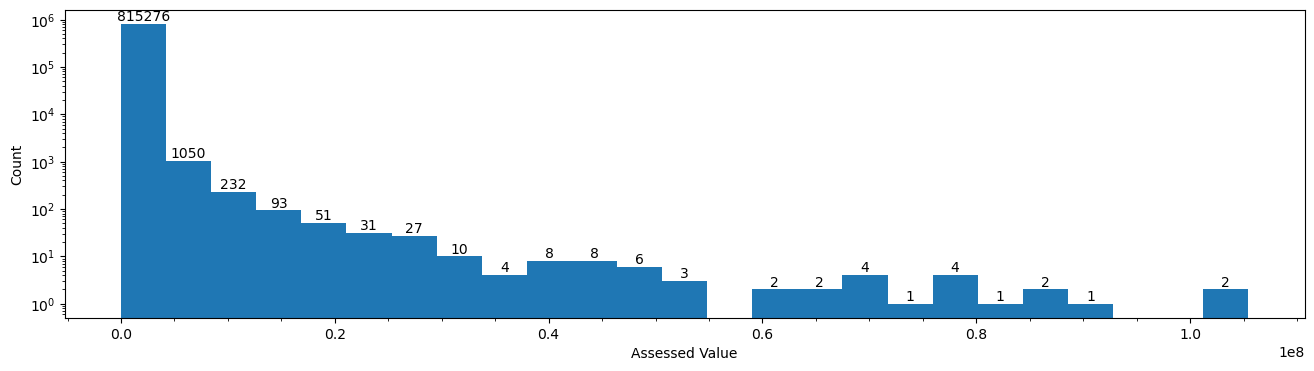

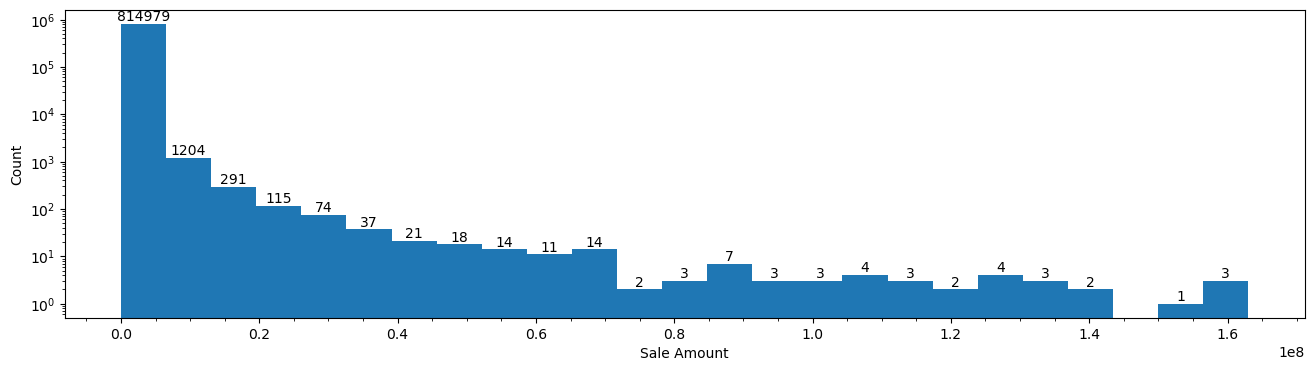

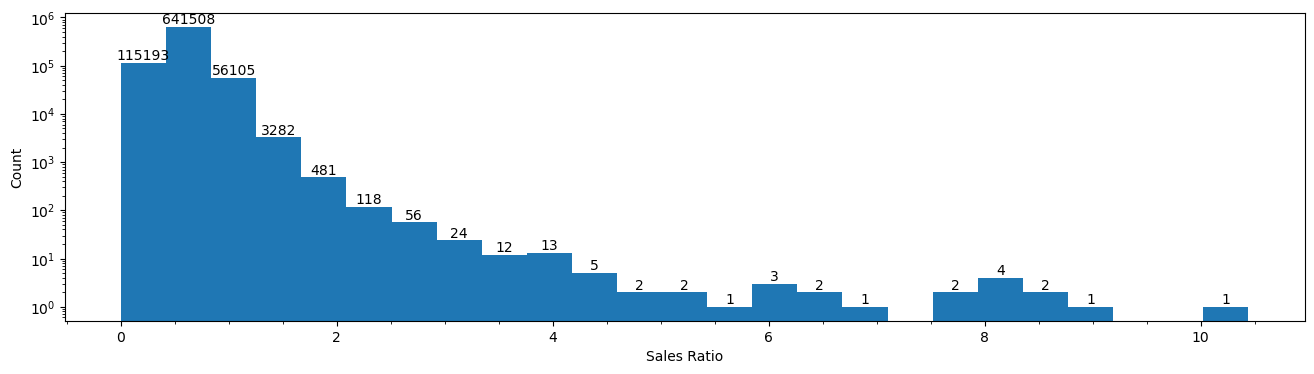

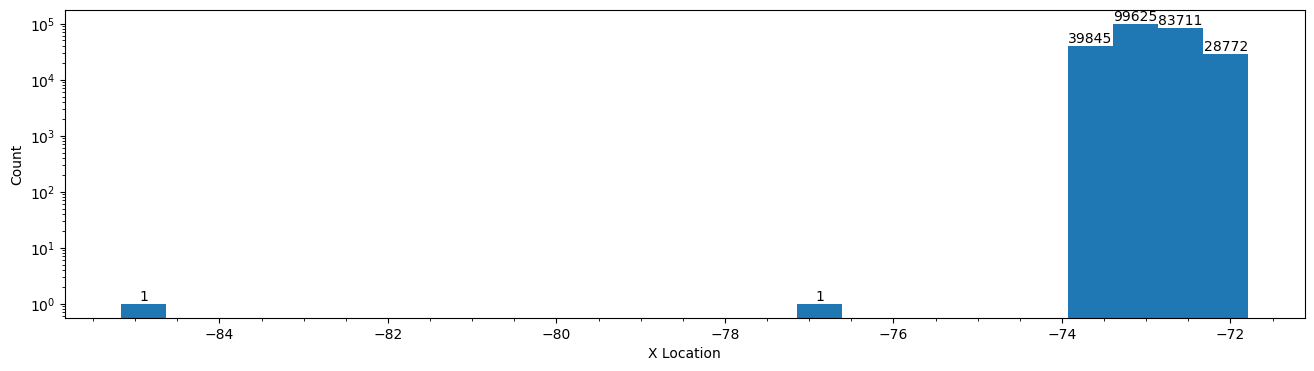

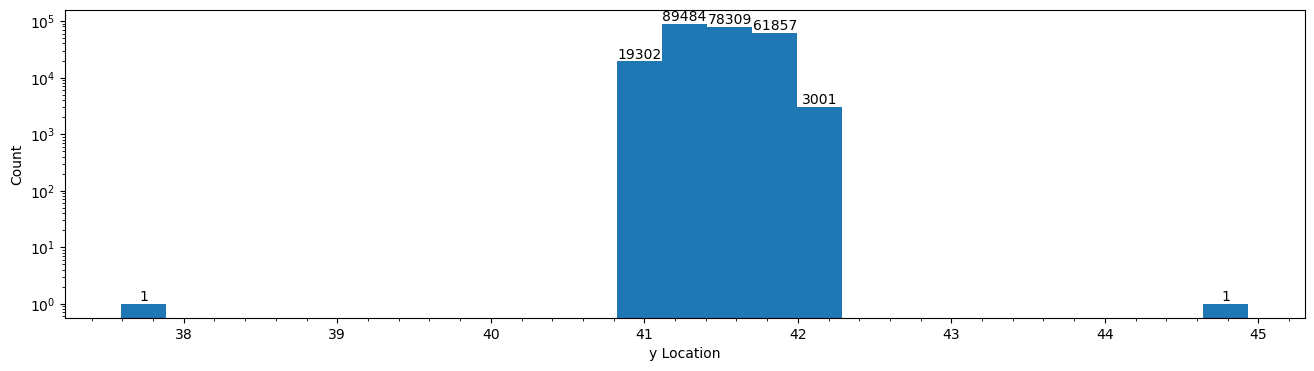

In [26]:
from matplotlib import pyplot as plt

numeric_columns = [
    'Assessed Value',
    'Sale Amount',
    'Sales Ratio',
    'X Location',
    'y Location'
]

for col in numeric_columns:
    plt.figure(figsize=(16,4))
    _, _, bar = plt.hist(df[col], bins = 25)
    plt.bar_label(bar)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.yscale('log')
    plt.minorticks_on()
    plt.show()

## Categoric Data

The following bar plots show the distributions of the categoric features. (`List Year`,`Property Type`,`Year Sold`,`Years on Market`,`Town`,`Address`,`Assessor Remarks`,`OPM remarks`,`Street`)

For the high cardinality data (`Town`,`Address`,`Assessor Remarks`,`OPM remarks`,`Street`), only the top 10 values are displayed.

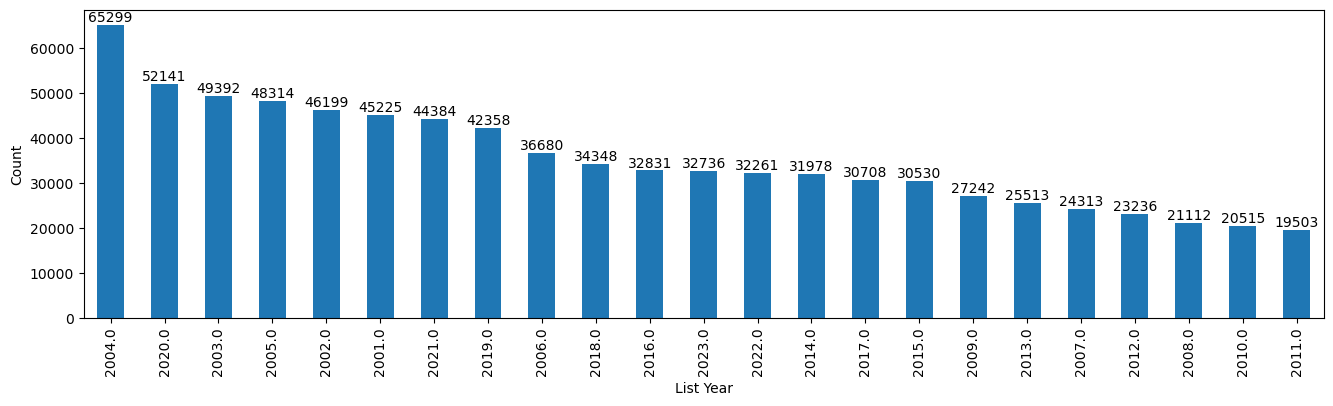

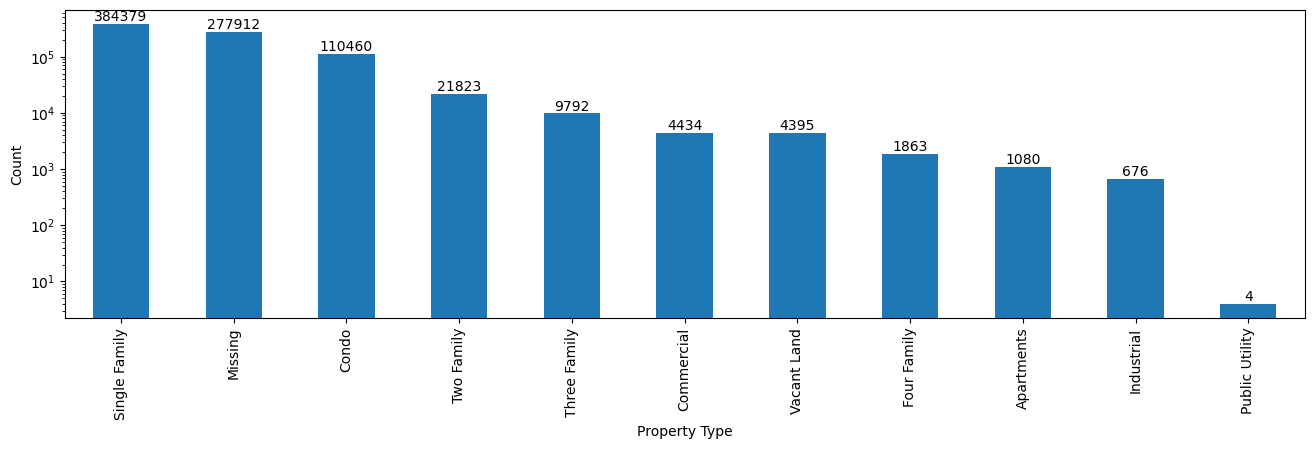

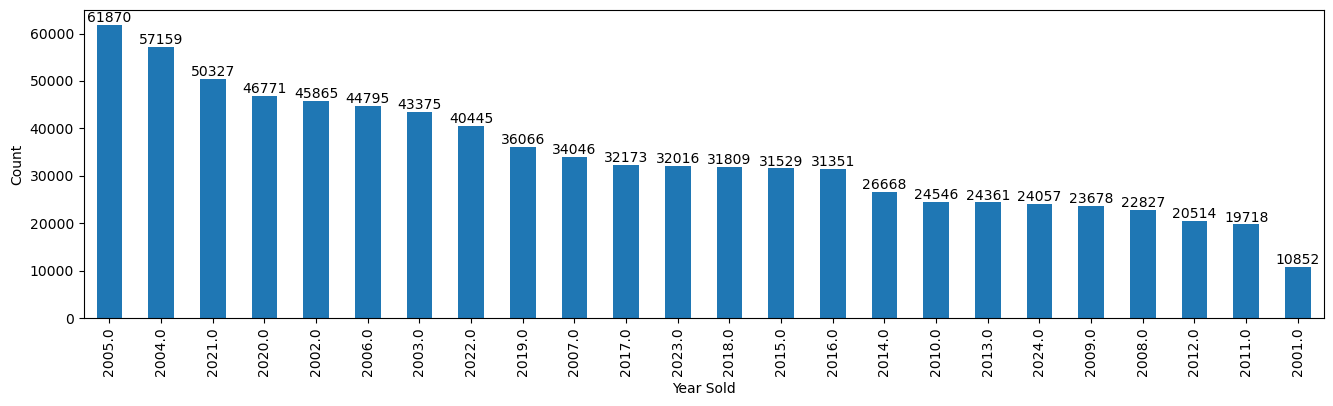

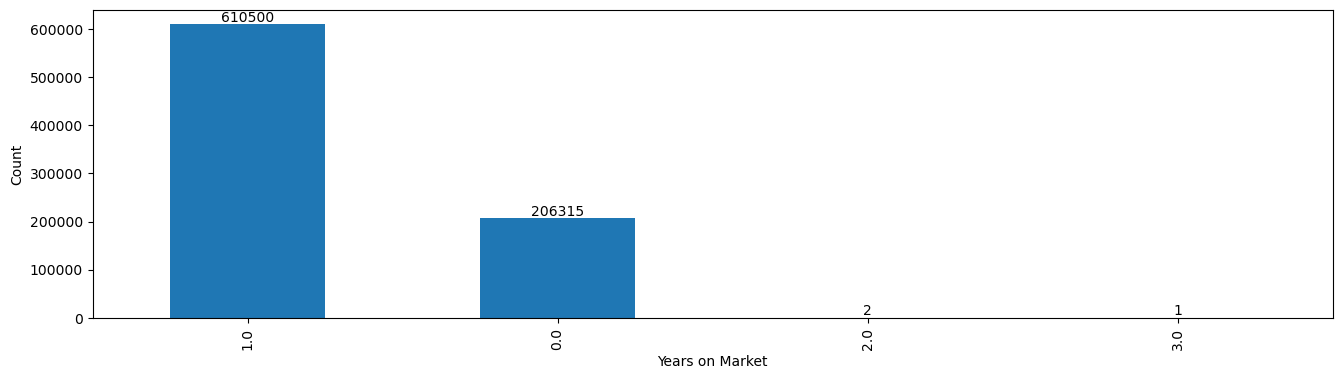

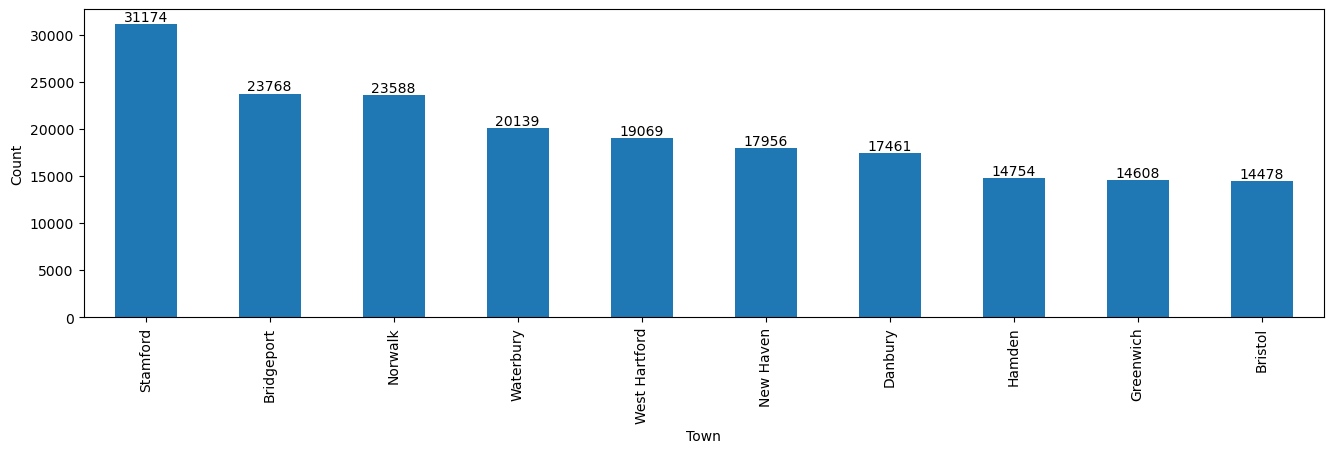

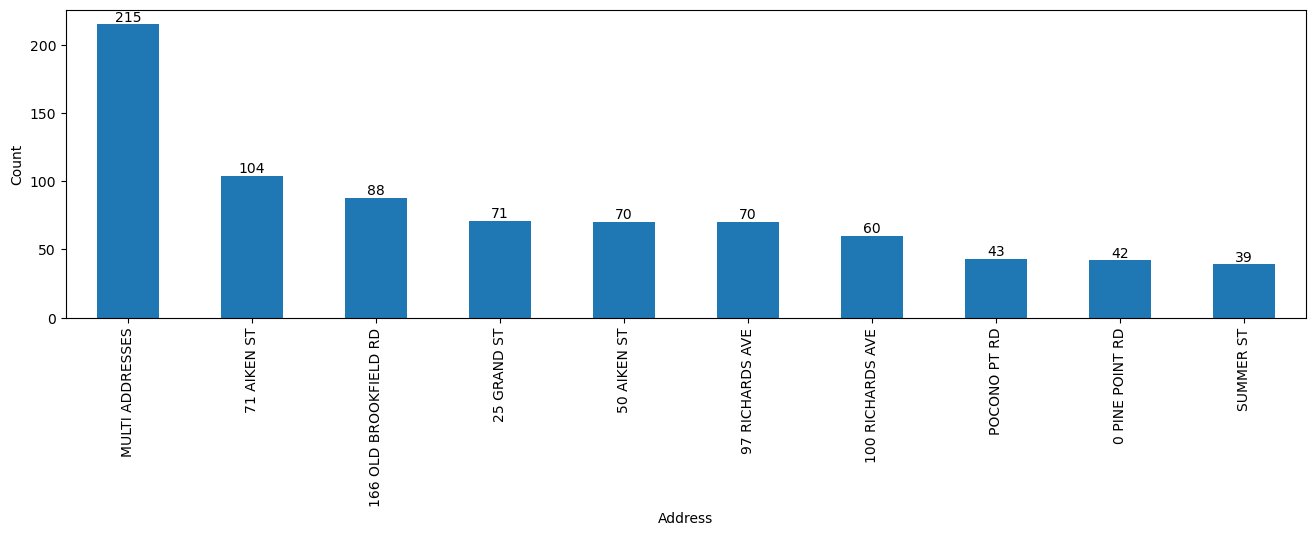

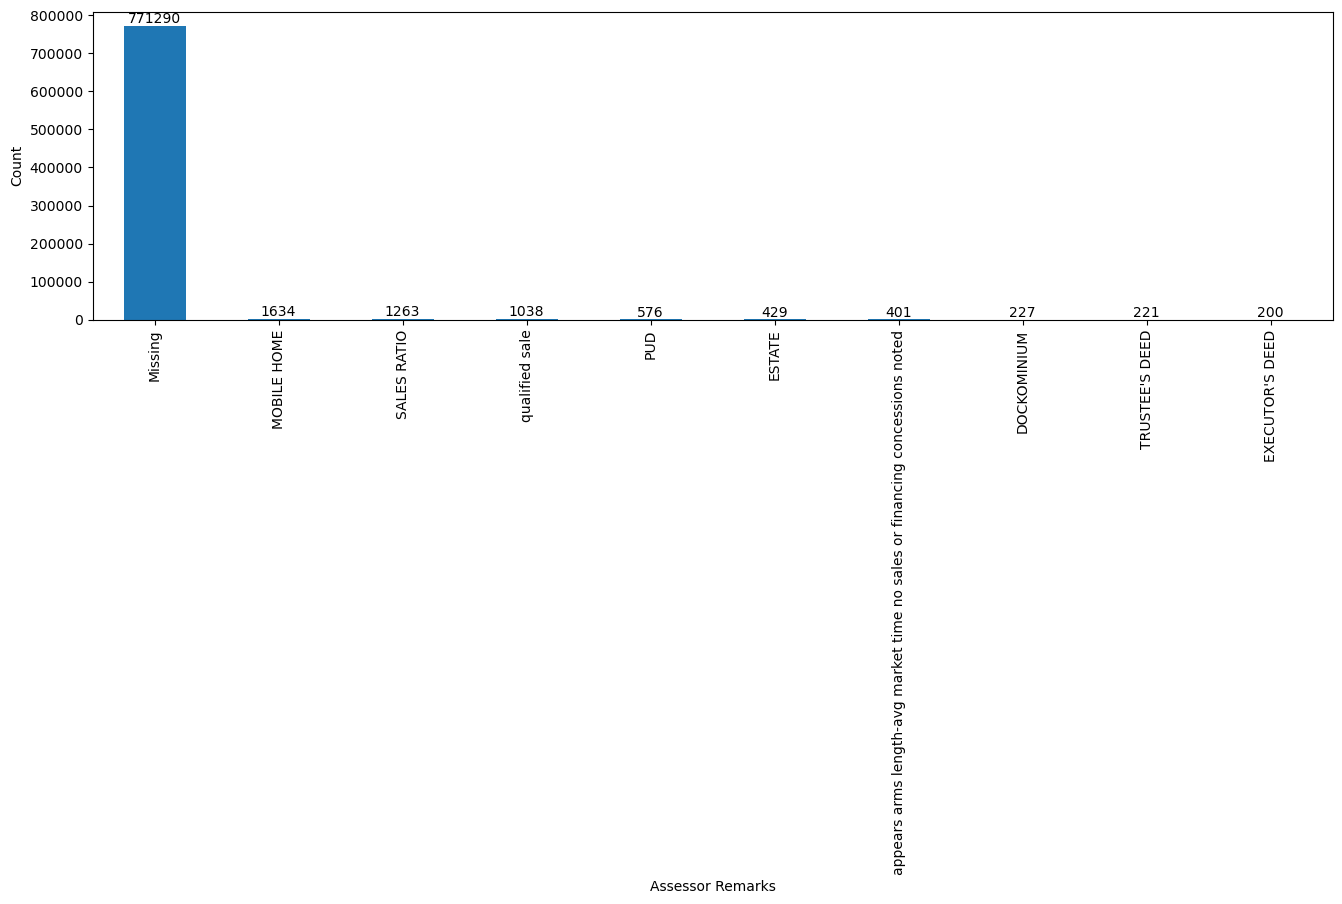

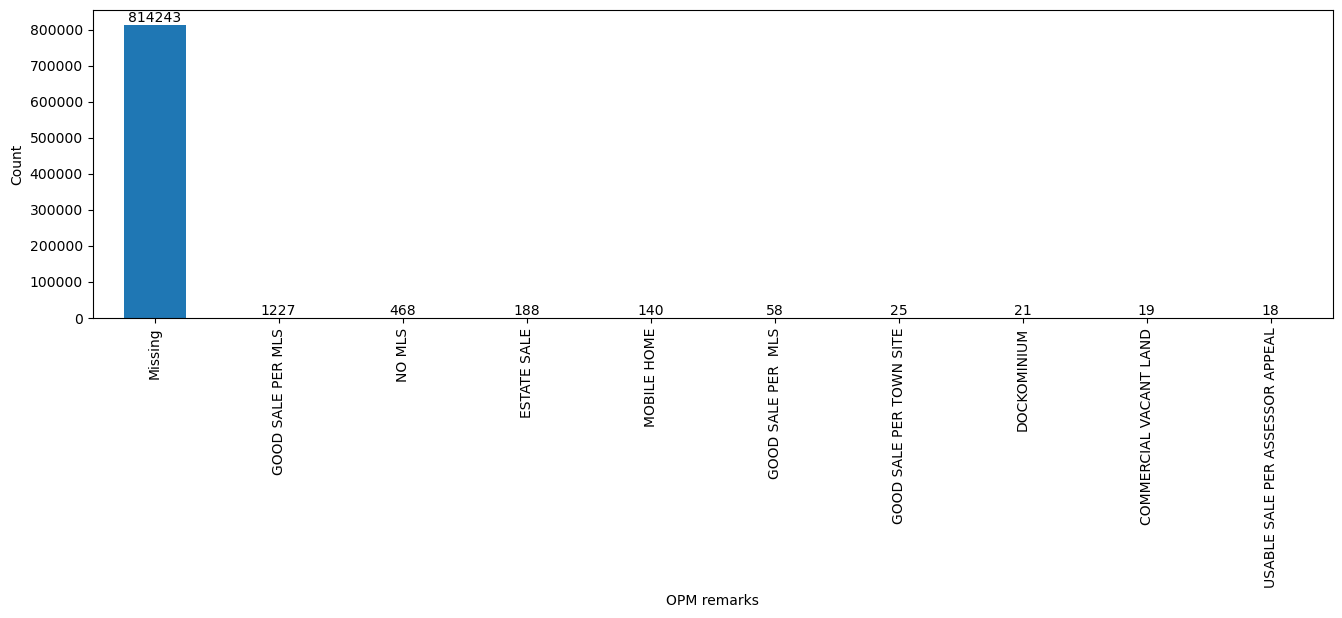

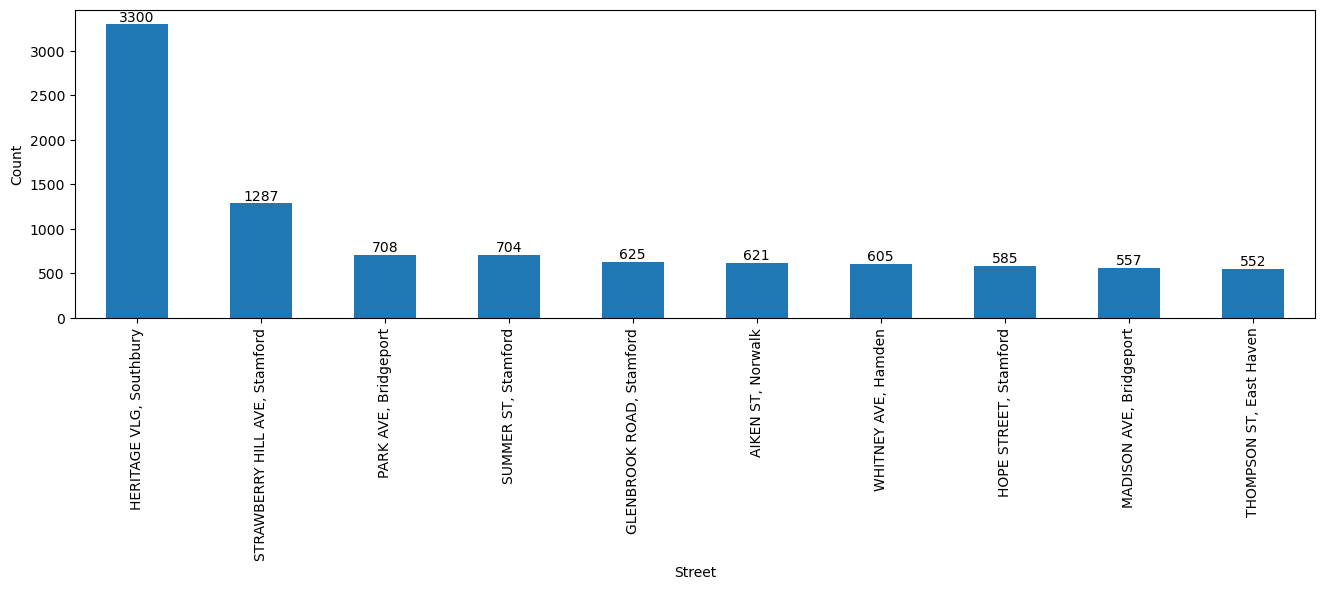

In [27]:
bar_columns = [
    'List Year',
    'Property Type',
    'Year Sold',
    'Years on Market',
]

large_bar_columns = [
    'Town',
    'Address',
    'Assessor Remarks',
    'OPM remarks',
    'Street',
]

for col in bar_columns:
    plt.figure(figsize=(16,4))
    if col == 'Property Type':
        plt.yscale('log')
    ax = df[col].value_counts().plot(kind='bar')
    ax.bar_label(ax.containers[0])
    plt.ylabel('Count')
    plt.show()

for col in large_bar_columns:
    plt.figure(figsize=(16,4))
    ax = df[col].value_counts().nlargest(10).plot(kind='bar')
    ax.bar_label(ax.containers[0])
    plt.ylabel('Count')
    plt.show()

## Average Sale Amounts

The following bar plots display numeric and categorical features grouped against average `Sale Amount` to find features correlated with `Sale Amount`

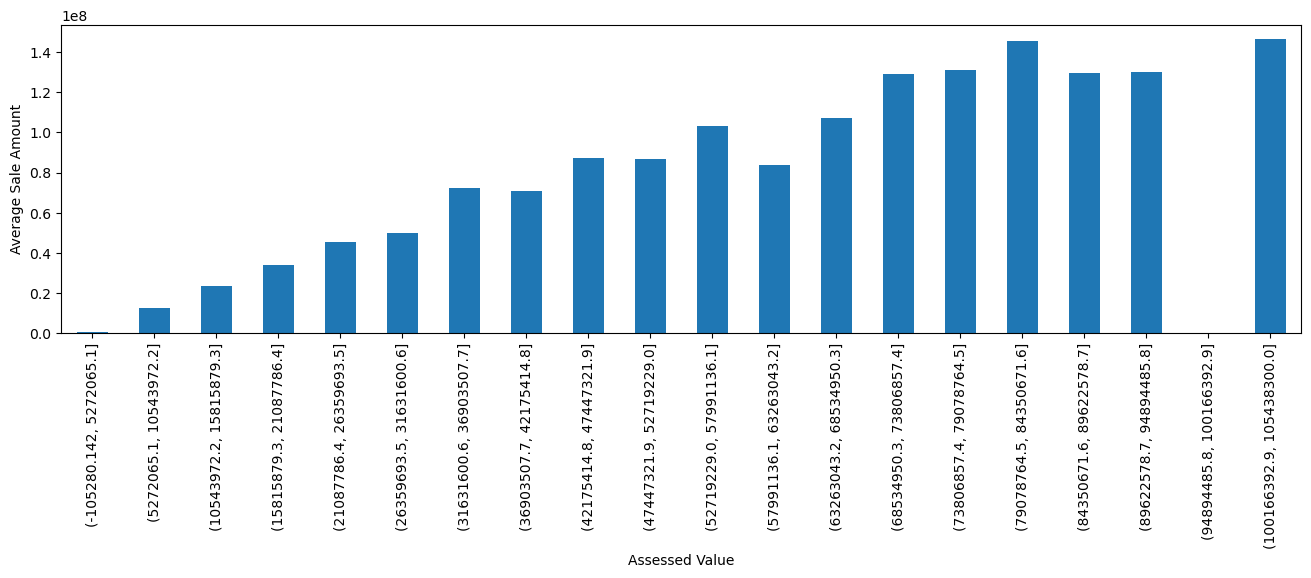

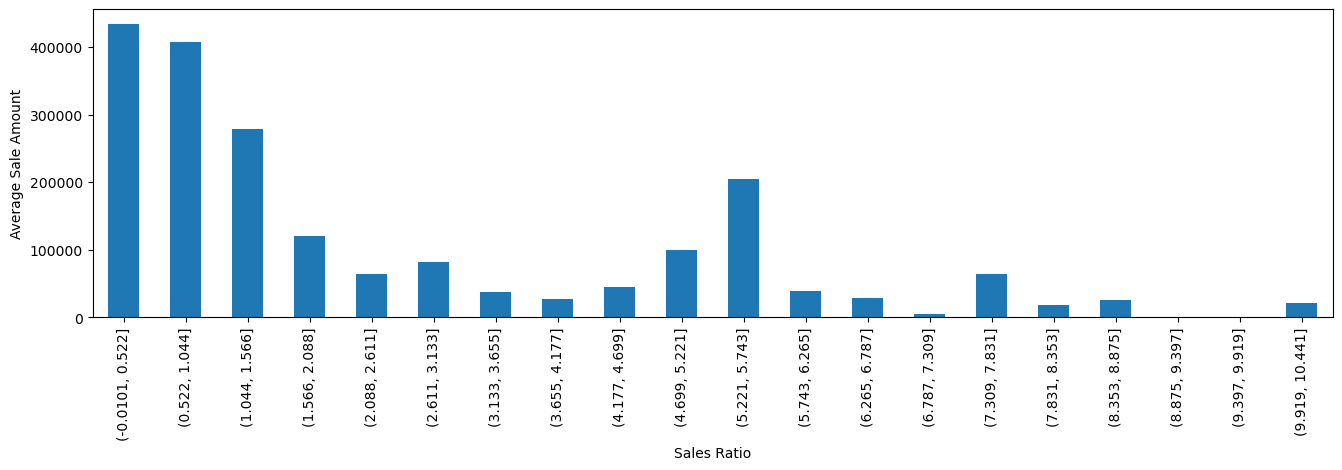

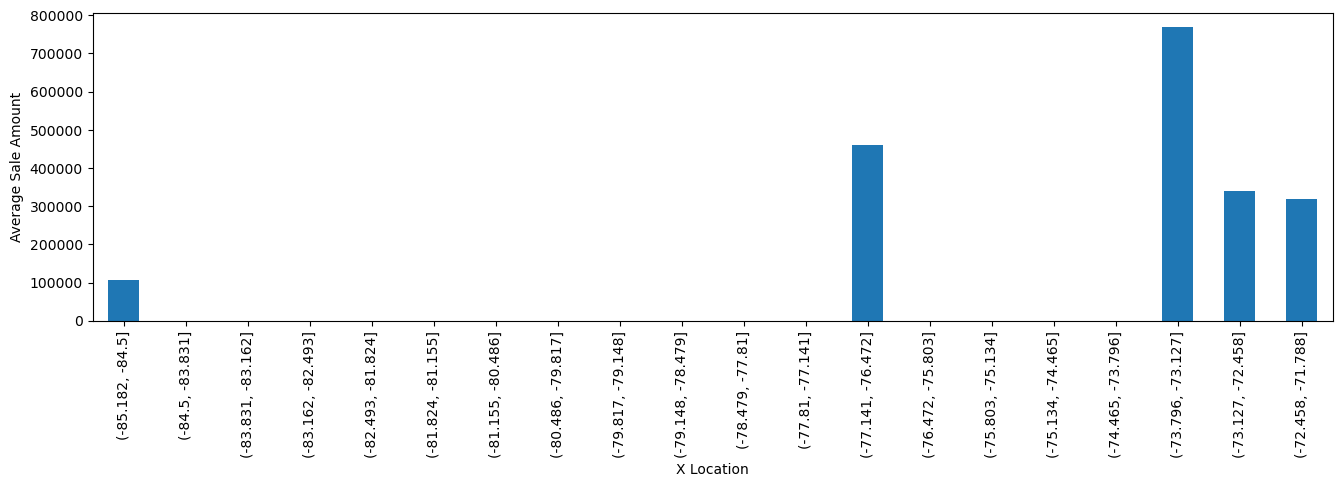

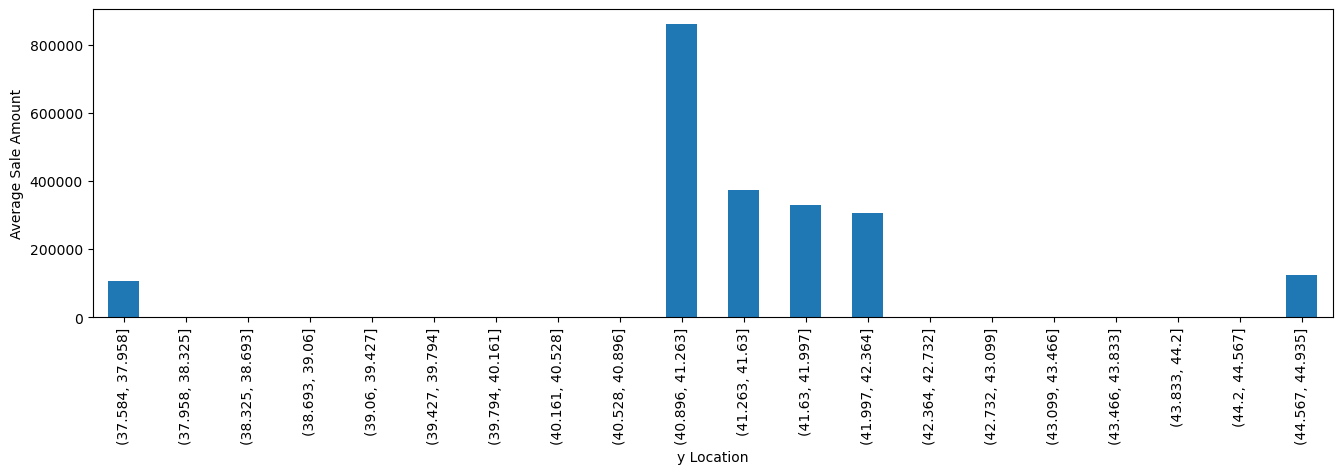

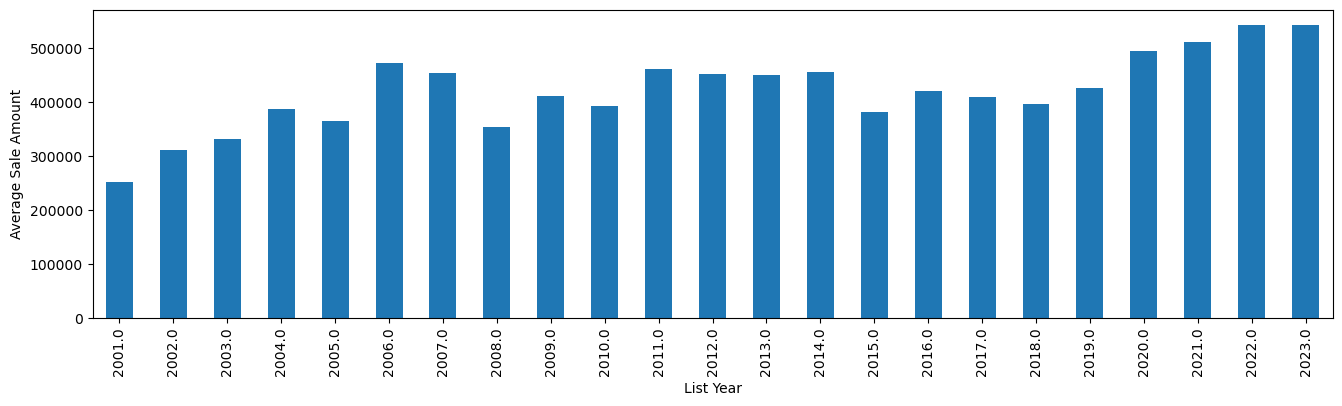

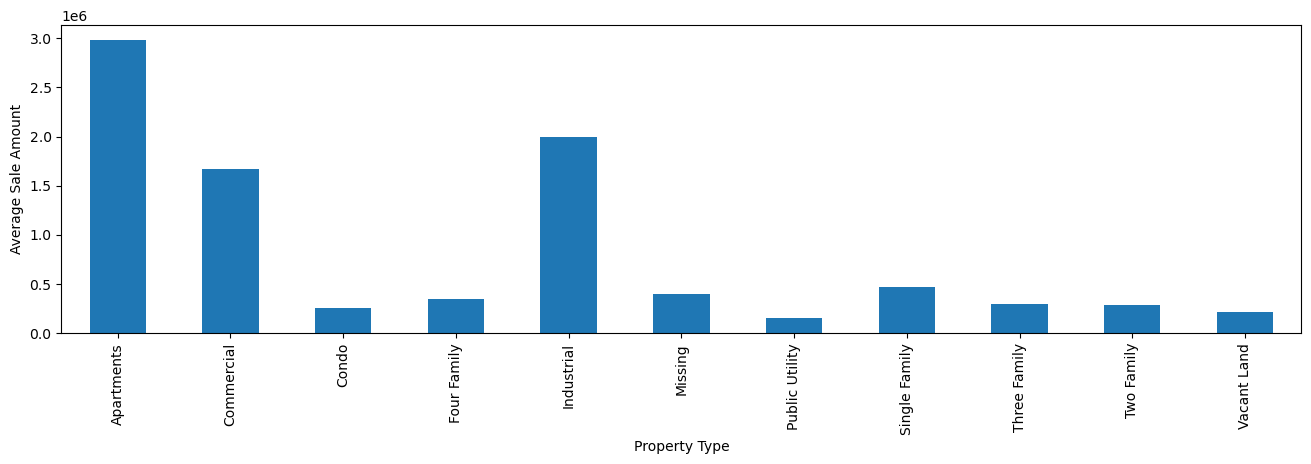

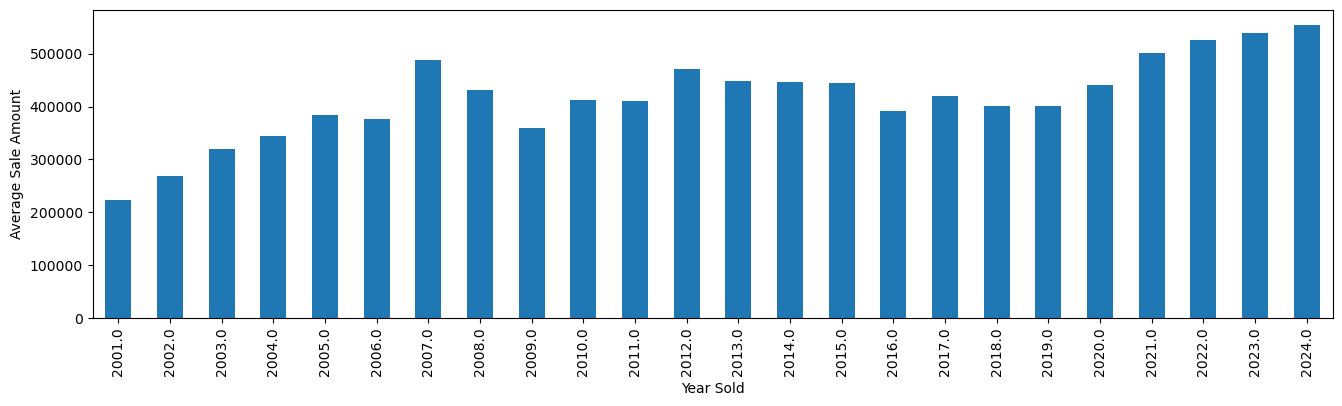

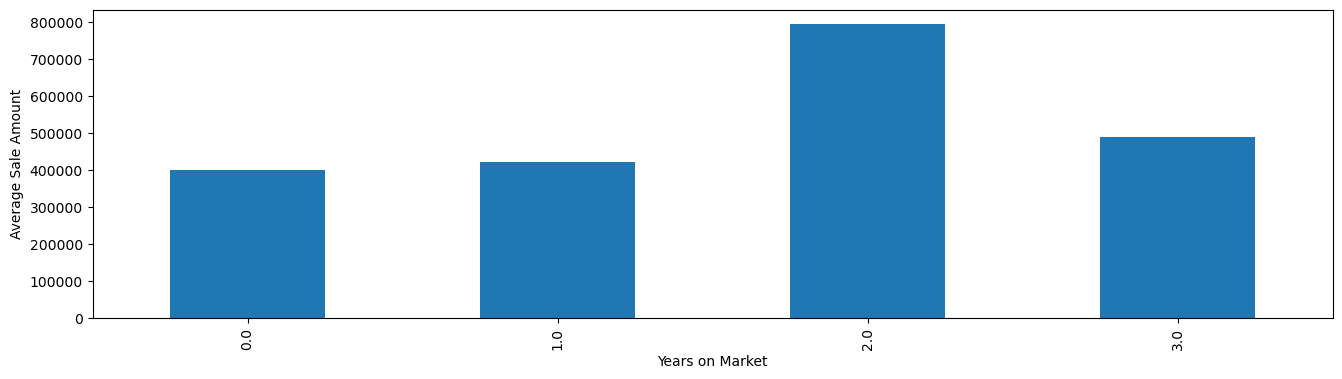

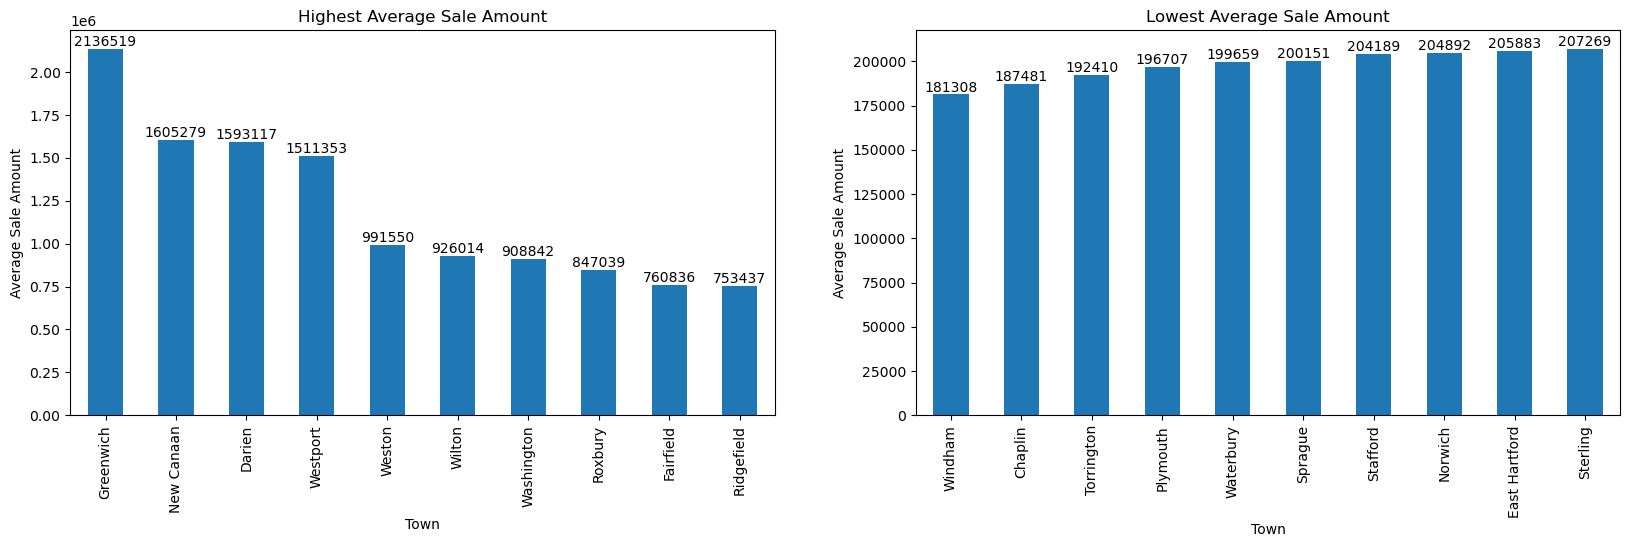

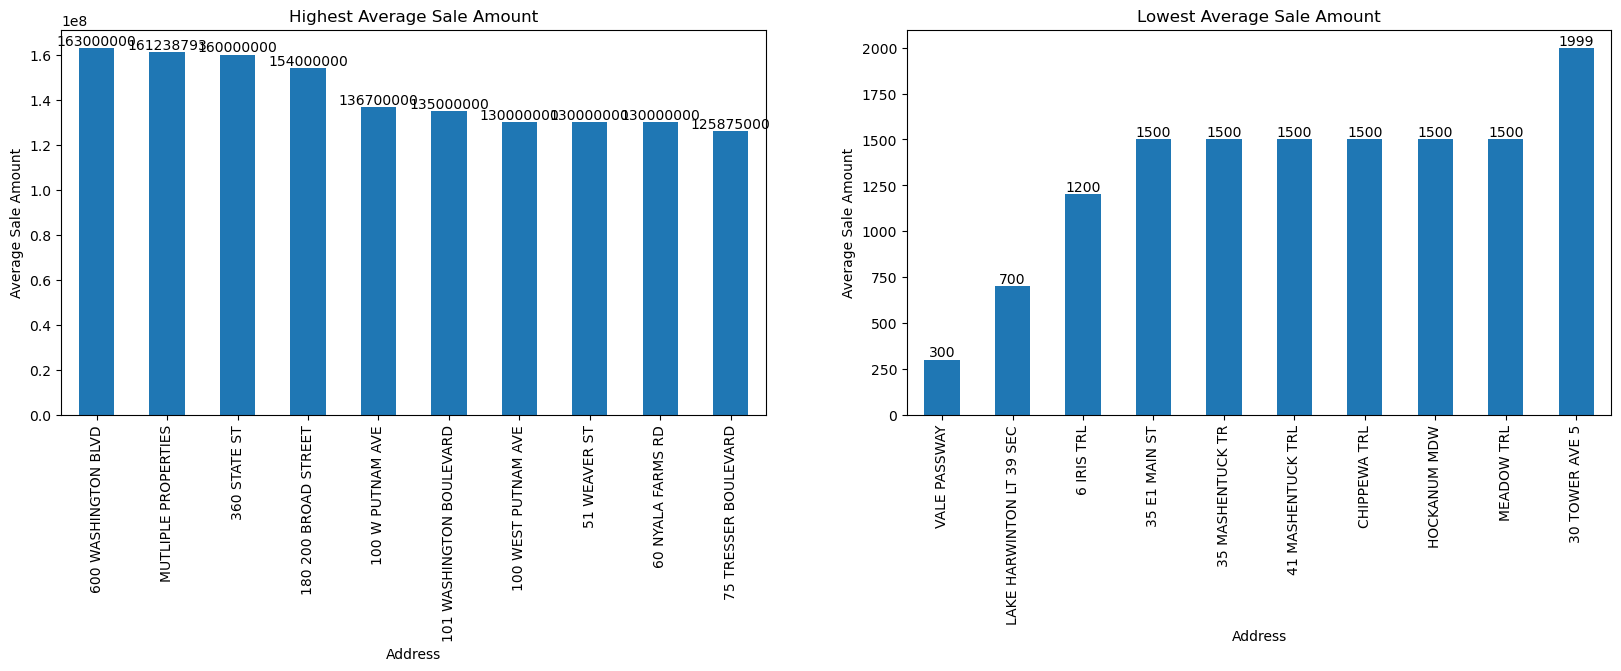

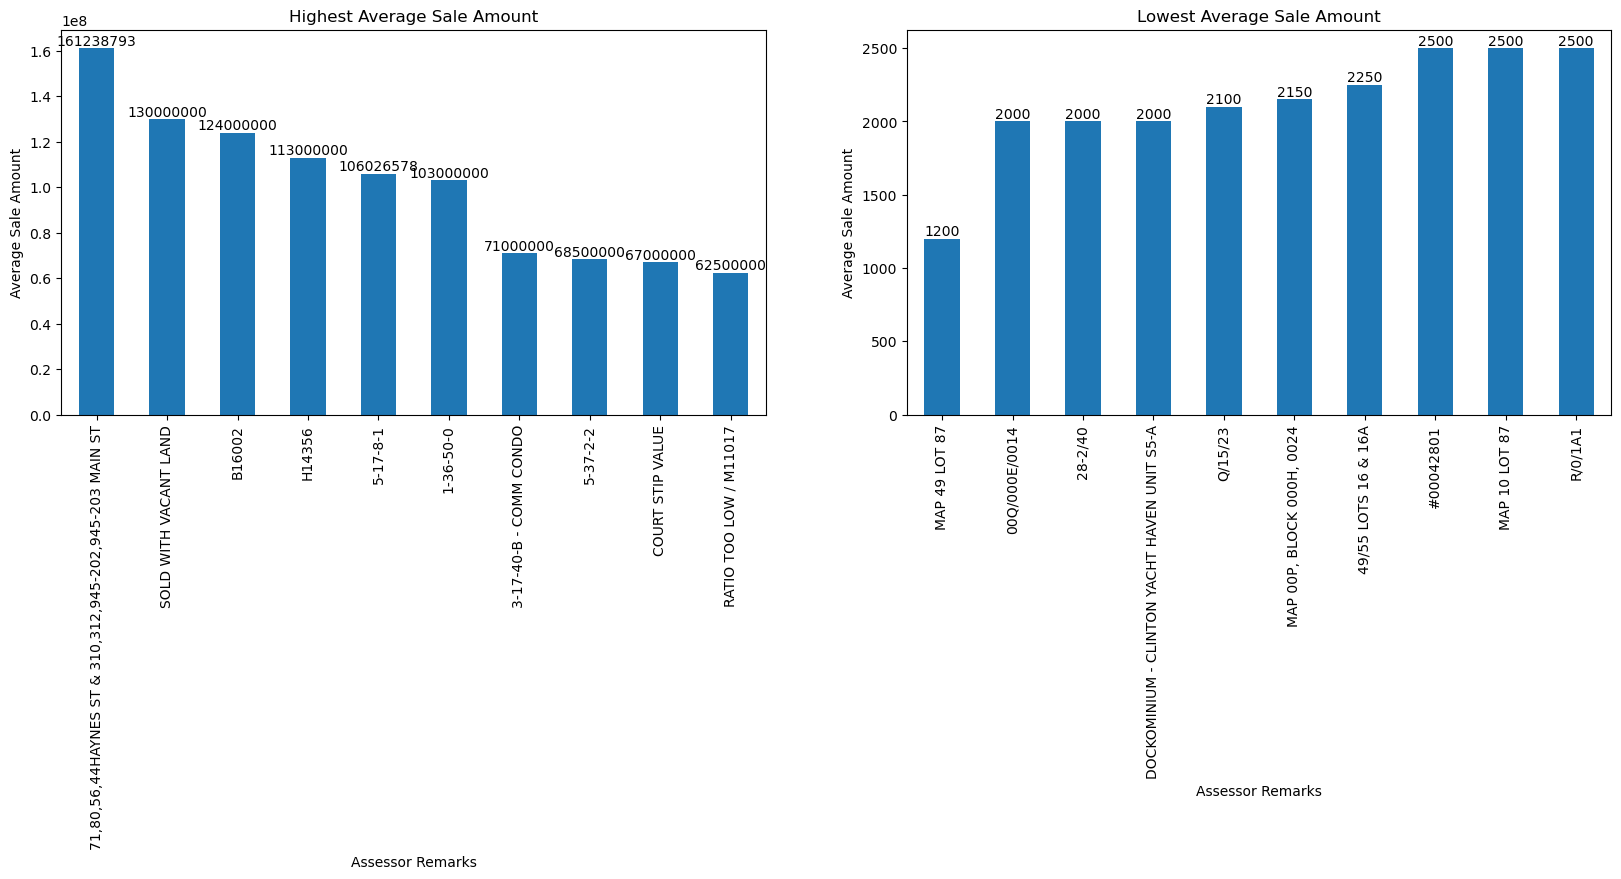

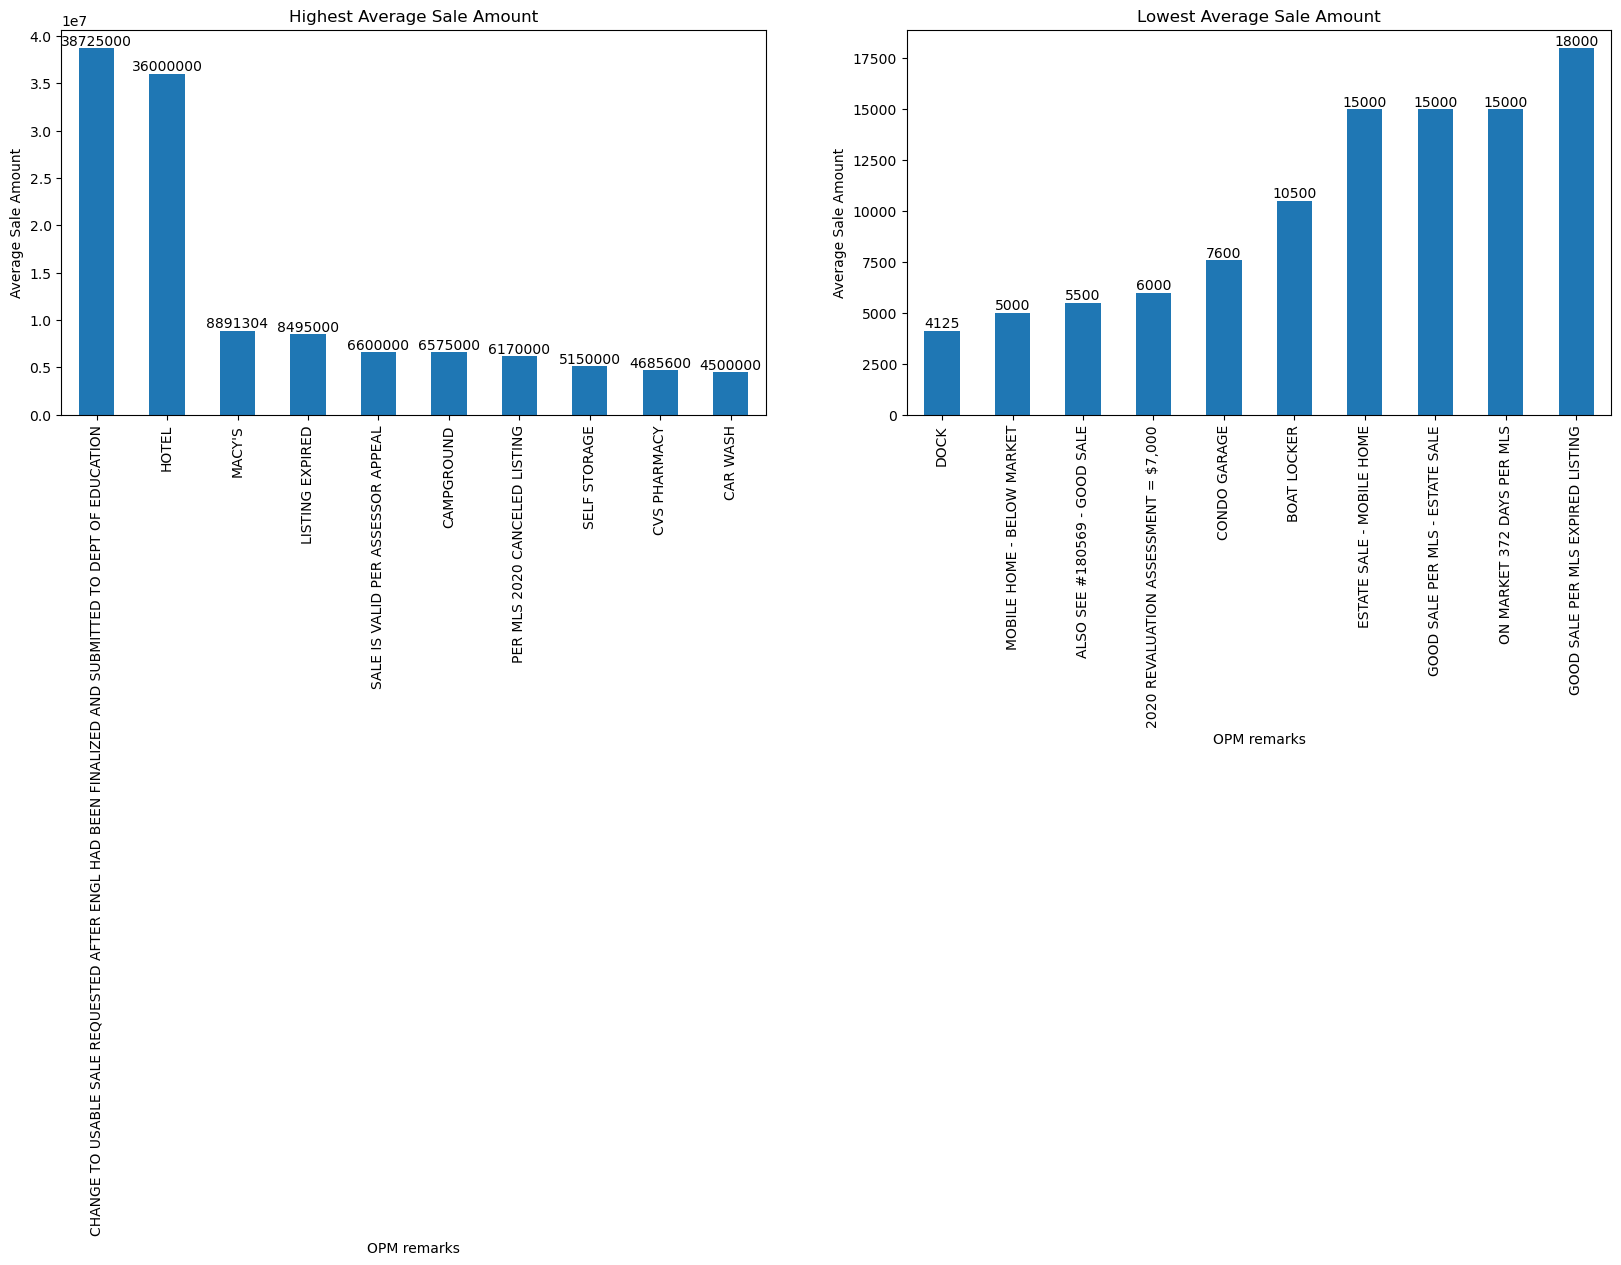

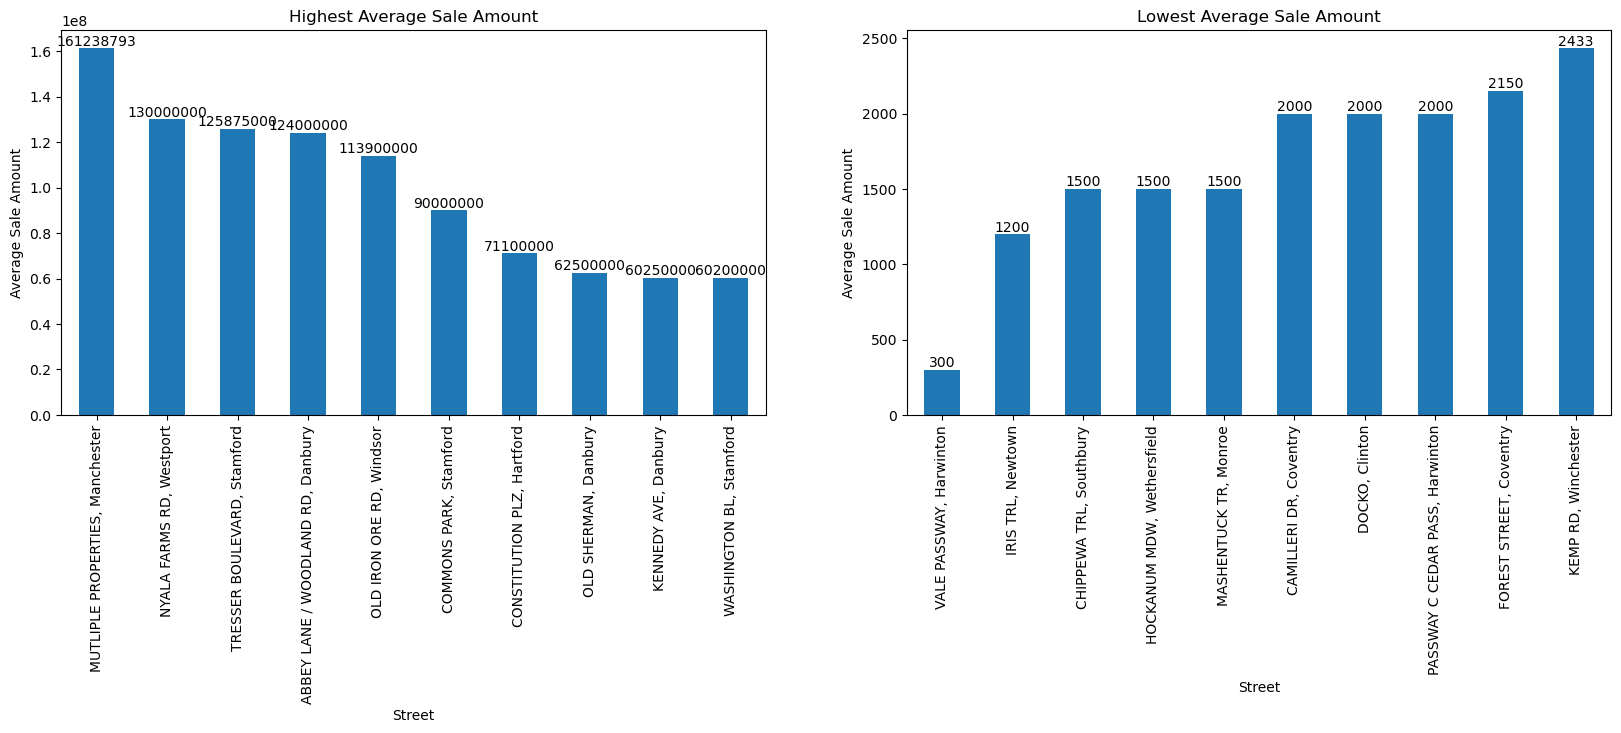

In [28]:
def make_money_plots(result:str)->None:
    
    for col in numeric_columns:
        if col == result:
            continue
    
        plt.figure(figsize=(16,4))
        df.groupby(pd.cut(df[col],bins = 20),observed=False)[result].mean().plot(kind='bar')
        plt.xlabel(col)
        plt.ylabel(f'Average {result}')
        plt.show()


    for col in bar_columns:
    
        plt.figure(figsize=(16,4))
        ax = df.groupby(col,observed=False)[result].mean().plot(kind='bar')
        plt.xlabel(col)
        plt.ylabel(f'Average {result}')
        plt.show()
    
    for col in large_bar_columns:
    
        fix, (ax1, ax2) = plt.subplots(1,2,figsize=(20,5))
        df.groupby(col,observed=False)[result].mean().nlargest(10).plot(kind='bar',ax=ax1)
        df.groupby(col,observed=False)[result].mean().nsmallest(10).plot(kind='bar',ax=ax2)

        fmt = '%.0f'
        if result == 'Sales Ratio':
            fmt = '%.2f'
        ax1.set_title(f'Highest Average {result}')
        ax1.bar_label(ax1.containers[0],fmt=fmt)
        ax1.set_ylabel(f'Average {result}')
        
        ax2.set_title(f'Lowest Average {result}')
        ax2.bar_label(ax2.containers[0],fmt=fmt)
        ax2.set_ylabel(f'Average {result}')    
    
        plt.show()

make_money_plots('Sale Amount')

## Average Assessed Value

The following bar plots display numeric and categorical features grouped against average `Assessed Value` to find features correlated with `Assessed Value`.

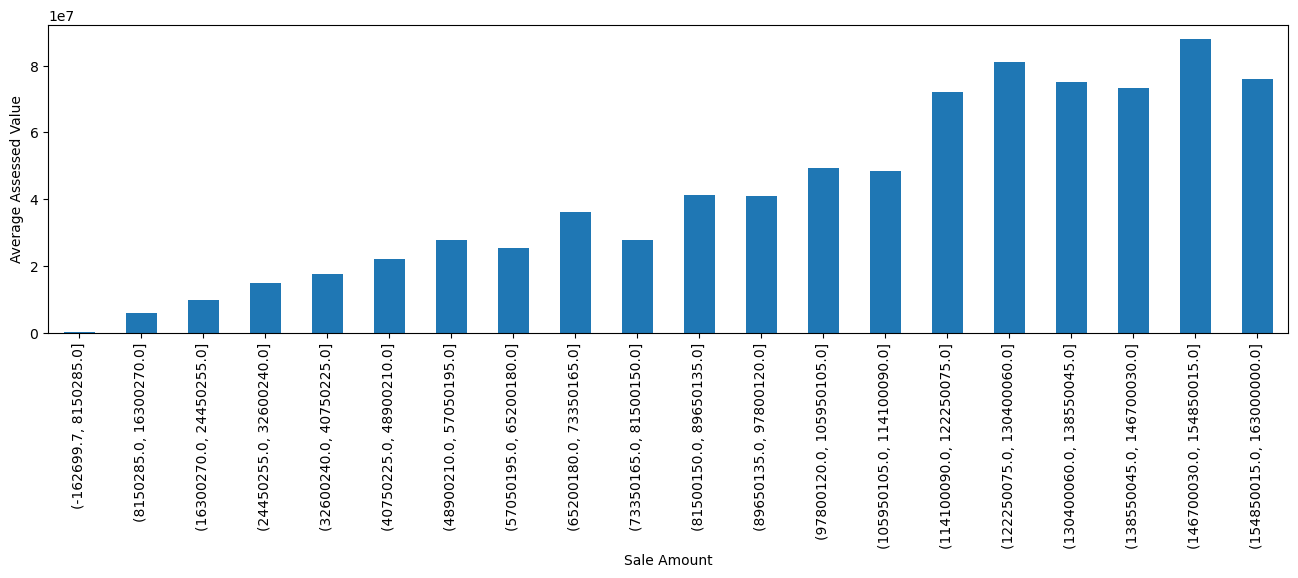

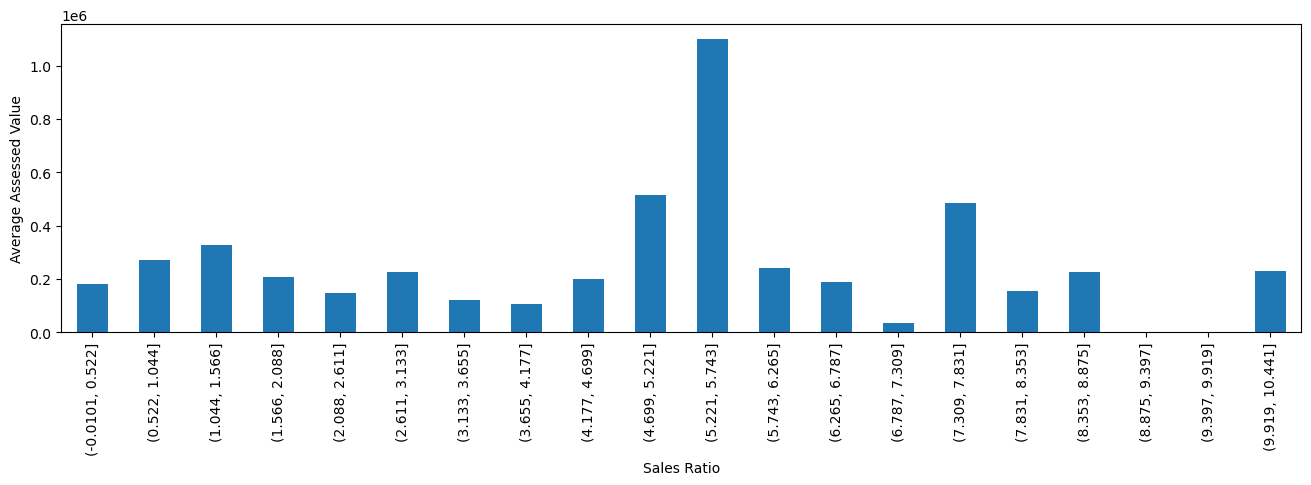

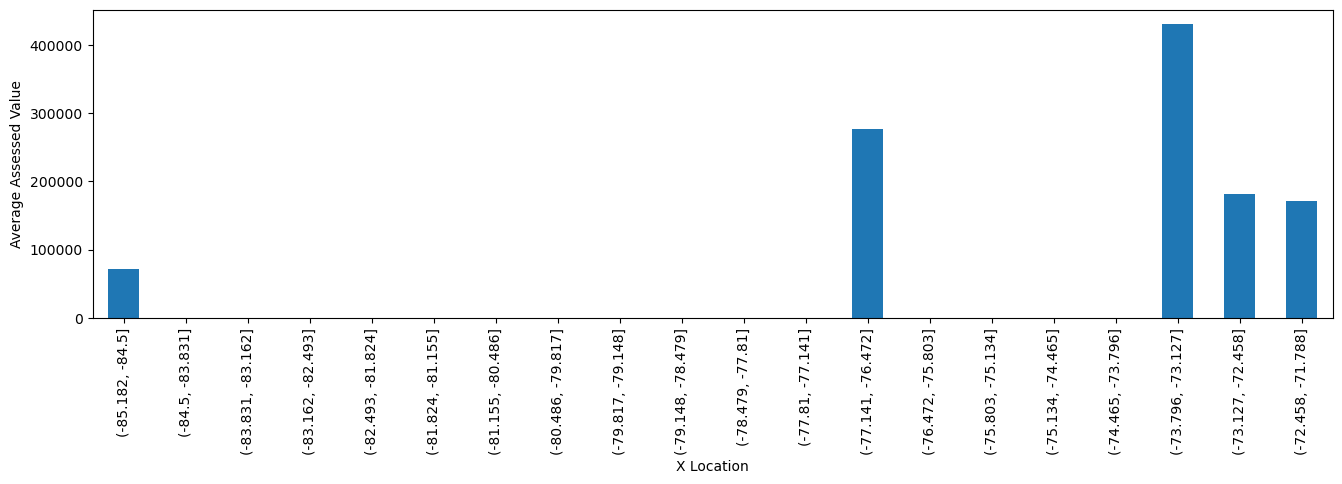

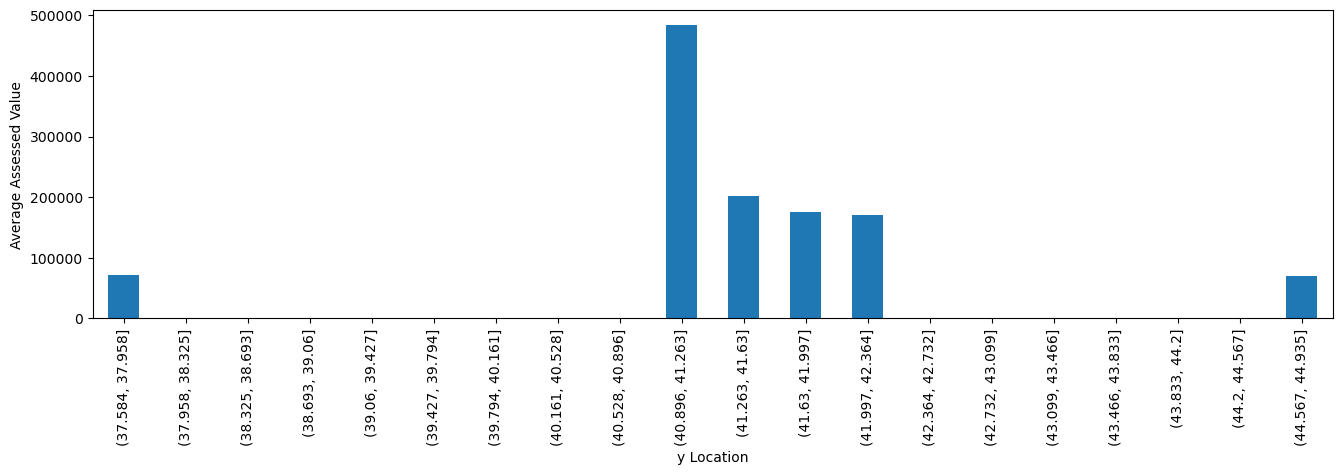

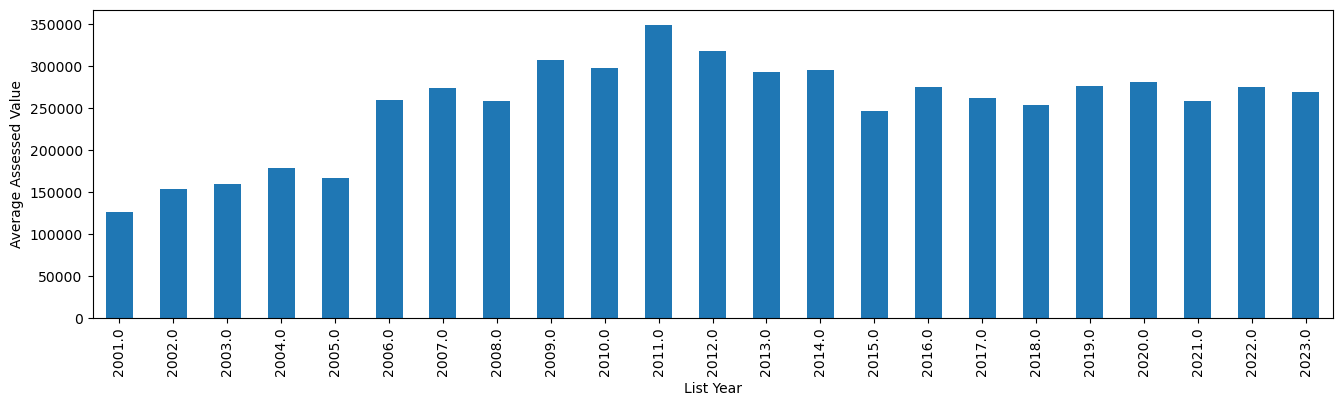

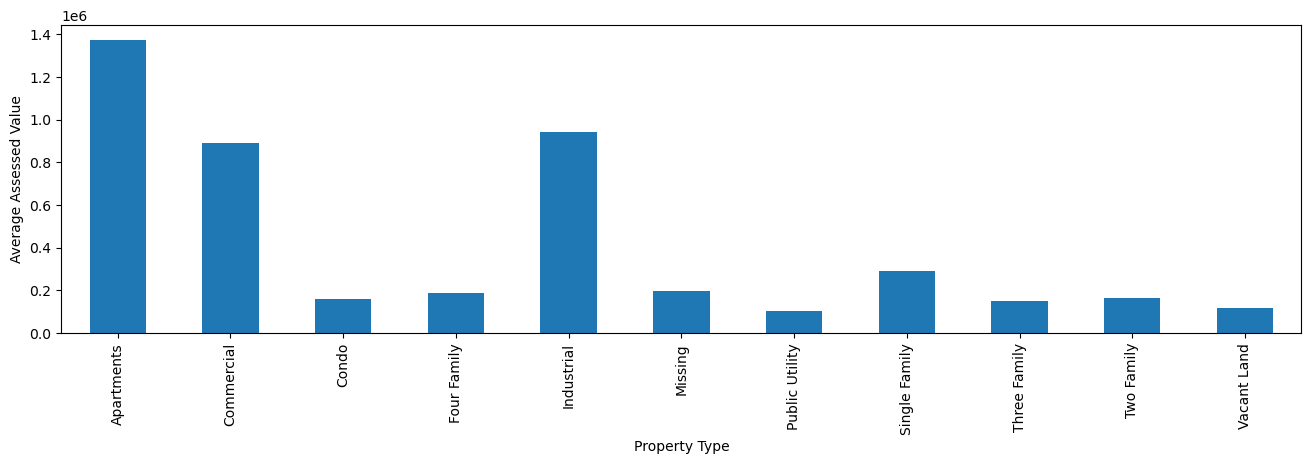

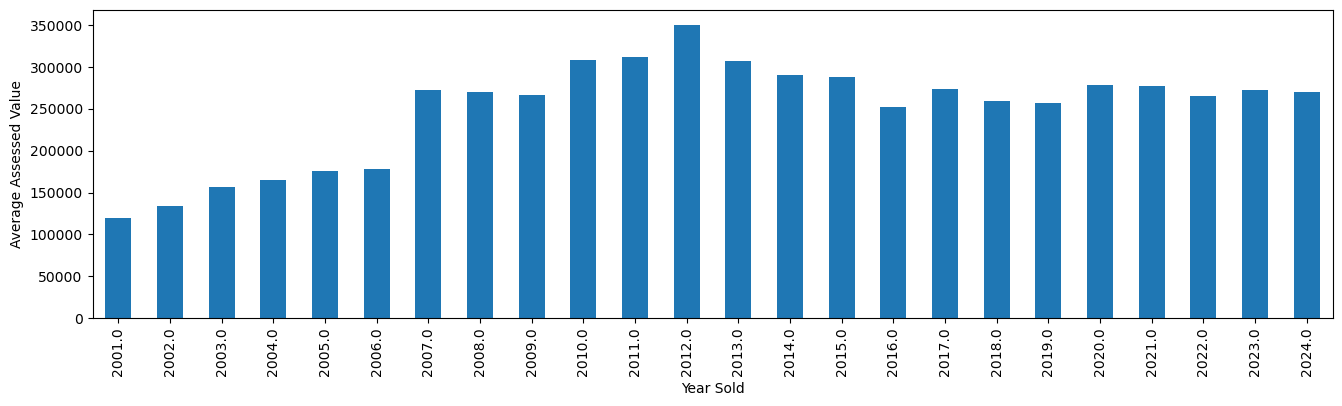

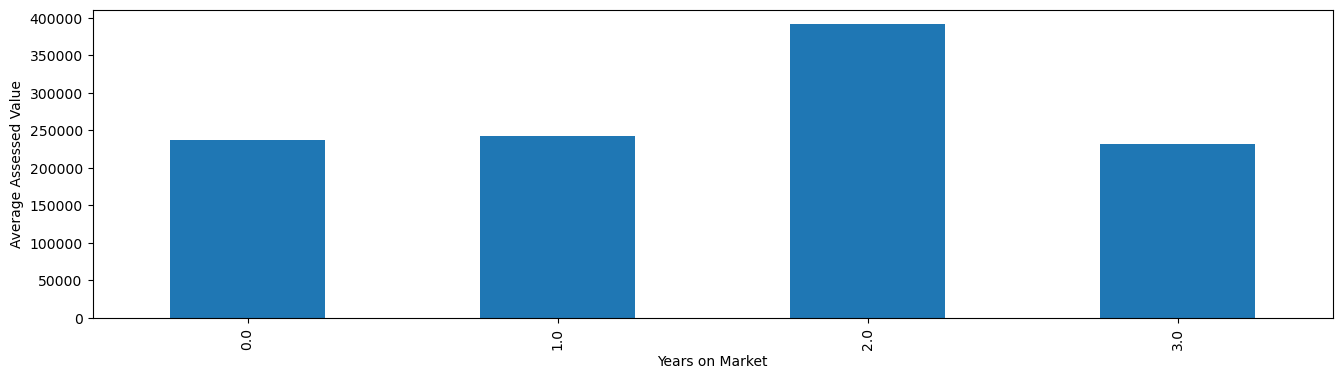

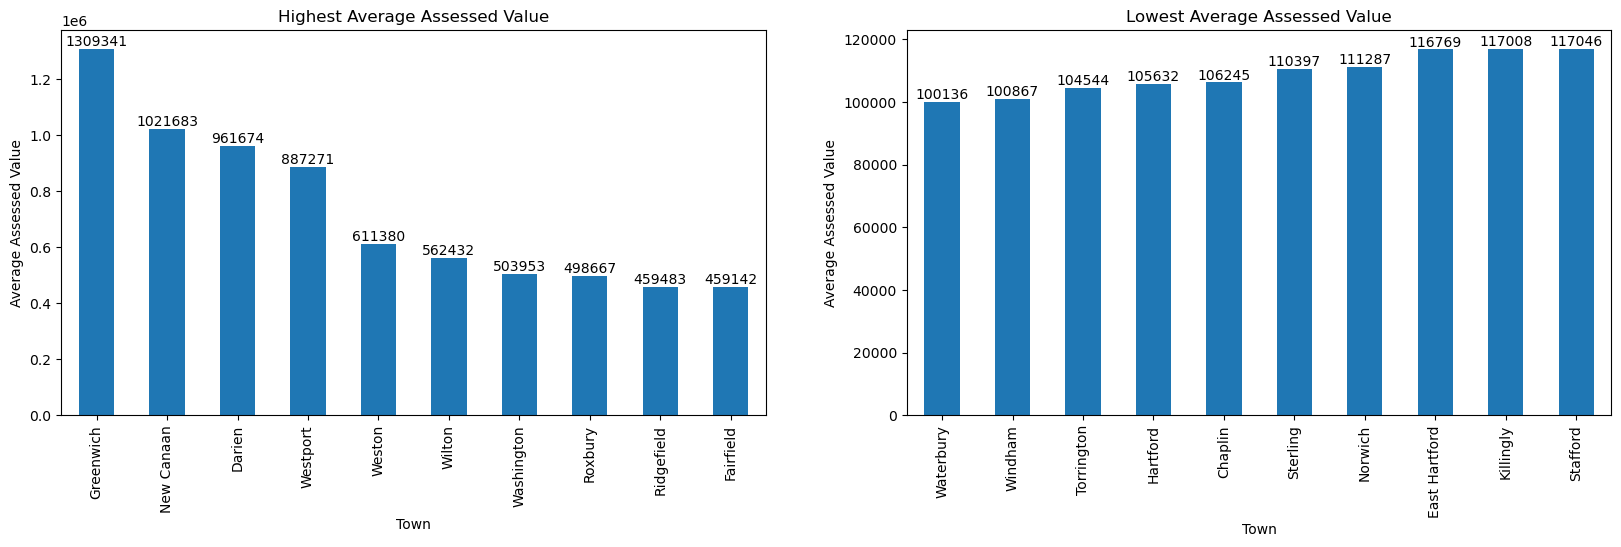

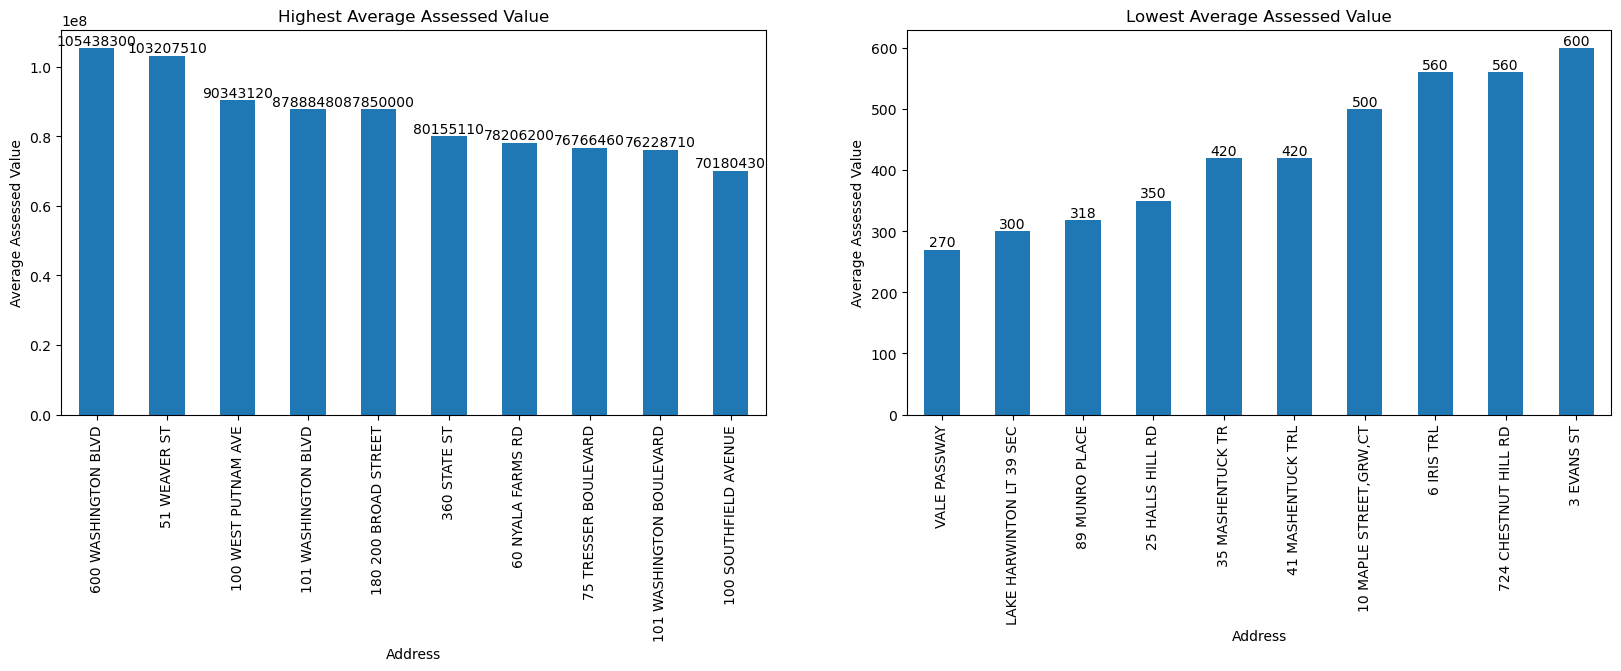

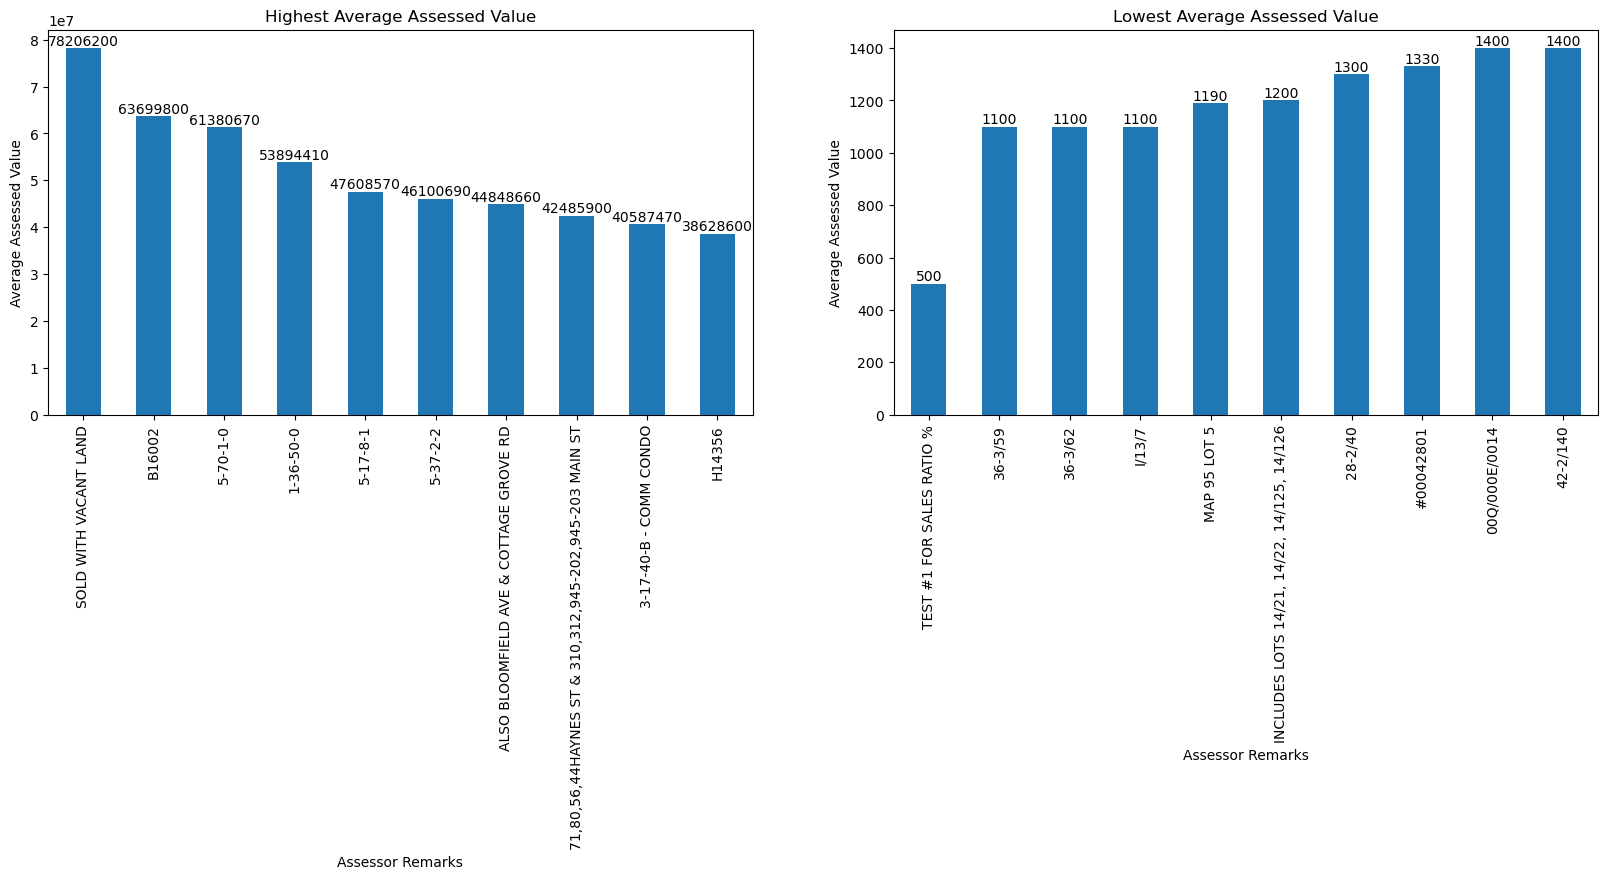

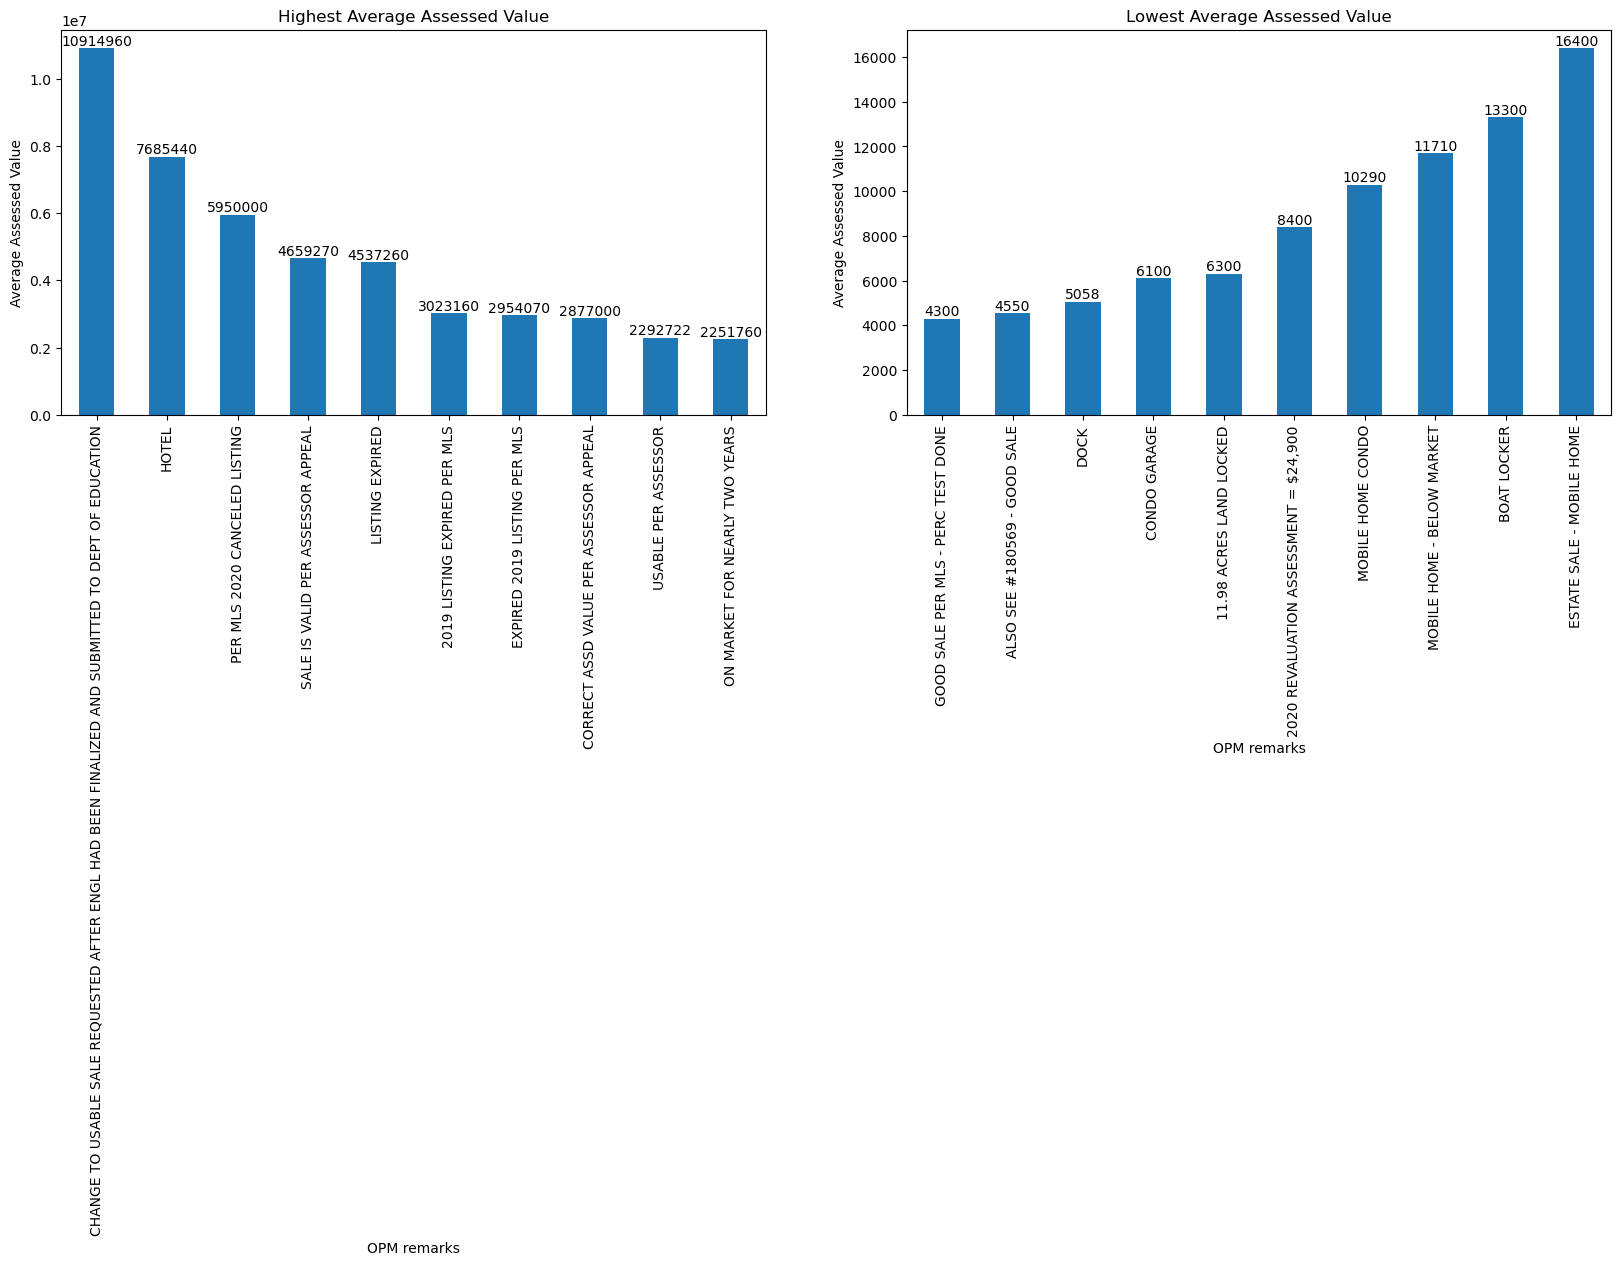

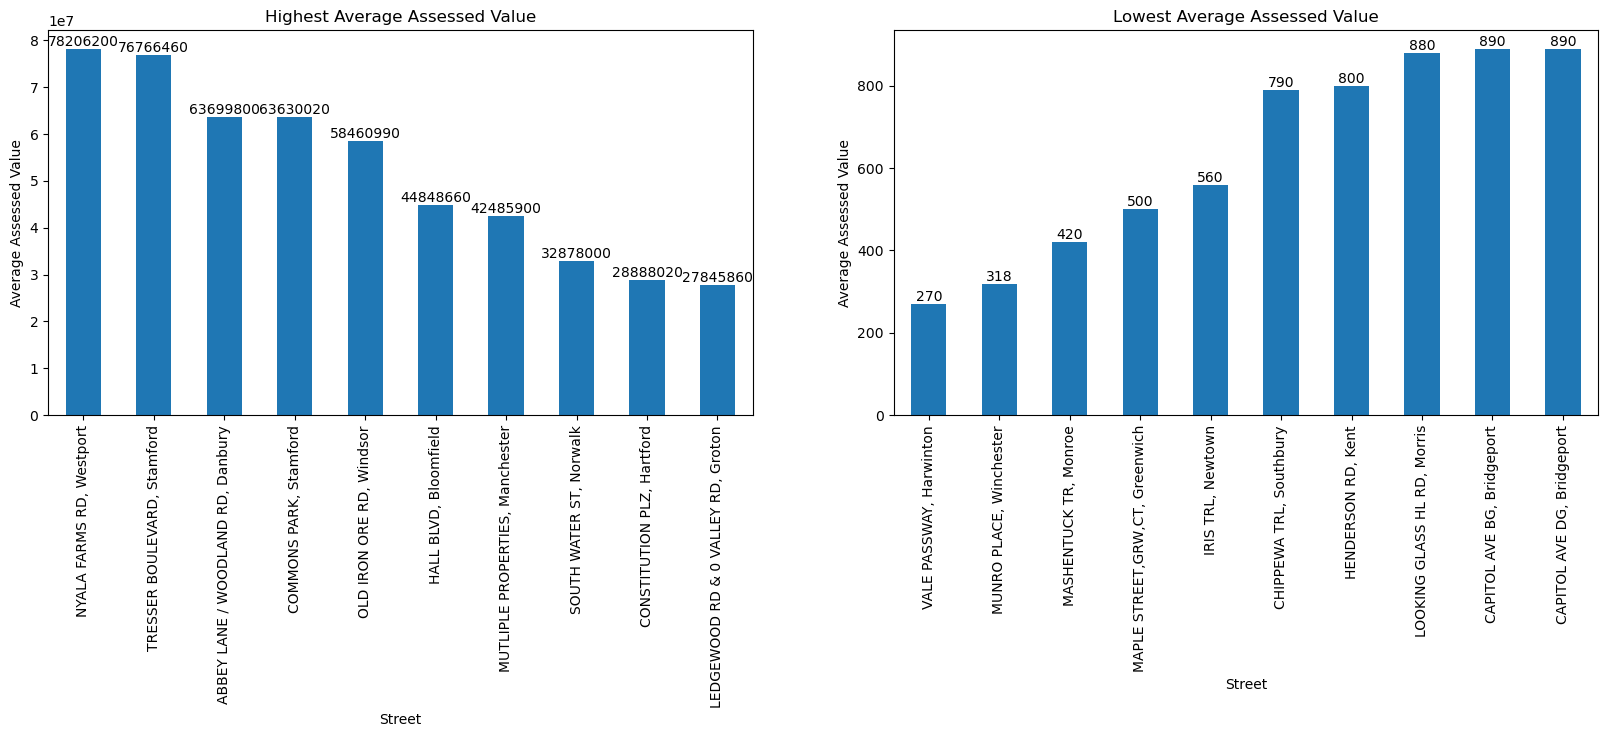

In [29]:
make_money_plots('Assessed Value')

## Average Sales Ratio

The following bar plots display numeric and categorical features grouped against average 'Sales Ratio' (average 'Assessed Value' / average 'Sale Amount') to find features correlated with 'Sales Ratio'

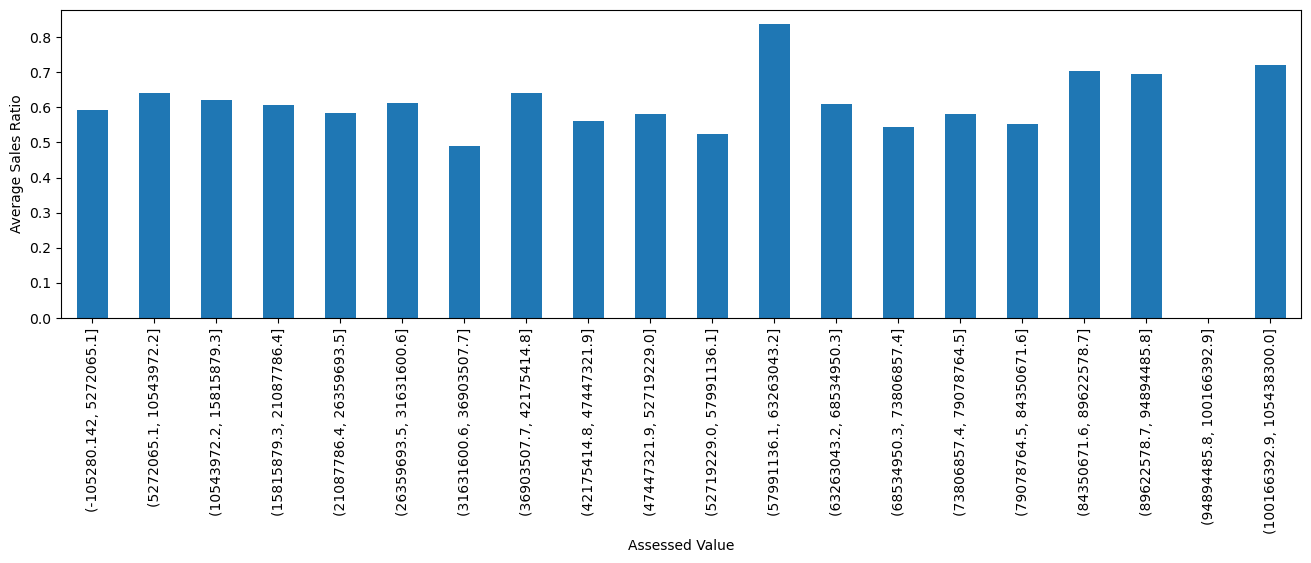

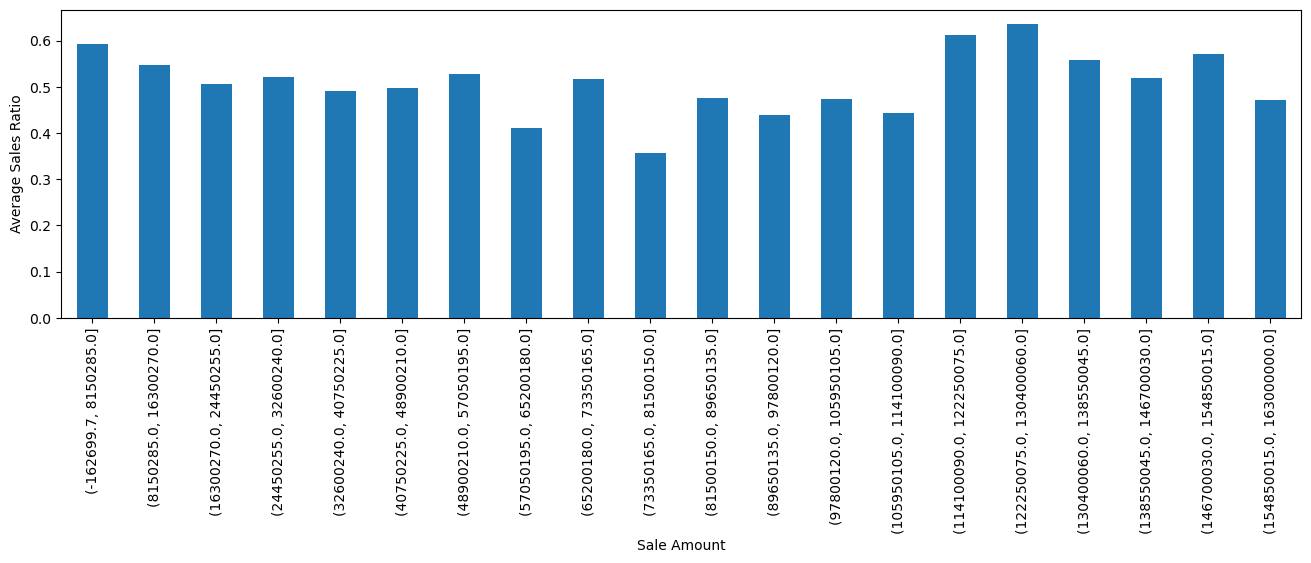

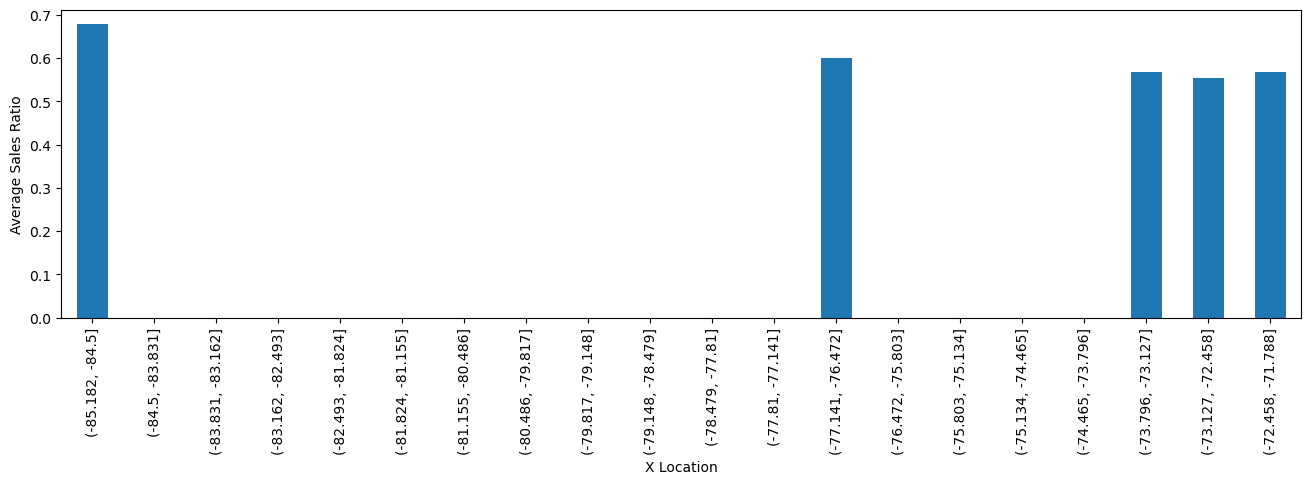

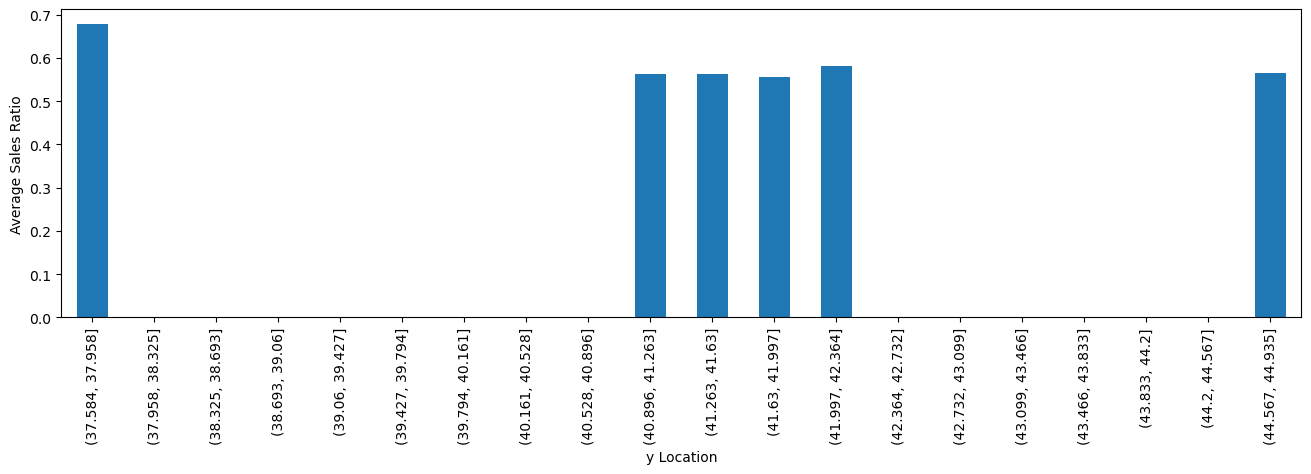

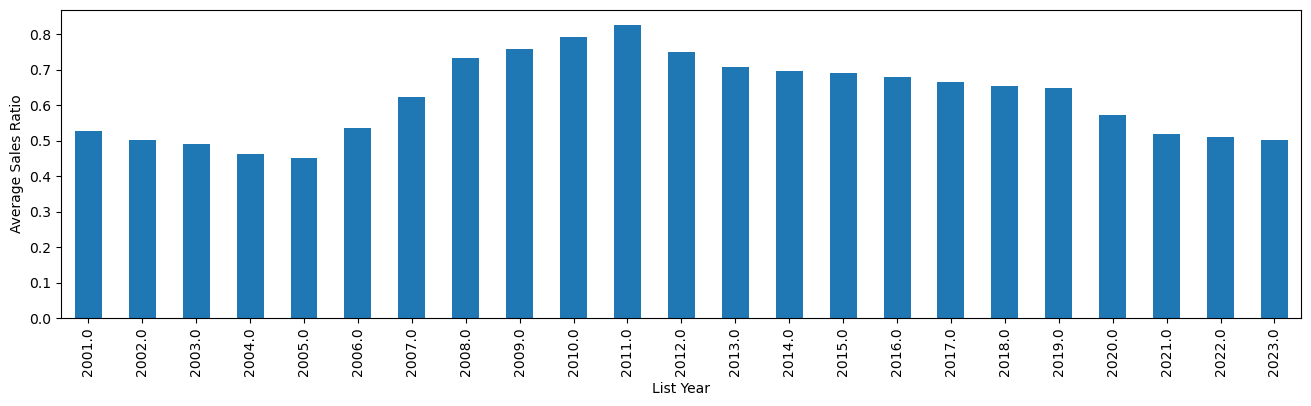

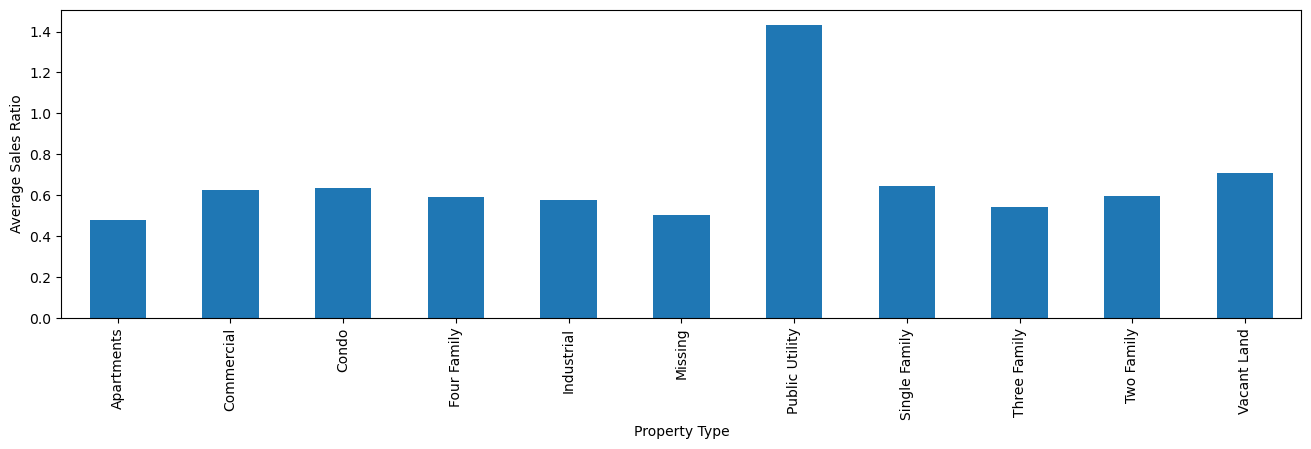

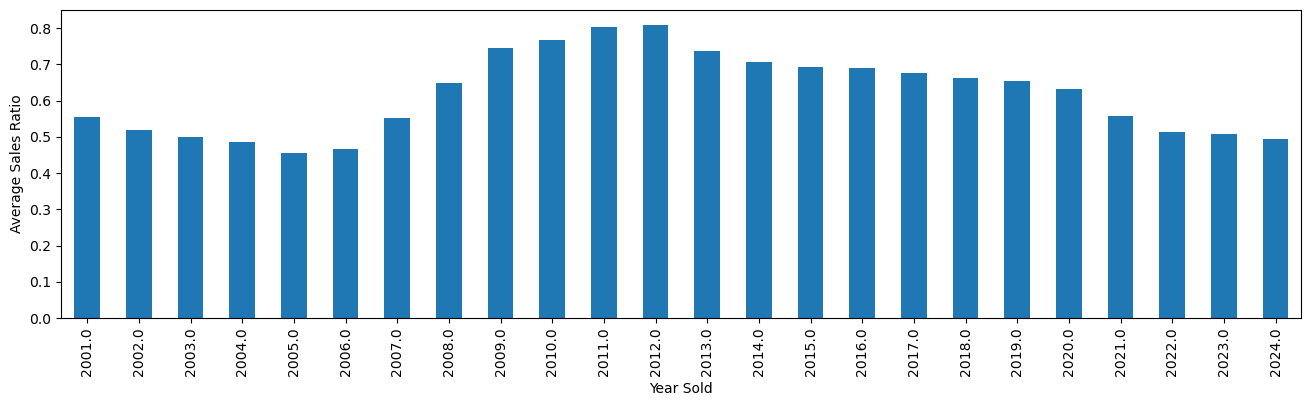

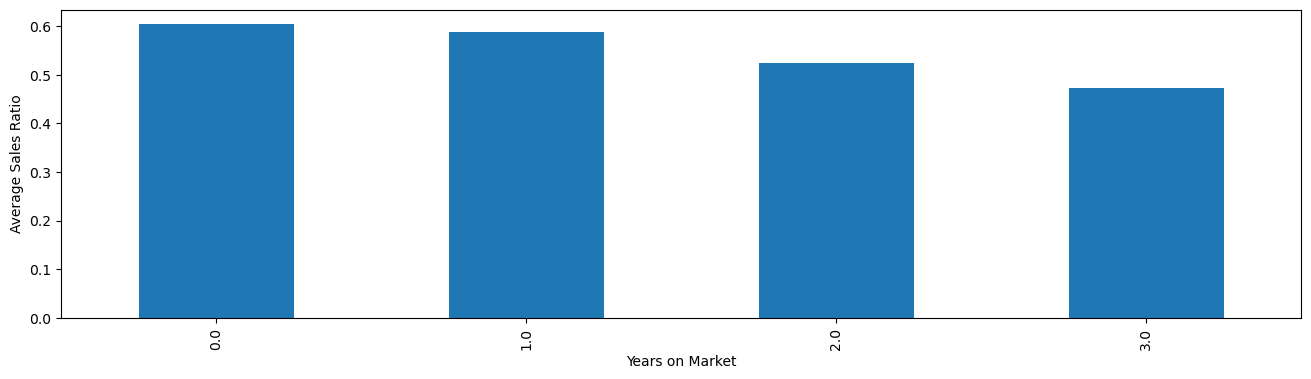

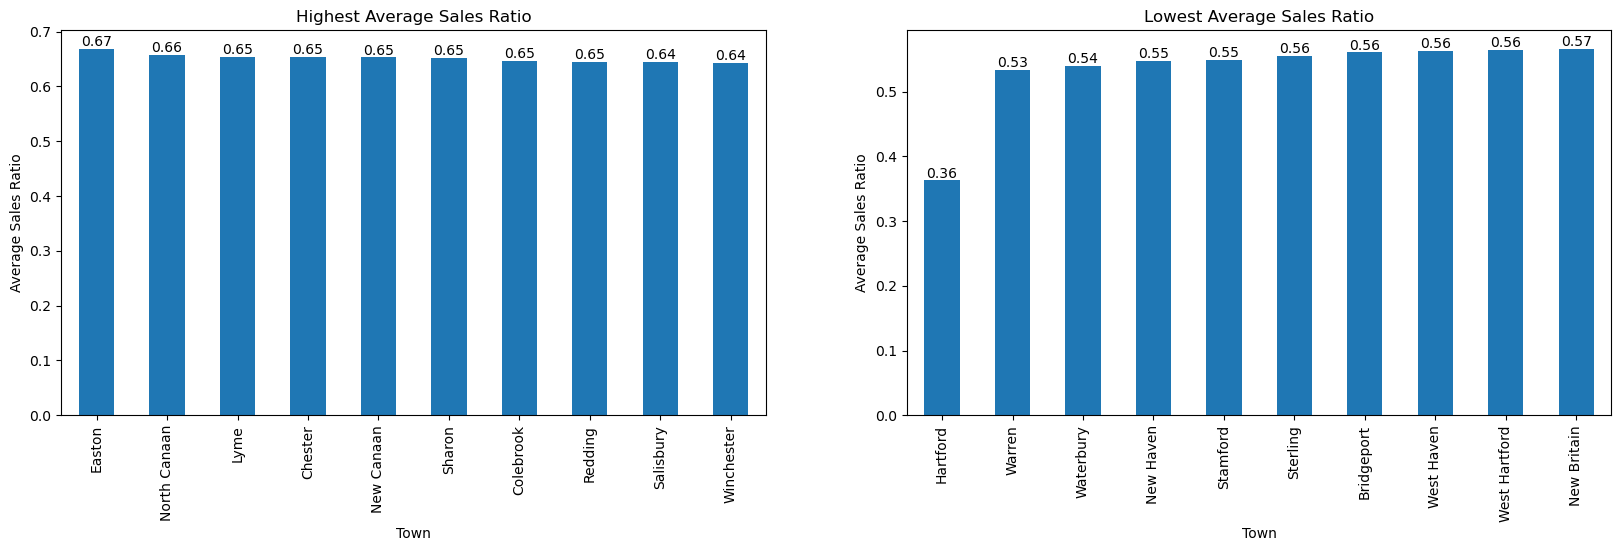

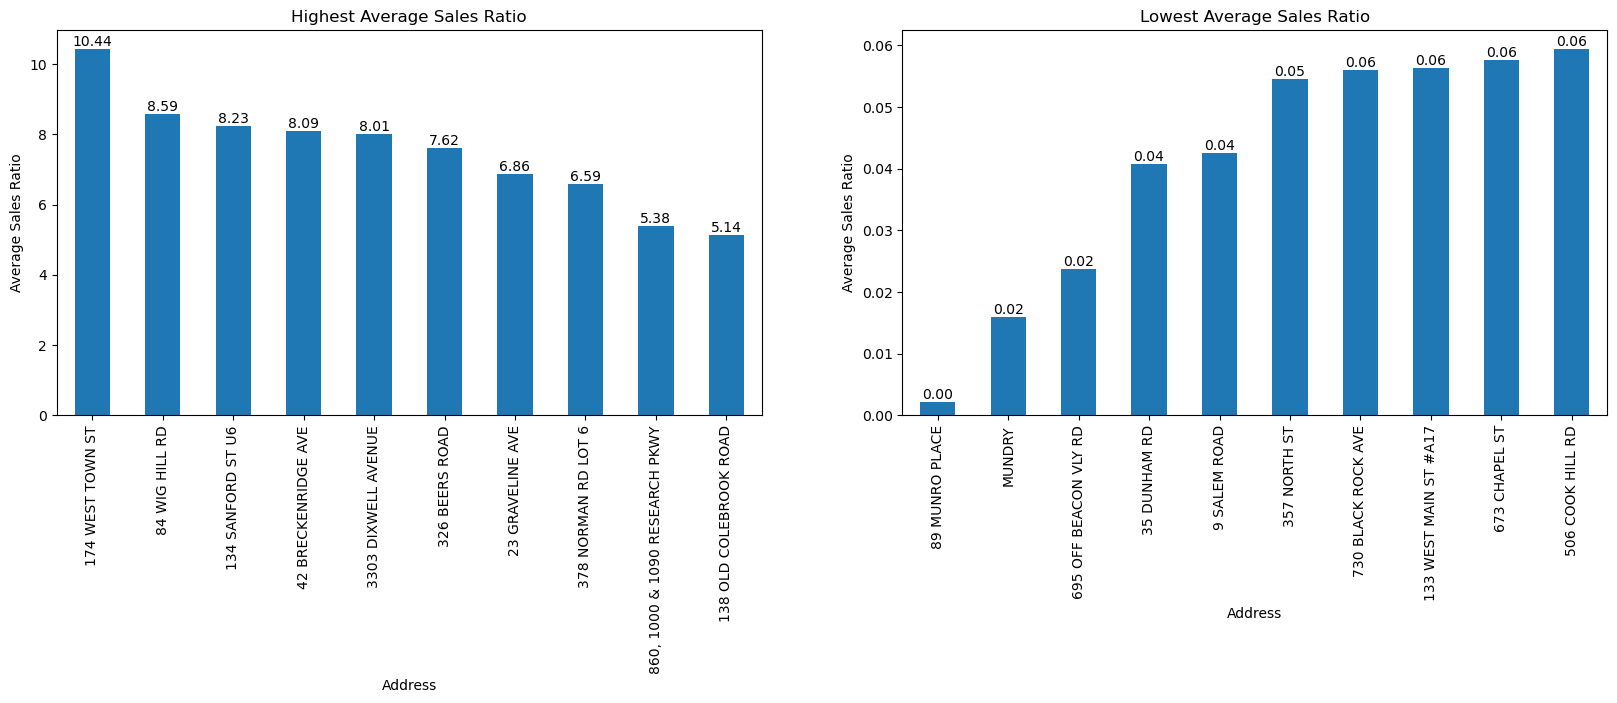

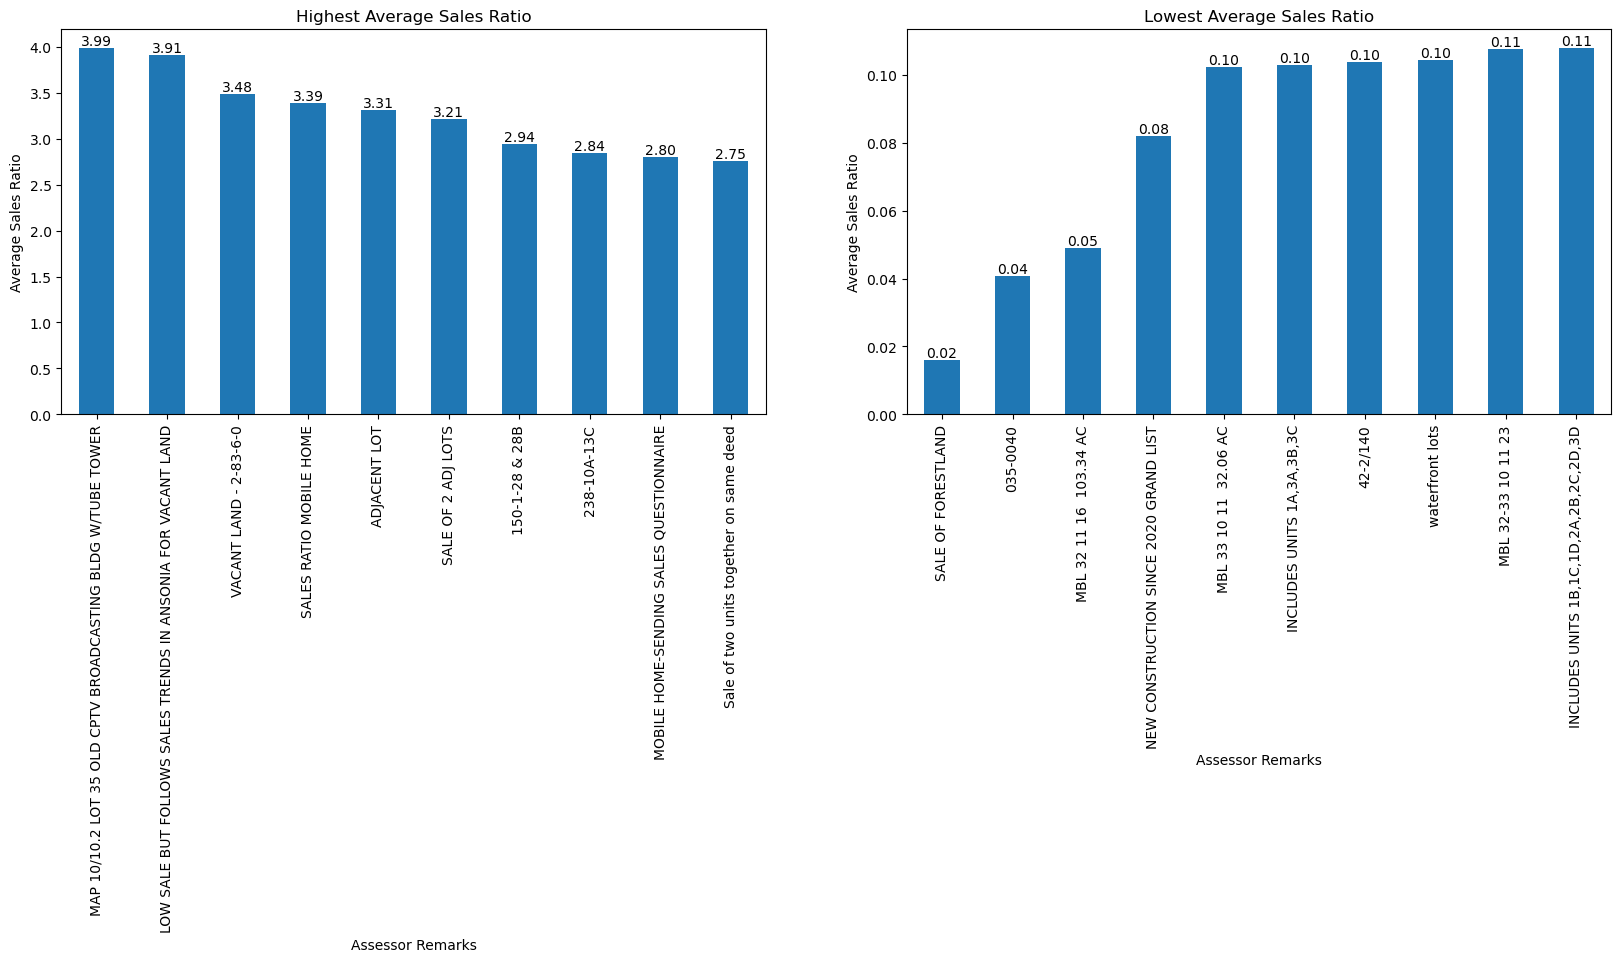

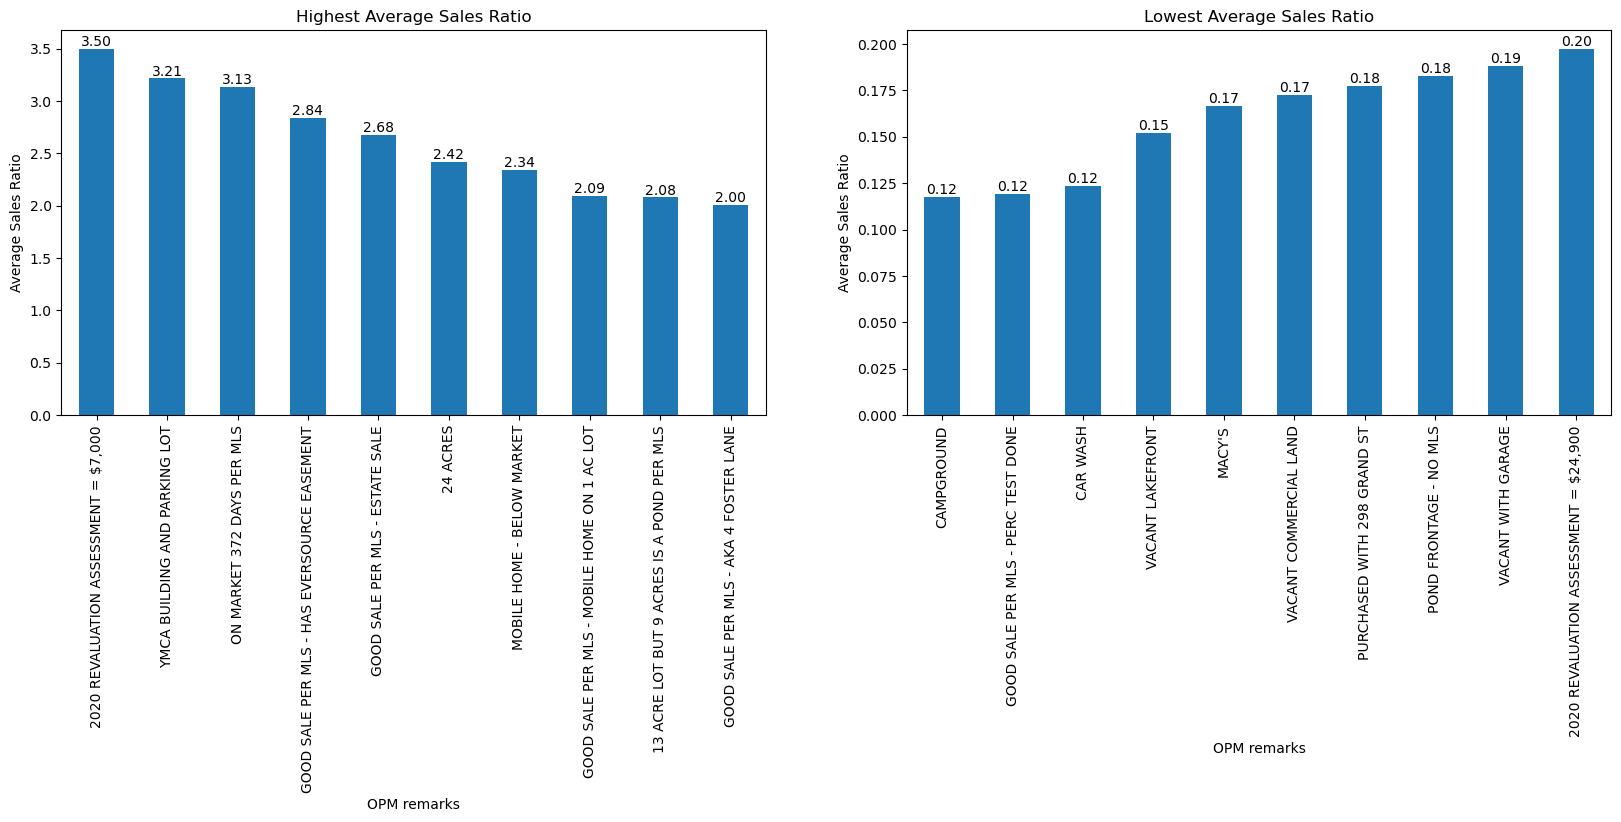

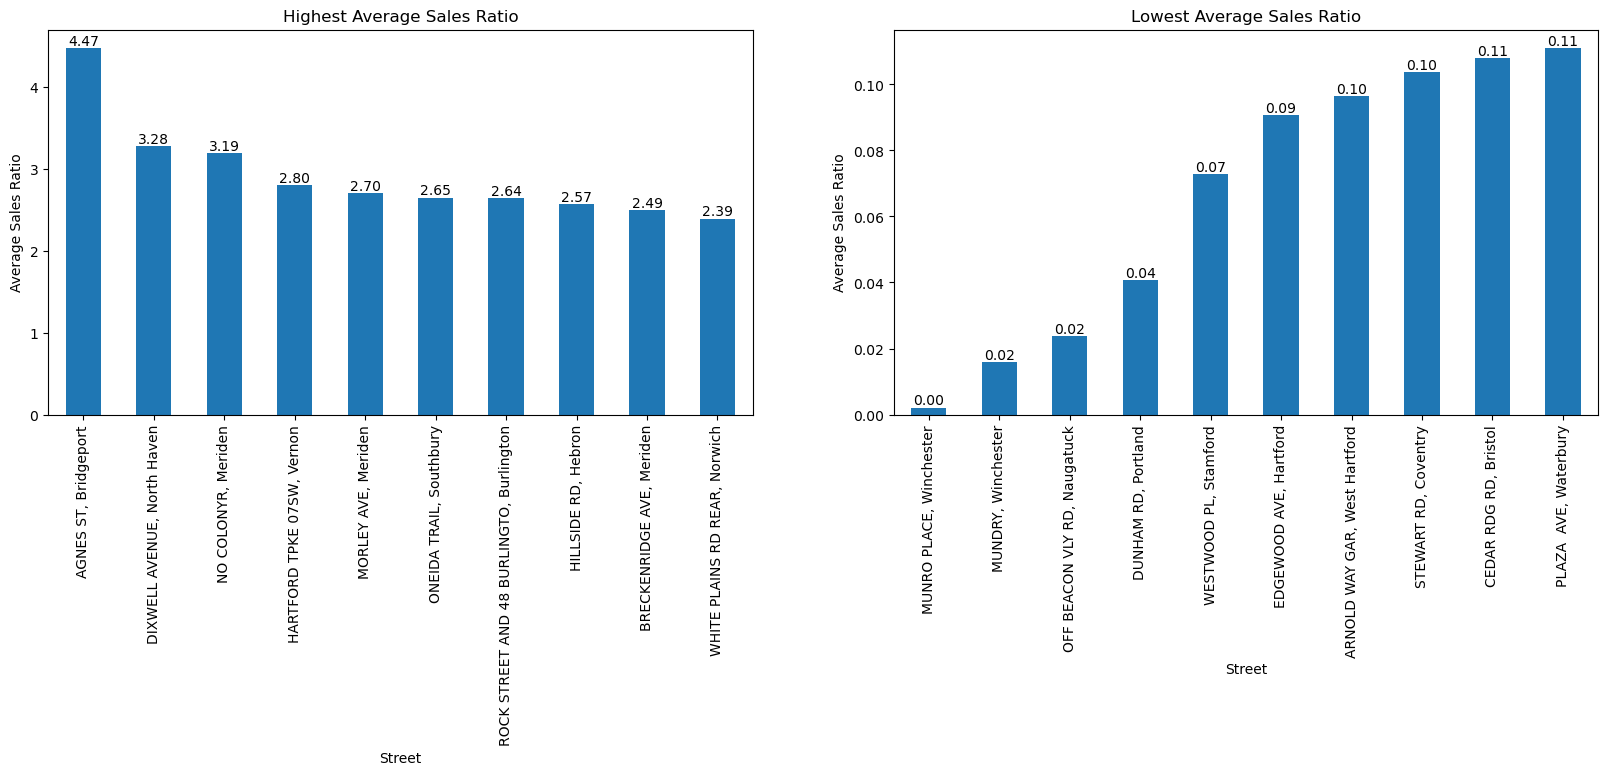

In [30]:
make_money_plots('Sales Ratio')

In [31]:
df.describe()

Serial Number      List Year  Assessed Value   Sale Amount  \
count   8.168180e+05  816818.000000    8.168180e+05  8.168180e+05   
mean    6.054119e+05    2011.552987    2.407886e+05  4.154923e+05   
std     8.074676e+06       7.191303    6.796366e+05  1.238324e+06   
min     2.100000e+01    2001.000000    1.580000e+02  3.000000e+02   
25%     3.072000e+04    2004.000000    9.555000e+04  1.720000e+05   
50%     8.042300e+04    2012.000000    1.481900e+05  2.599000e+05   
75%     1.804270e+05    2018.000000    2.373600e+05  4.005000e+05   
max     2.000500e+09    2023.000000    1.054383e+08  1.630000e+08   

         Sales Ratio     X Location     y Location  sin(Day of Week Sold)  \
count  816818.000000  251955.000000  251955.000000          816818.000000   
mean        0.592462     -72.887451      41.490836               0.327356   
std         0.180209       0.428526       0.259116               0.512585   
min         0.000390     -85.168900      37.591070              -0.974928   
25%         0.472778     -73.204207      41.282692               0.000000   
50%         0.578846     -72.904240      41.488968               0.433884   
75%         0.691500     -72.640580      41.710380               0.781831   
max        10.440900     -71.788500      44.934590               0.974928   

       cos(Day of Week Sold)  sin(Day of Year Sold)  cos(Day of Year Sold)  \
count          816818.000000          816818.000000          816818.000000   
mean               -0.014388              -0.068767              -0.108351   
std                 0.793655               0.695940               0.706541   
min                -0.900969              -0.999991              -0.999963   
25%                -0.900969              -0.752667              -0.819015   
50%                -0.222521              -0.145799              -0.200891   
75%                 0.623490               0.601624               0.570242   
max                 1.000000               0.999991               1.000000   

         Year Sold  Years on Market  
count     816818.0         816818.0  
mean   2012.300408         0.747421  
std       7.194118         0.434506  
min         2001.0              0.0  
25%         2005.0              0.0  
50%         2012.0              1.0  
75%         2019.0              1.0  
max         2024.0              3.0

## Findings

-**Assessed Value and Sale Amount**: Both are skewed to the right, indicating a large prescence of low- and mid-range properties compared to luxury properties.

-**Sales Ratio**: The mean `Sales Ratio` is 0.59, indicating that on average properties are sold for more than there assessed values. There is large variation of `Sales Ratio` however, based on `Street`, `List Year`, and `Property Type`. It is also apparent that `Sales Ratio` increases around 2008 and decreases around 2020, corresponding to the 2008 housing market crash and the 2020 COVID-19 pandemic, respectively.

-**Best town for sellers**: Hartford, Warren, Westbury, New Haven, Stamford, Sterling, Bridgeport, West Haven, West Hartford, and New Britain.

-**Best towns for buyers**: Easton, North Canaan, Lyme, Chester, New Canaan, Sharon, Colebrook, Redding, Salisbury, amd Winchester.

# Model Building

This model is built to be modular, so we can easily swap estimators and tune hyperparameters.

We aim to model two separate targets: `Sale Amount` and `Sale Ratio`.

Preliminary experiments with multiple regression algorithms found:

- For `Sale Amount`, linear models performed best, likely because the relationship with 'Assessed Value' is mostly linear.  
- For `Sales Ratio`, tree-based models performed best, likely because they can capture non-linear relationships in data (Ex: List Year around 2008 and 2020) that linear models cannot.

## Pipeline

make_pipeline() builds a pipeline containing three steps:

-**ColumnTransformer**: Imputes missing values and encodes high-cartinality categorical features.

-**Scaler**: Scales inputs to improve performance in linear models.

-**Estimator**: Modular component passed as parameter into make_pipeline

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from pandas import Series, DataFrame
from sklearn.base import BaseEstimator, RegressorMixin


def make_pipeline(
    X:DataFrame,
    estimator:BaseEstimator=Ridge(),
)->Pipeline:
    
    categories = 'auto'

    large_encoder = TargetEncoder()

    large_columns = []
    impute_columns = []
    
    for col in X.columns:

        if col in [            
            'Property Type',
            'Town',
            'Address',
            'Assessor Remarks',
            'OPM remarks',
            'Street',
        ]:
            large_columns.append(col)
        if col in [
            'X Location',
            'y Location',
        ]:
            impute_columns.append(col)

    transformers = []
    if isinstance(estimator,Ridge):
        transformers.append(
            (
                'impute',
                SimpleImputer(
                    missing_values=np.nan,
                    strategy='mean',
                ),
                impute_columns,
            )
        )
    
    if large_columns:
        transformers.append(
            (
                'large_encode',
                large_encoder,
                large_columns,
            )
        )
    
    column_trans = ColumnTransformer(
        transformers=transformers,
        remainder='passthrough',
    )
    column_trans.set_output(transform='pandas')
    
    pipe = Pipeline(
        steps=[
            (
                'encode',   
                column_trans,
            ),  
            (
                'scale',   
                StandardScaler(),
            ),
            (
                'estimator',
                estimator,
            ),
        ]
    )
    return pipe

def make_grid(
    X:DataFrame,
    estimators:dict|list[dict],
)->GridSearchCV:

    grid = GridSearchCV(
        make_pipeline(X),
        estimators,
        cv=5,
        n_jobs=1,
    )
    return grid

def predict_results(
    X_train:DataFrame,
    X_test:DataFrame,
    y_train:Series,
    y_test:Series,
    model:BaseEstimator,
)->np.ndarray:
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    return y_pred

## Estimators

Since XGBoost supports GPU acceleration, we make a wrapper using cuPy arrays to ensure GPU comparability.

In [33]:
import cupy as cp

class XGBWrapper(
    BaseEstimator, 
    RegressorMixin,
):
    def __init__(
        self:BaseEstimator, 
        max_depth:int=9,
        alpha:float=0.1,
        max_bin:int=256,
        learning_rate:float=0.1,
        n_estimators:float=100,
        **xgb_params:object,
    ):
        self.xgb_params = xgb_params
        self.model = None
        self._is_fitted = False
        self.max_depth = max_depth
        self.alpha = alpha
        self.max_bin = max_bin
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators

    def fit(
        self:BaseEstimator,
        X:DataFrame,
        y:Series,
    )->BaseEstimator:
        self.model = XGBRegressor(
            alpha=self.alpha,
            max_depth=self.max_depth,
            n_jobs=1,
            **self.xgb_params,
        )
        self.model.fit(cp.asarray(X),cp.asarray(y))
        self.model.get_booster().set_param({'device': 'cuda'})

        self._is_fitted = True
        self.n_features_in_ = X.shape[1]
        return self
        
    def predict(
        self:BaseEstimator,
        X:Series,
    )->np.ndarray:
        return self.model.predict(cp.asarray(X))

    def get_XGBRegressor(self)->BaseEstimator:
        return self.model

The estimators are grouped into two categories:

- **Linear models**: Ex: `Ridge`

- **Tree-based models** Ex: `XGBoost`

Each estimator has its own set of parameters which are tuned during the gridsearch.

`make_estimators()` returns a list of dictionaries formatted for use in GridsearchCV.

In [34]:
from sklearn.linear_model import LinearRegression, ARDRegression
import warnings

def make_estimators(e_types:str|list[str])->list[dict]:
    estimators = []
    if 'linear' in e_types:
        estimators.extend(
            [
                {                    
                    'scale':[StandardScaler(),RobustScaler()],
                    'estimator':[LinearRegression()]
                },
                {
                    'scale':[StandardScaler(),RobustScaler()],
                    'estimator':[Ridge()],
                    'estimator__alpha':[0,0.1,0.5,1],   
                },

                {                    
                    'scale':[StandardScaler(),RobustScaler()],
                    'estimator':[ARDRegression()],
                },
            ]
        )
    if 'tree' in e_types:
        estimators.extend(
            [               
                {               
                    'estimator':[
                        XGBWrapper(               
                            tree_method='hist',
                            device='cuda',
                            enable_categorical=True,
                            sampling_method='gradient_based',
                            max_depth=9,
                        ),
                    ],
                    'estimator__max_bin':[512,1024],
                    'estimator__alpha':[0.1,0.5,0.9],
                    'estimator__learning_rate':[0.01,0.1,0.5,1],
                    'estimator__n_estimators':[100,200,500],

                },            
                {
                    'estimator':[
                        LGBMRegressor(
                            n_jobs=-1,
                            verbose=-1,
                        )
                    ],
                    'estimator__num_leaves':[127,255,511],
                    'estimator__learning_rate':[0.01,0.1,0.5,1],
                    'estimator__n_estimators':[100,200,500],   
                },                
            ]   
        )
    return estimators

warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names",
    category=UserWarning,
)
warnings.filterwarnings(
    "ignore",             
    message="Ill-conditioned matrix",
)

# Results

## Plotting Functions

In [35]:
from sklearn.metrics import r2_score, PredictionErrorDisplay
from sklearn.inspection import PartialDependenceDisplay, permutation_importance

def accuracy_plot(
    y_test:Series,
    y_pred:np.ndarray,
    feature:str,
    title:str,
    model_name:str,
)->None:
    r2 = r2_score(y_test, y_pred)
    fig, axs = plt.subplots(1,2,figsize=(16,8))
    fig.suptitle(title)
    
    x = np.linspace(
        min(min(y_test),
            min(y_pred)), 
        max(max(y_test),
            max(y_pred)), 
        100,
    )
    axs[0].plot(x, x, color='red',label=f'R^2 = {r2}')
    axs[0].scatter(y_test,y_pred, label=model_name)
    axs[0].set_title('Model Performance')
    axs[0].set_xlabel(f'True {feature}')
    axs[0].set_ylabel(f'Predicted {feature}')
    axs[0].legend()

    PredictionErrorDisplay.from_predictions(y_test,y_pred,ax=axs[1])
    axs[1].set_title('Residual Plot')
    plt.show()
    return None

def box_plots(
    X_train:DataFrame,
    X_test:DataFrame,
    y_train:Series,
    y_test:Series,
    model:BaseEstimator,
)->None:
    fig, axs = plt.subplots(2,figsize=(16,12))
    fig.suptitle('Permutation Importance')
    for X,y,ax,title in [
        (
            X_train,
            y_train,
            axs[0],
            'Training Results'
        ),
        (
            X_test,
            y_test,
            axs[1],
            'Testing Results'
        )
    ]:
        result = permutation_importance(
            model,
            X, 
            y,  
            #n_jobs=4,
        )
        pd.DataFrame(
            result.importances.T,
            columns=X.columns,
        ).boxplot(vert=False,whis=10,ax=ax)
        ax.set_title(title)
    plt.show()
    return None

def plot_partial_dependence(
    X_test:DataFrame,
    model:BaseEstimator,
)->None:
    fig, ax = plt.subplots(figsize=(16,8))
    PartialDependenceDisplay.from_estimator(
        model,
        X_test, 
        X_test.select_dtypes(include='number').columns,
        ax=ax,
        n_cols=5,
        grid_resolution=20,
        n_jobs=1,
    )
    plt.show()
    return None

def plot_results(
    X_train:DataFrame,
    X_test:DataFrame,
    y_train:Series,
    y_test:Series,
    y_pred:np.ndarray,
    model:BaseEstimator,
    feature:str,
)->None:

    model_name = str(model.best_estimator_['estimator'])
    accuracy_plot(y_train,model.predict(X_train),feature,'Training Results',model_name)
    accuracy_plot(y_test,y_pred,feature,'Testing Results',model_name)
    box_plots(X_train,X_test,y_train,y_test,model)
    plot_partial_dependence(X_test,model)

    return None

    

The `predict_and_plot` function trains the model, evaluates performance, and displays diagnostic plots.

In [36]:
def predict_and_plot(
    X_train:DataFrame, 
    X_test:DataFrame, 
    y_train:Series,
    y_test:Series, 
    X_features:list[str], 
    y_feature:str, 
    estimators:dict|list[dict],
)->None:

    X_train = X_train[X_features].copy()
    X_test = X_test[X_features].copy()
    y_train = y_train[y_feature].copy()
    y_test = y_test[y_feature].copy()

    grid = make_grid(X_test,estimators)
    
    y_pred = predict_results(
        X_train,
        X_test,
        y_train,
        y_test,
        grid,
    )
    
    plot_results(
        X_train,
        X_test,
        y_train,
        y_test,
        y_pred,
        grid,
        y_feature,
    )
    
    return None

In [37]:
X = df.drop(['Serial Number','Address'],axis=1).copy()

y = df[['Sale Amount','Sales Ratio']]
X.head()

List Year     Town  Assessed Value  Sale Amount  Sales Ratio  \
0     2020.0  Ansonia        133000.0     248400.0       0.5354   
1     2020.0  Ansonia        110500.0     239900.0       0.4606   
2     2020.0  Ansonia        150500.0     325000.0       0.4630   
3     2020.0  Ansonia        127400.0     202500.0       0.6291   
4     2021.0     Avon        179990.0     362500.0       0.4965   

   Property Type Assessor Remarks OPM remarks                Street  \
0  Single Family          Missing     Missing    BEAVER ST, Ansonia   
1   Three Family          Missing     Missing   JACKSON ST, Ansonia   
2     Commercial          Missing     Missing  WAKELEE AVE, Ansonia   
3     Two Family          Missing     Missing     PLATT ST, Ansonia   
4          Condo          Missing     Missing     BYRON DRIVE, Avon   

   X Location  y Location  sin(Day of Week Sold)  cos(Day of Week Sold)  \
0  -73.068220   41.350140               0.974928              -0.222521   
1         NaN         NaN               0.974928              -0.222521   
2         NaN         NaN               0.000000               1.000000   
3         NaN         NaN               0.000000               1.000000   
4  -72.879116   41.773453               0.000000               1.000000   

   sin(Day of Year Sold)  cos(Day of Year Sold)  Year Sold  Years on Market  
0               0.976011              -0.217723     2021.0              1.0  
1               0.587785              -0.809017     2021.0              1.0  
2              -0.953681              -0.300820     2021.0              1.0  
3              -0.271958               0.962309     2020.0              0.0  
4               0.196673              -0.980469     2022.0              1.0

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

We will examine $R^2$, residuals, and permutation importance to evaluate model performance.

## Predicting Sale Amount

This experiment predicts `Sale Amount` using all selected features.

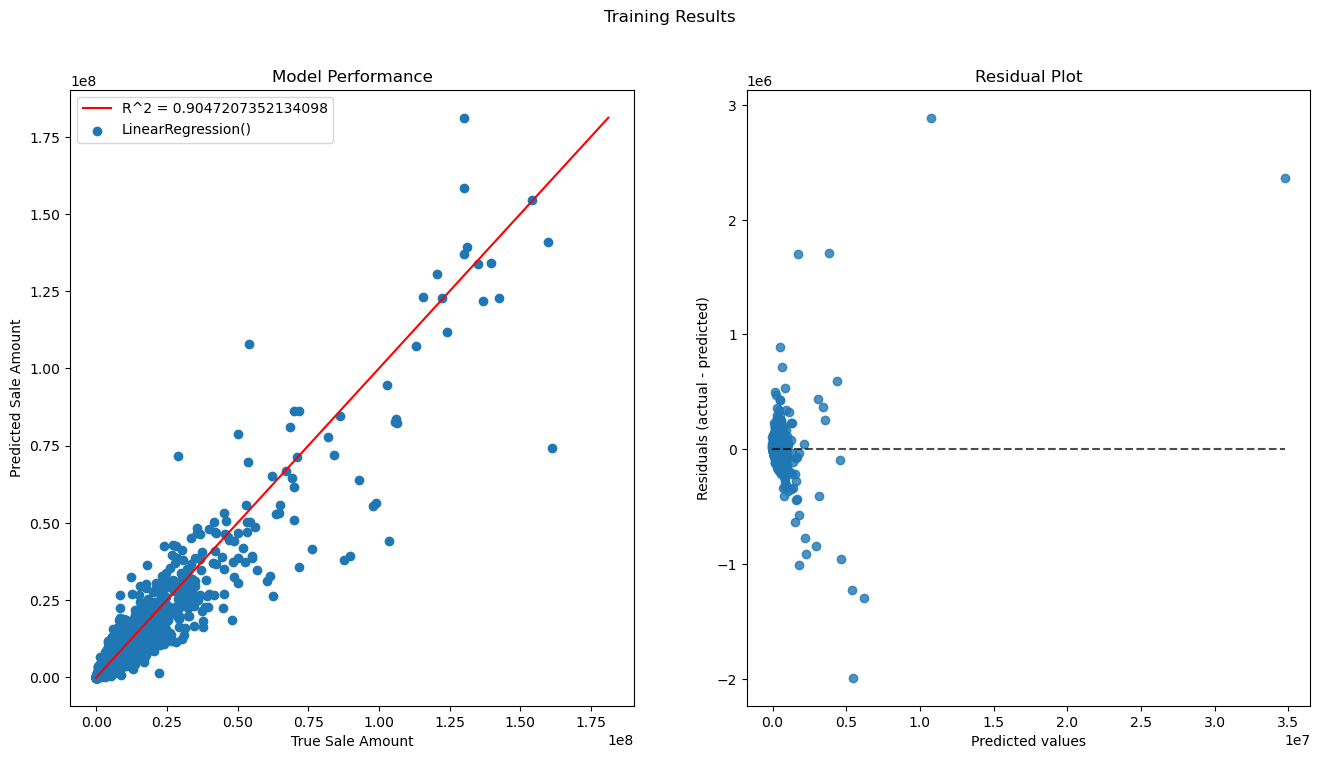

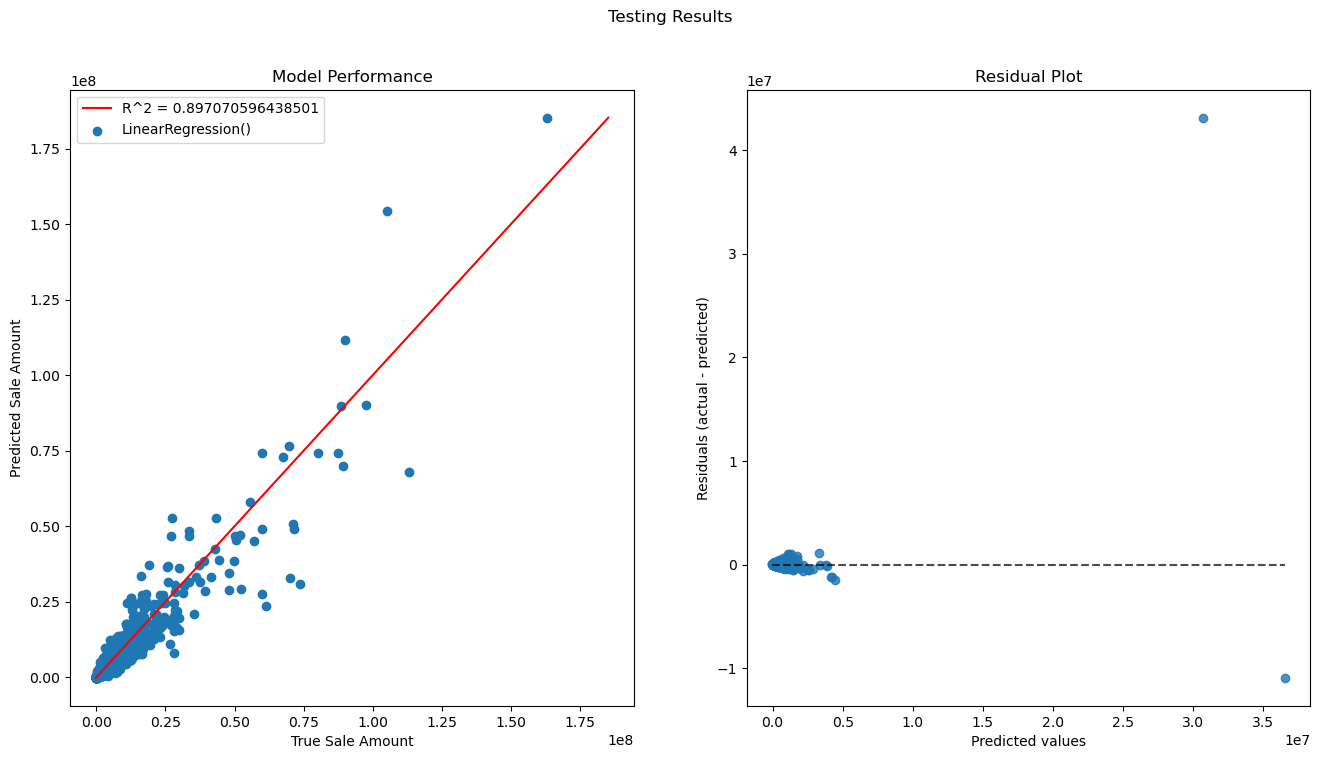

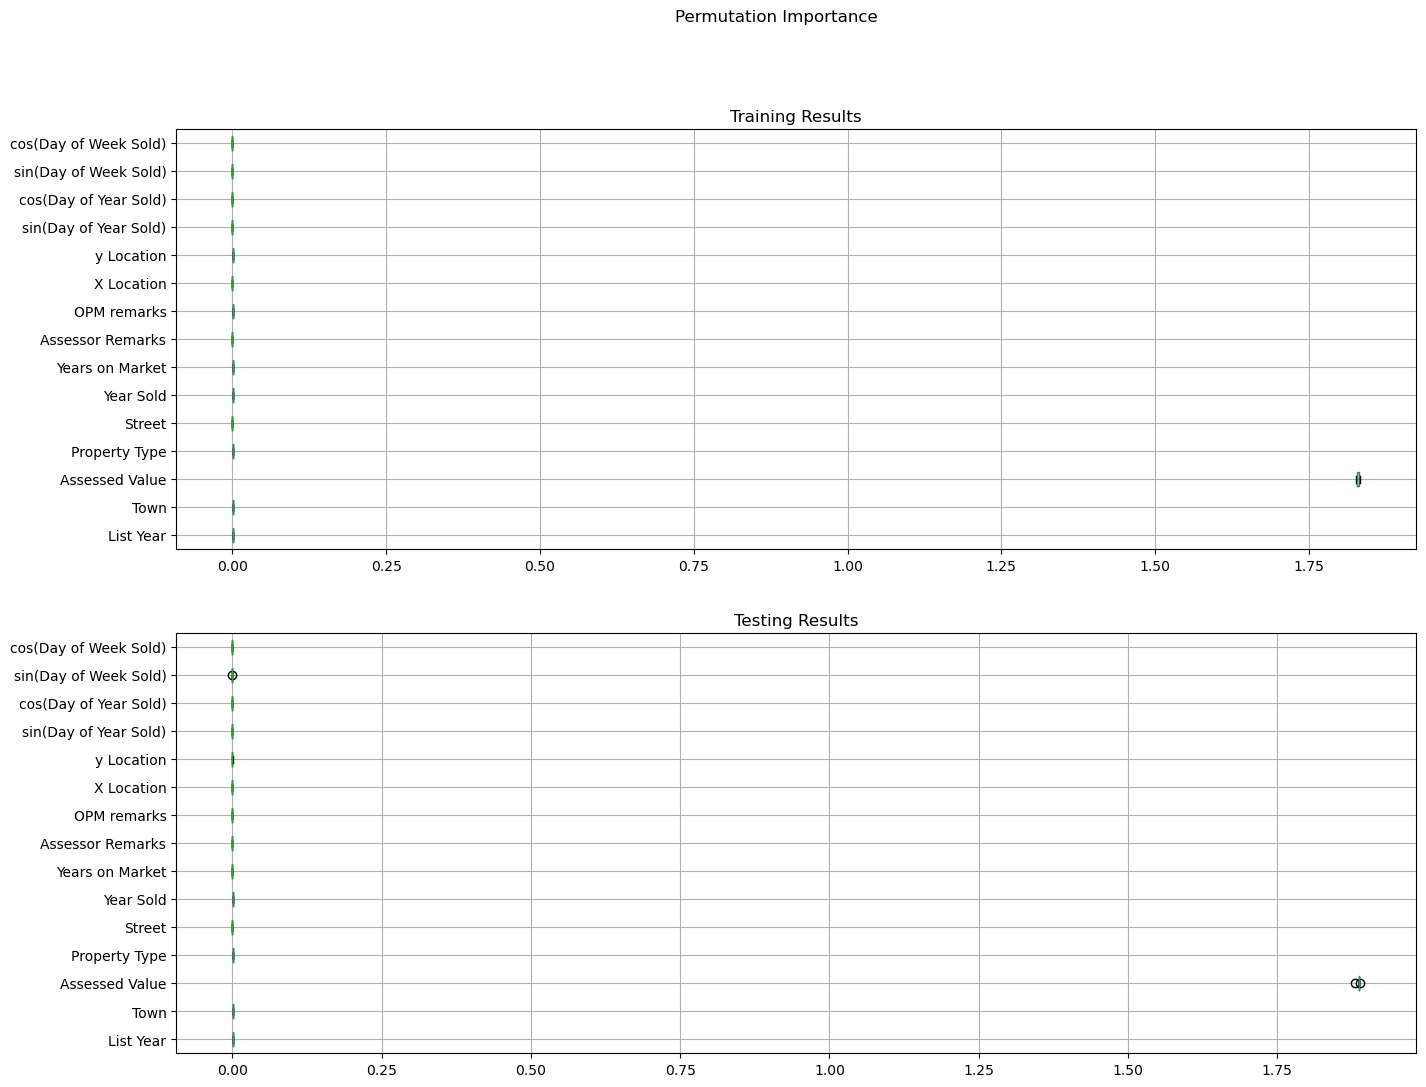

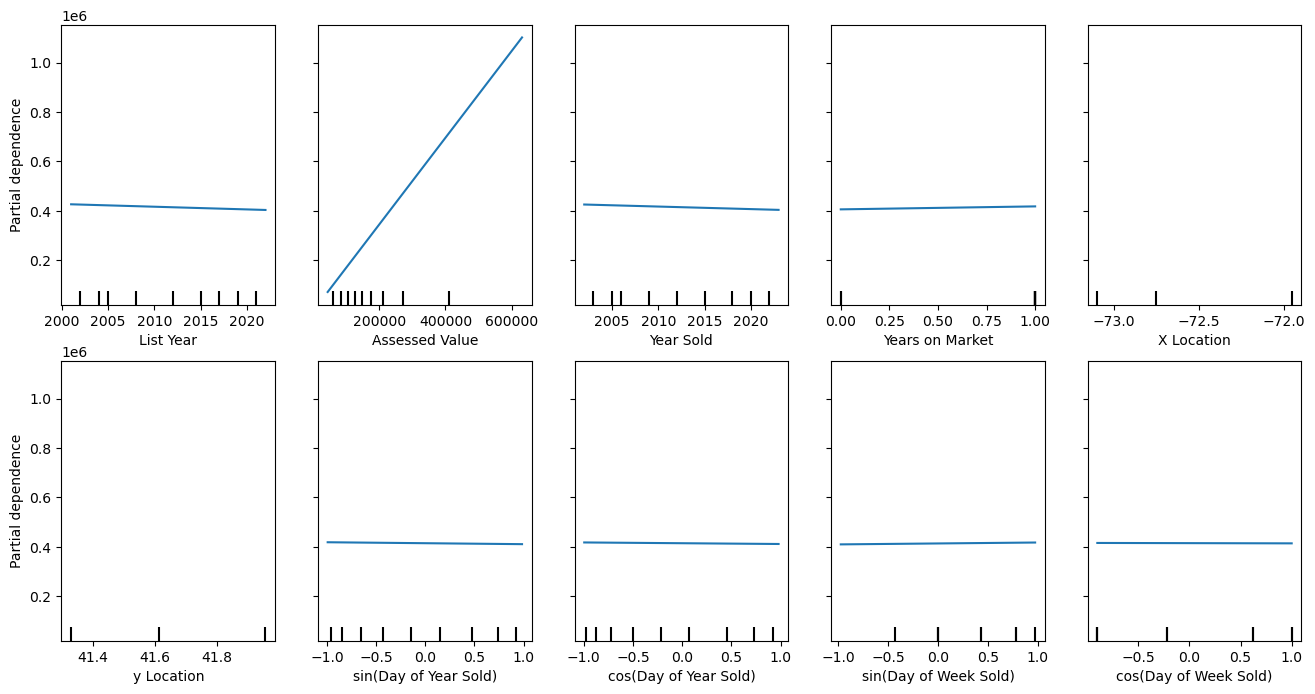

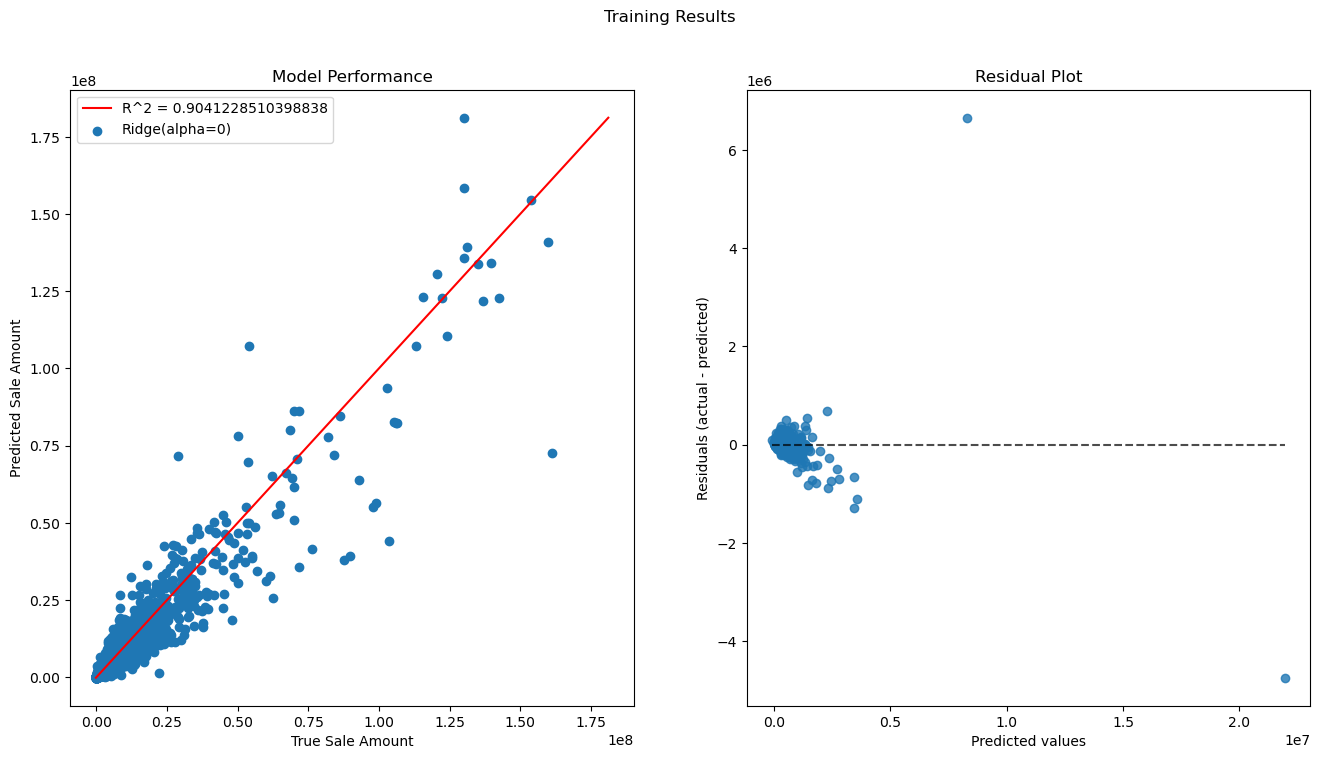

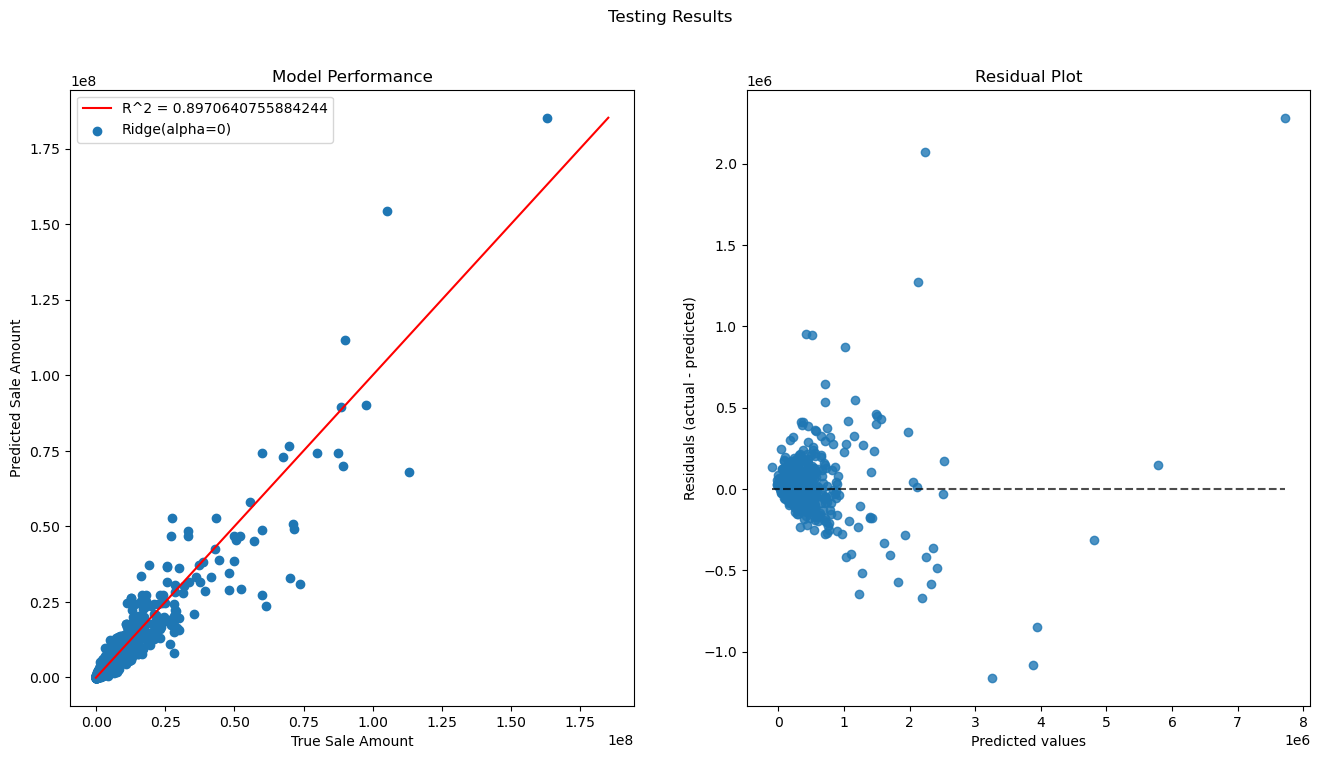

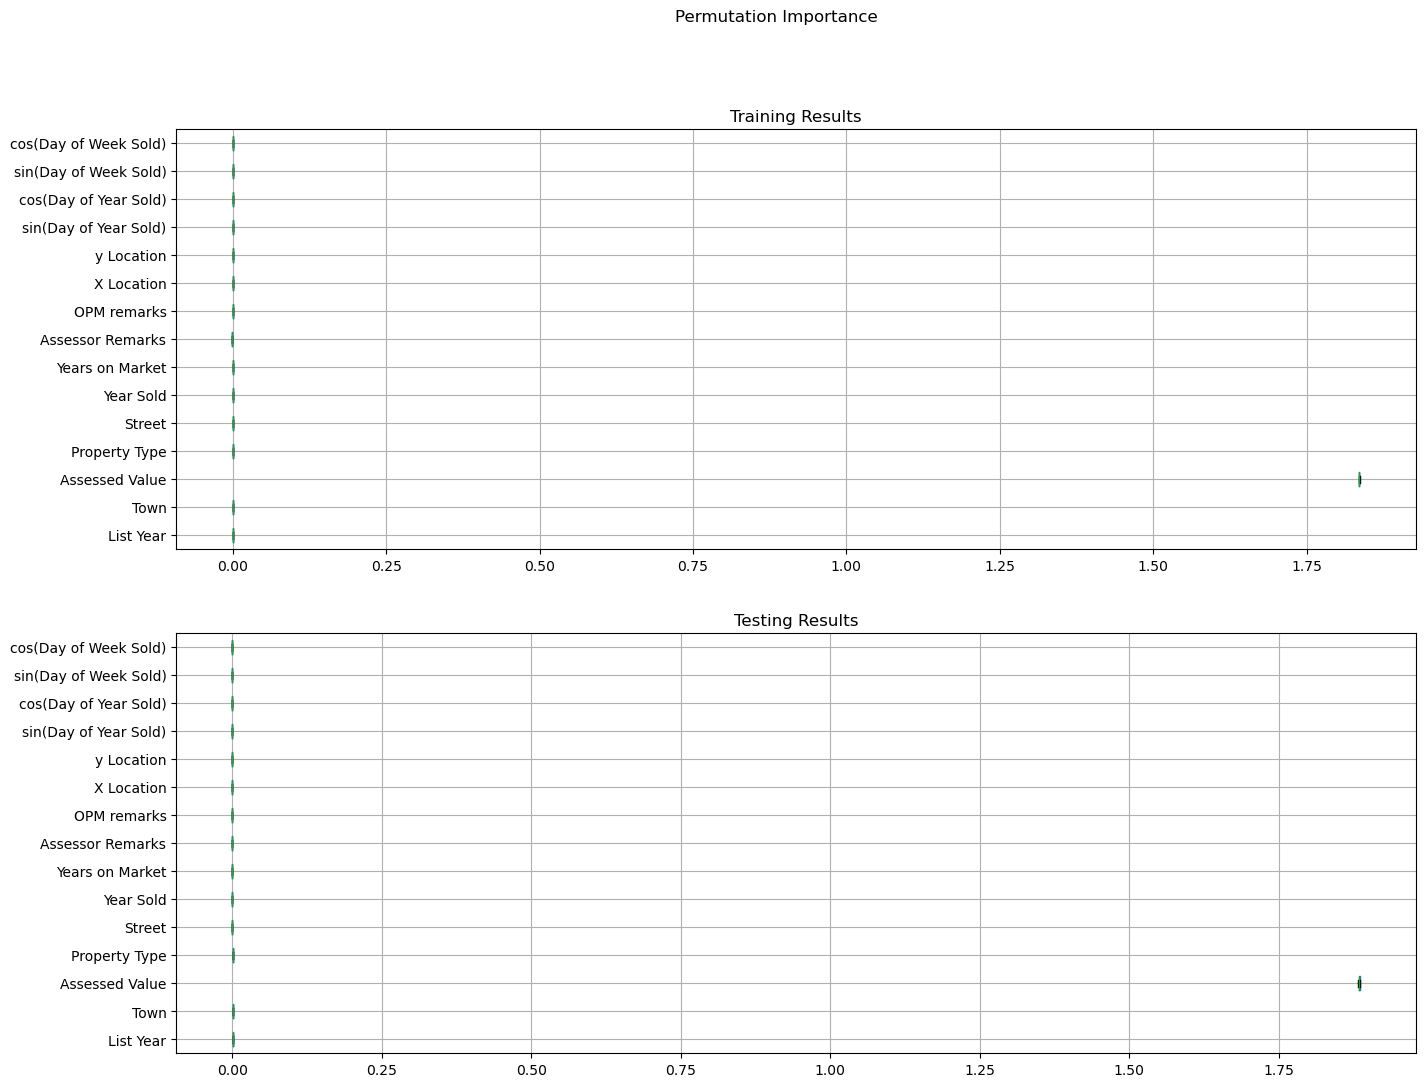

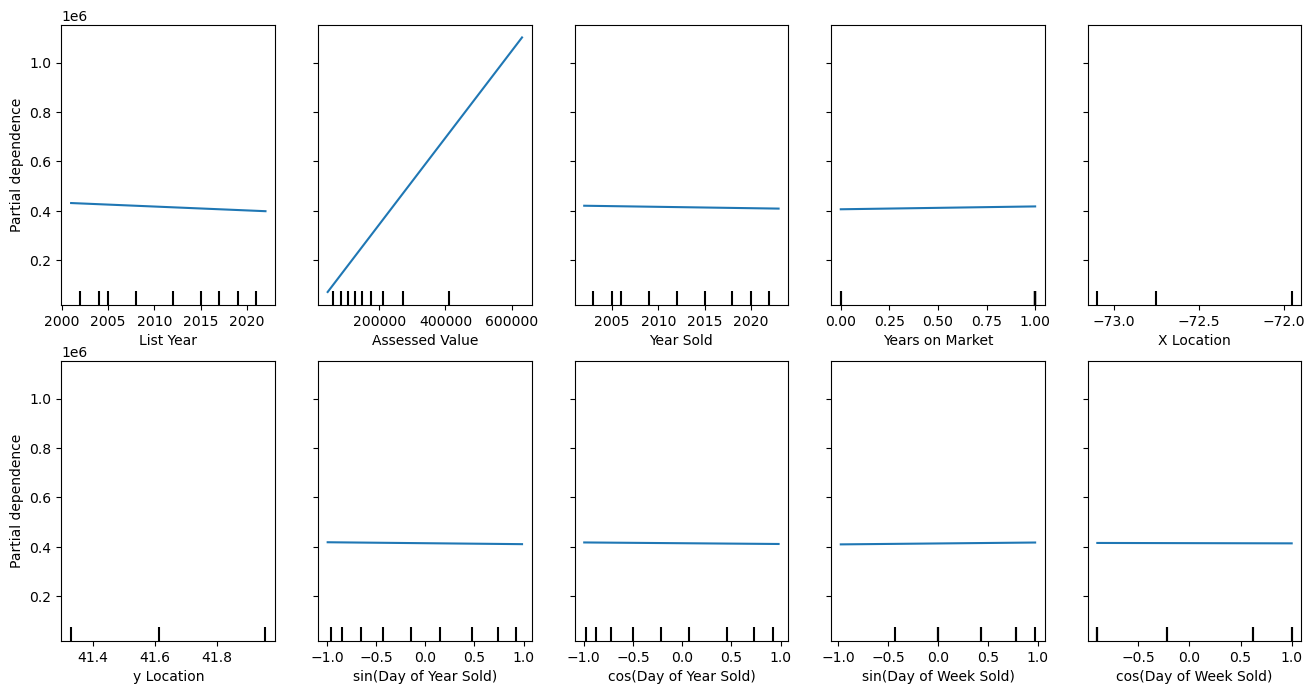

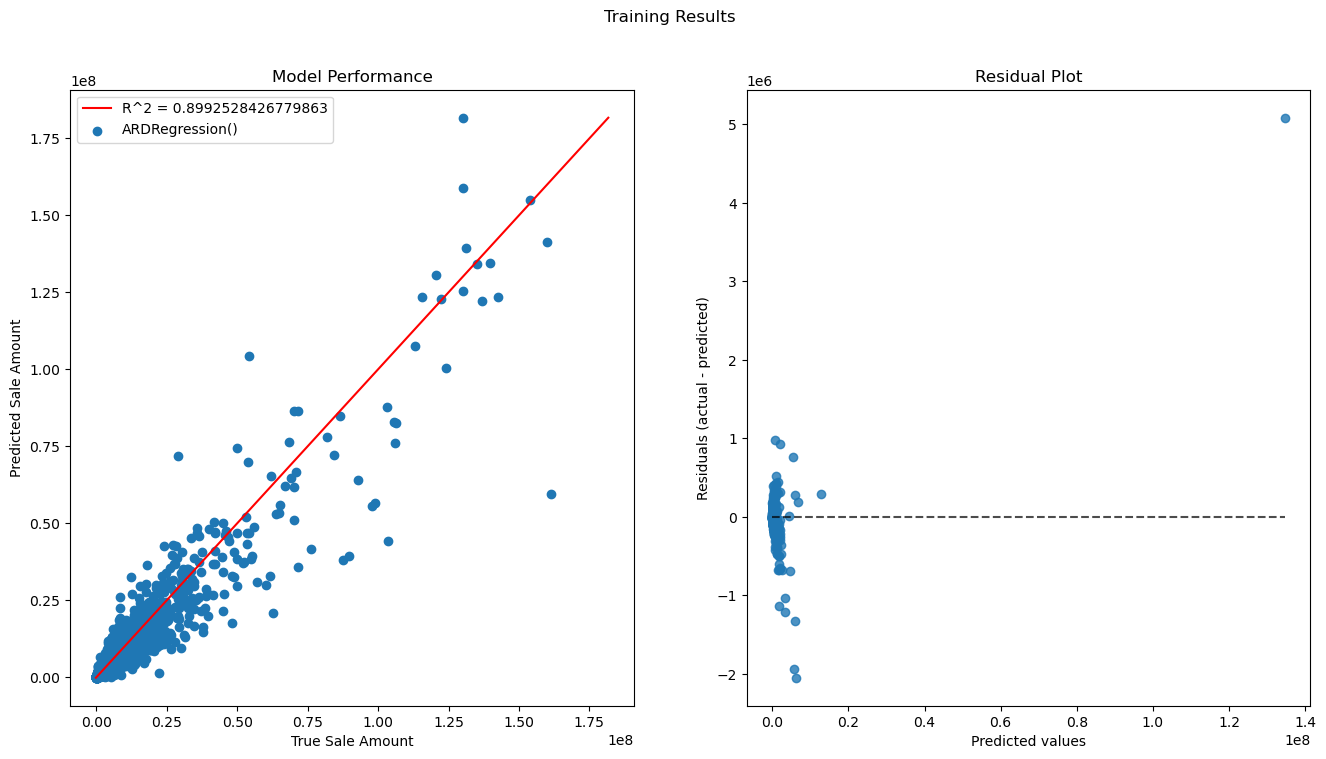

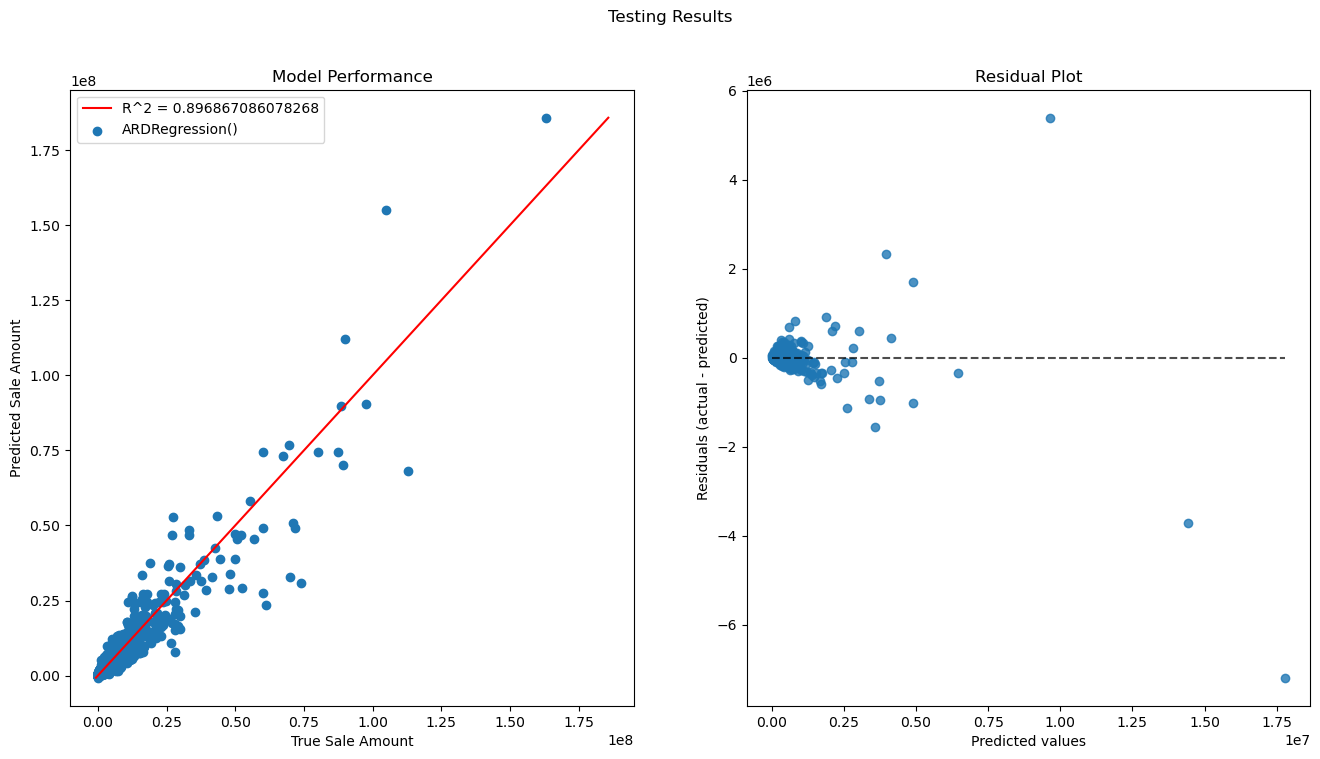

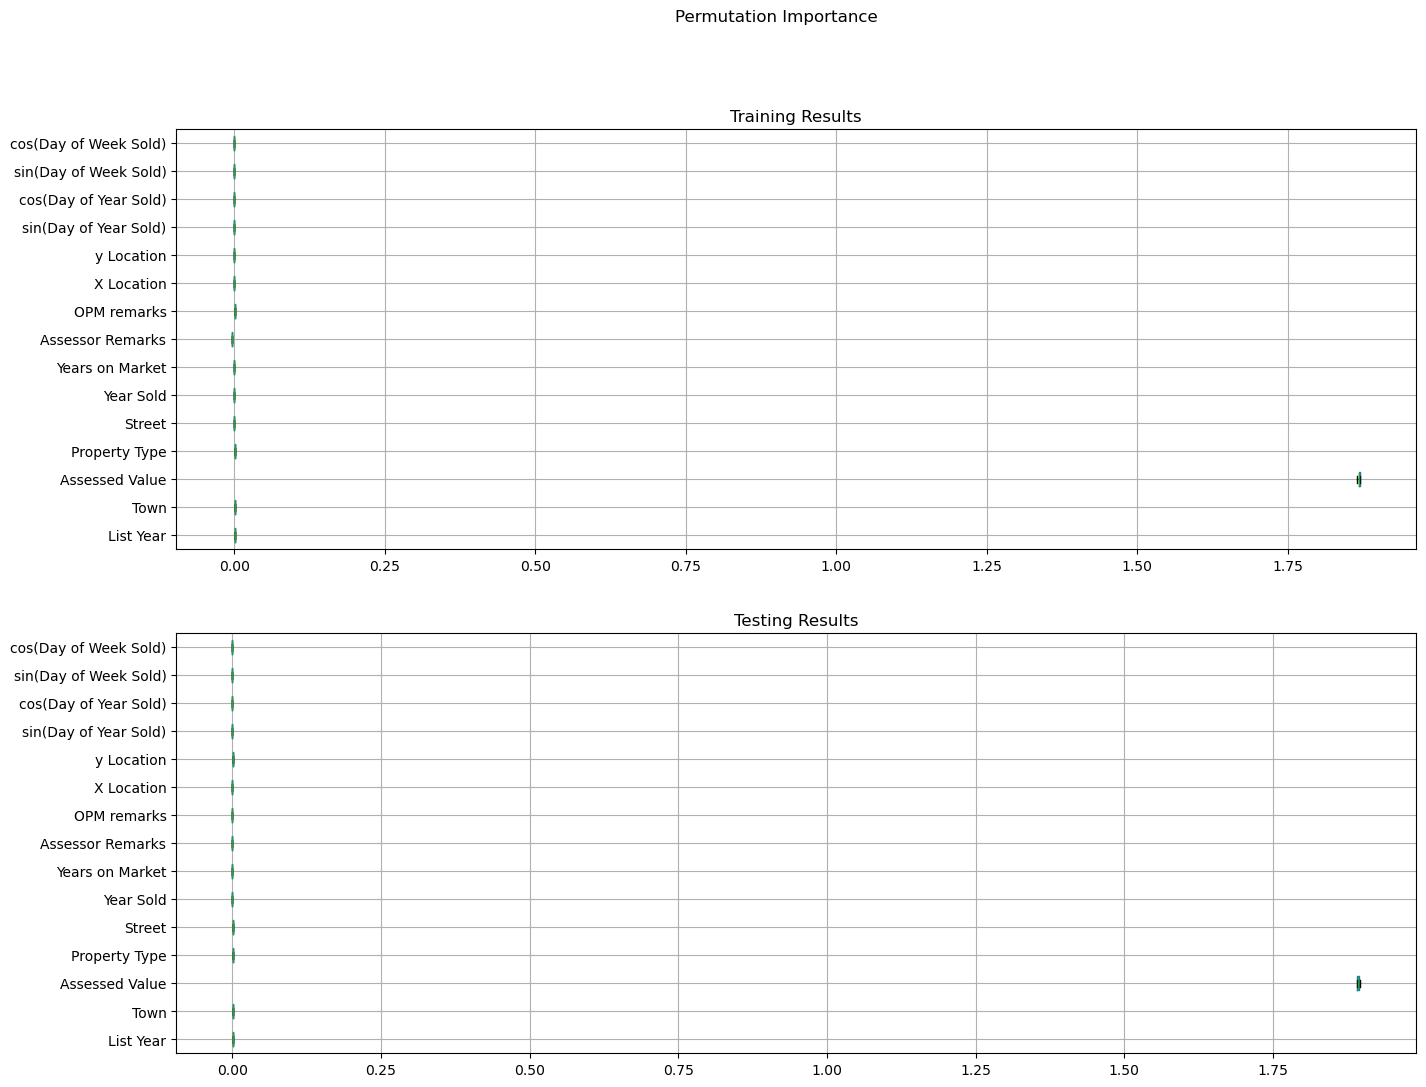

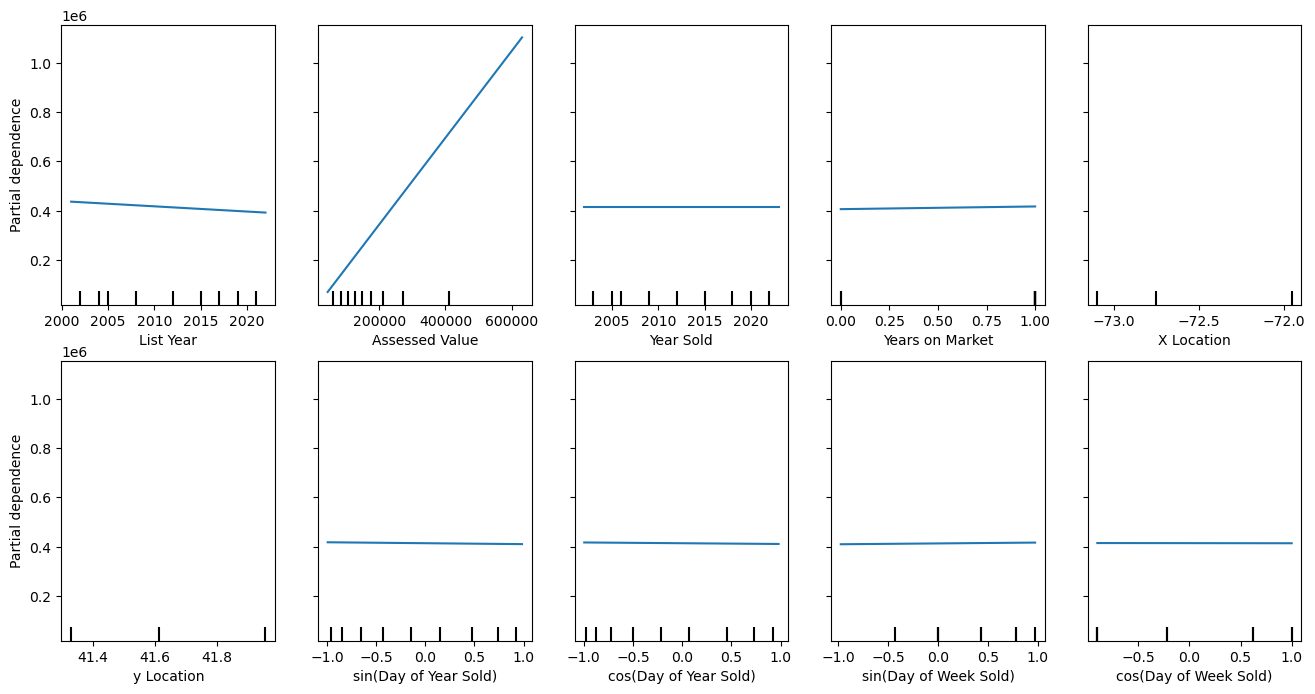

In [39]:

x_features = [
    'List Year',
    'Town',
    'Assessed Value',
    'Property Type',
    'Street',
    'Year Sold',
    'Years on Market',
    'Assessor Remarks',
    'OPM remarks',
    'X Location',
    'y Location',
    'sin(Day of Year Sold)',
    'cos(Day of Year Sold)',
    'sin(Day of Week Sold)',
    'cos(Day of Week Sold)',
]


y_feature = 'Sale Amount'

estimators = make_estimators('linear')

for estimator in estimators:
    predict_and_plot(X_train, X_test, y_train, y_test, x_features, y_feature, estimator)


## Control: Predicting Sale Amount With only Assessed Value

This experiment predicts `Sale Amount` using only `Assessed Value` to examine how much variance this single feature explains.

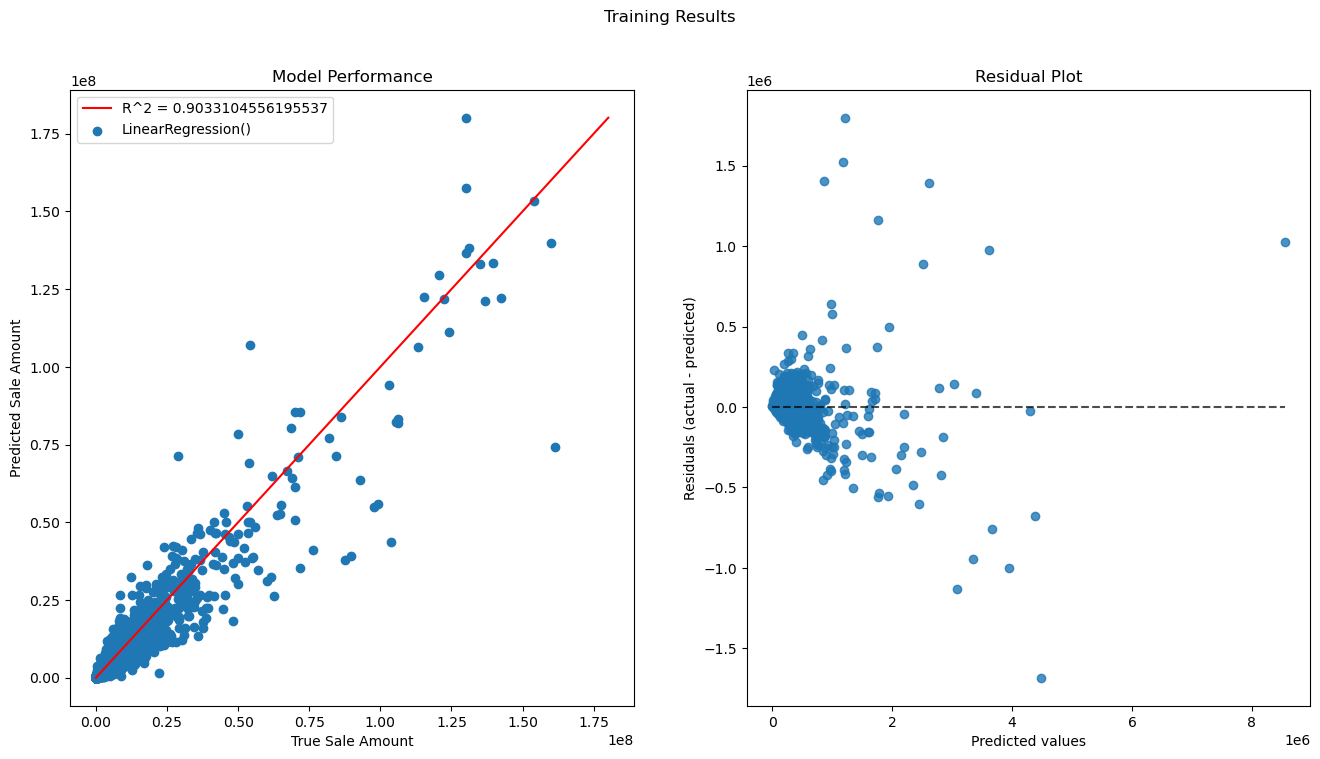

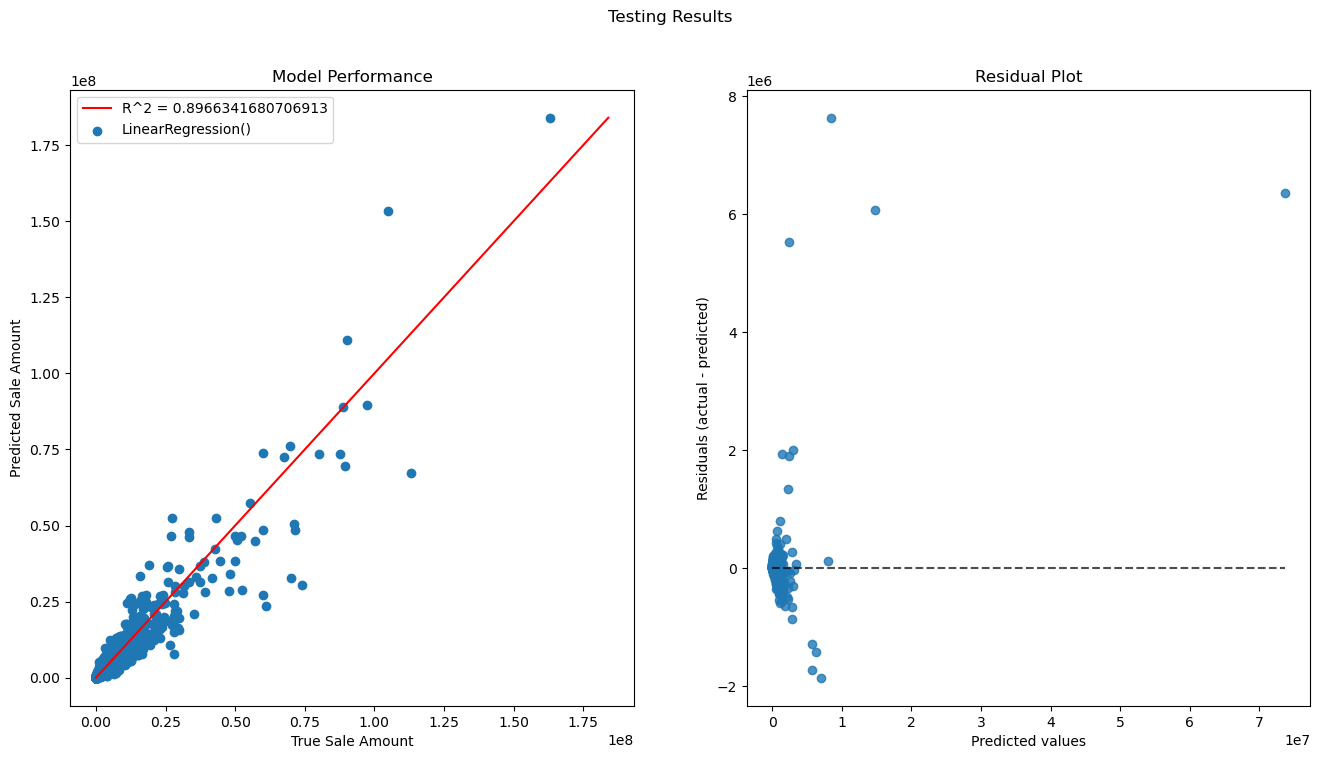

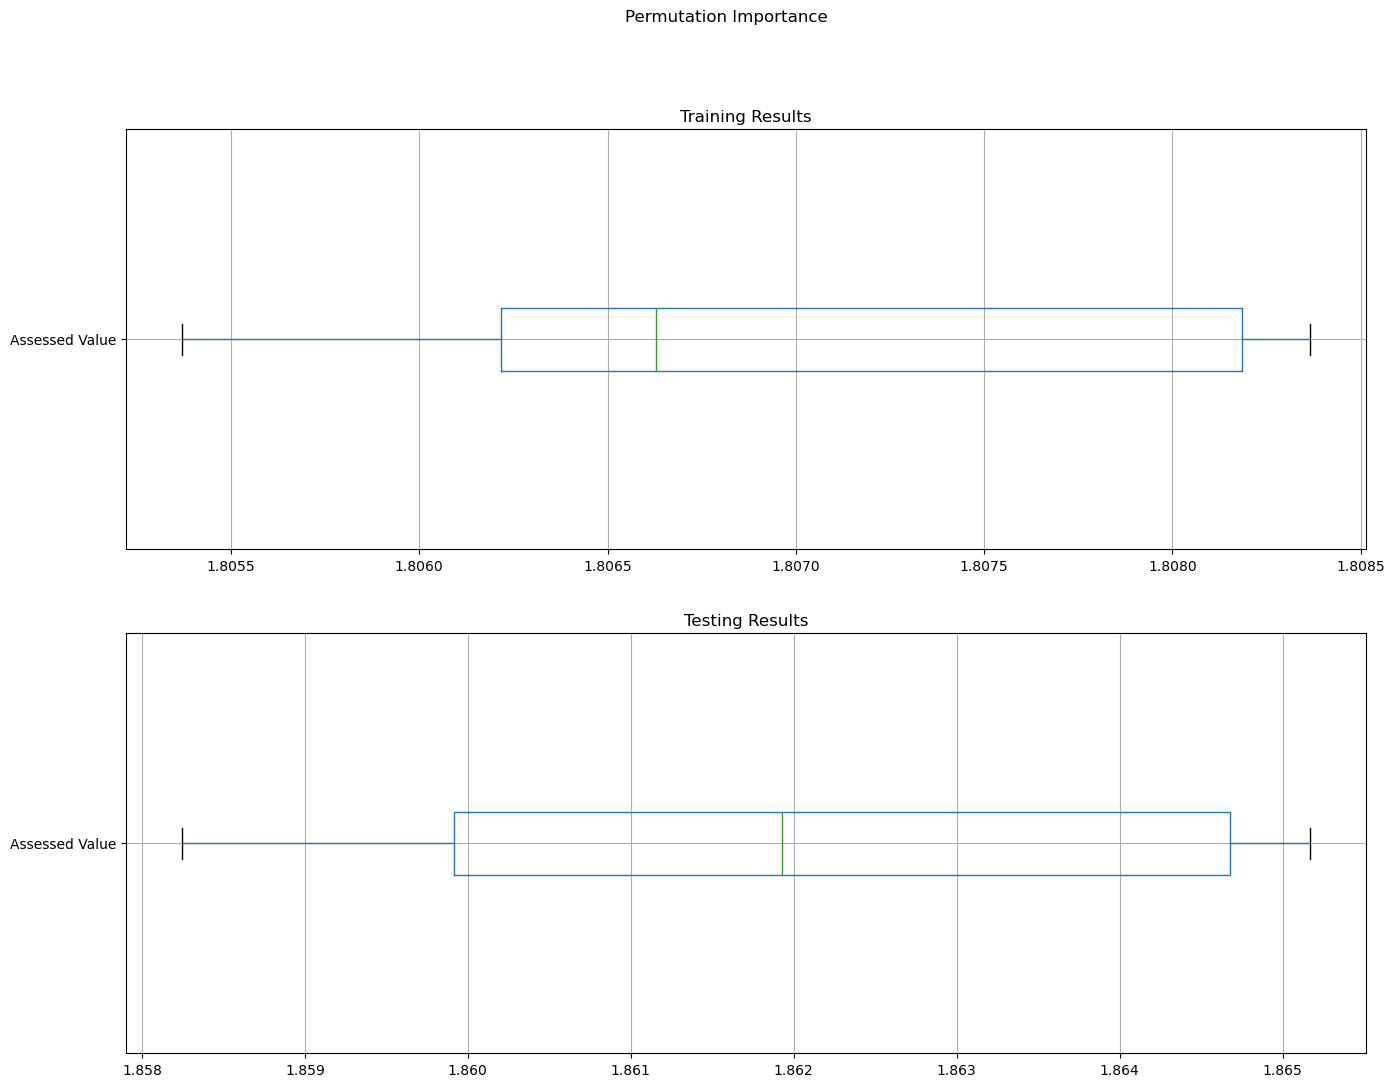

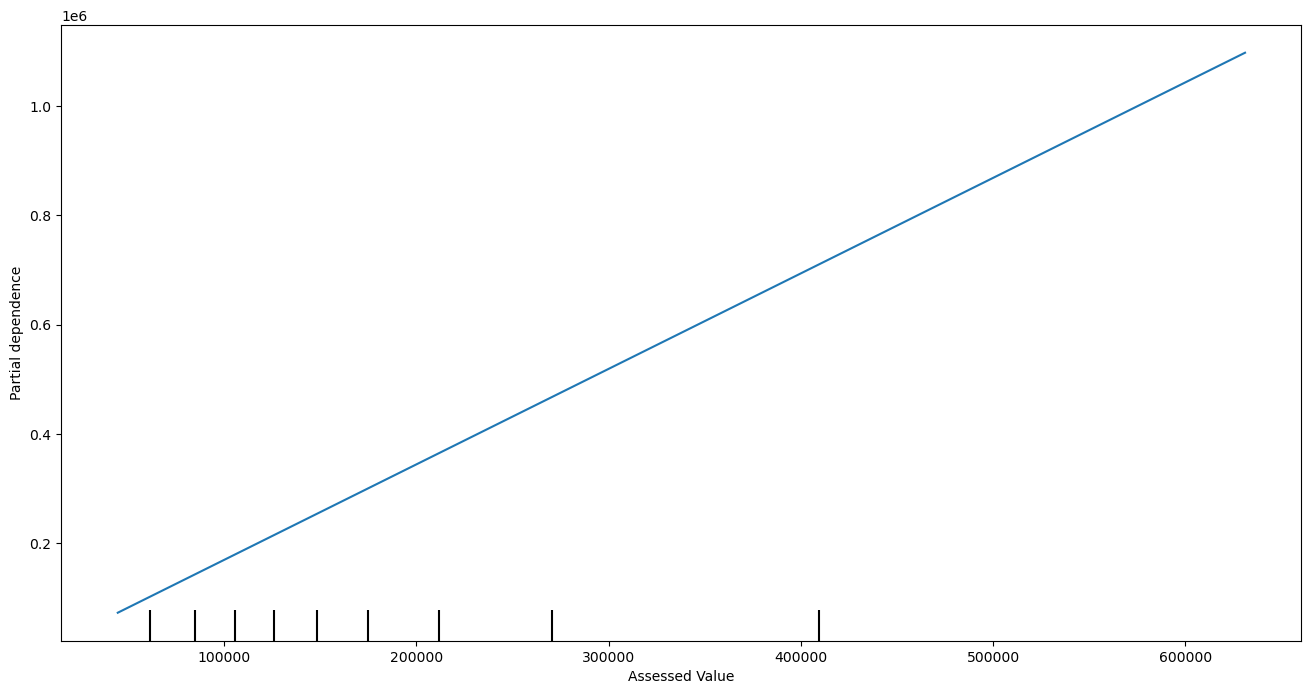

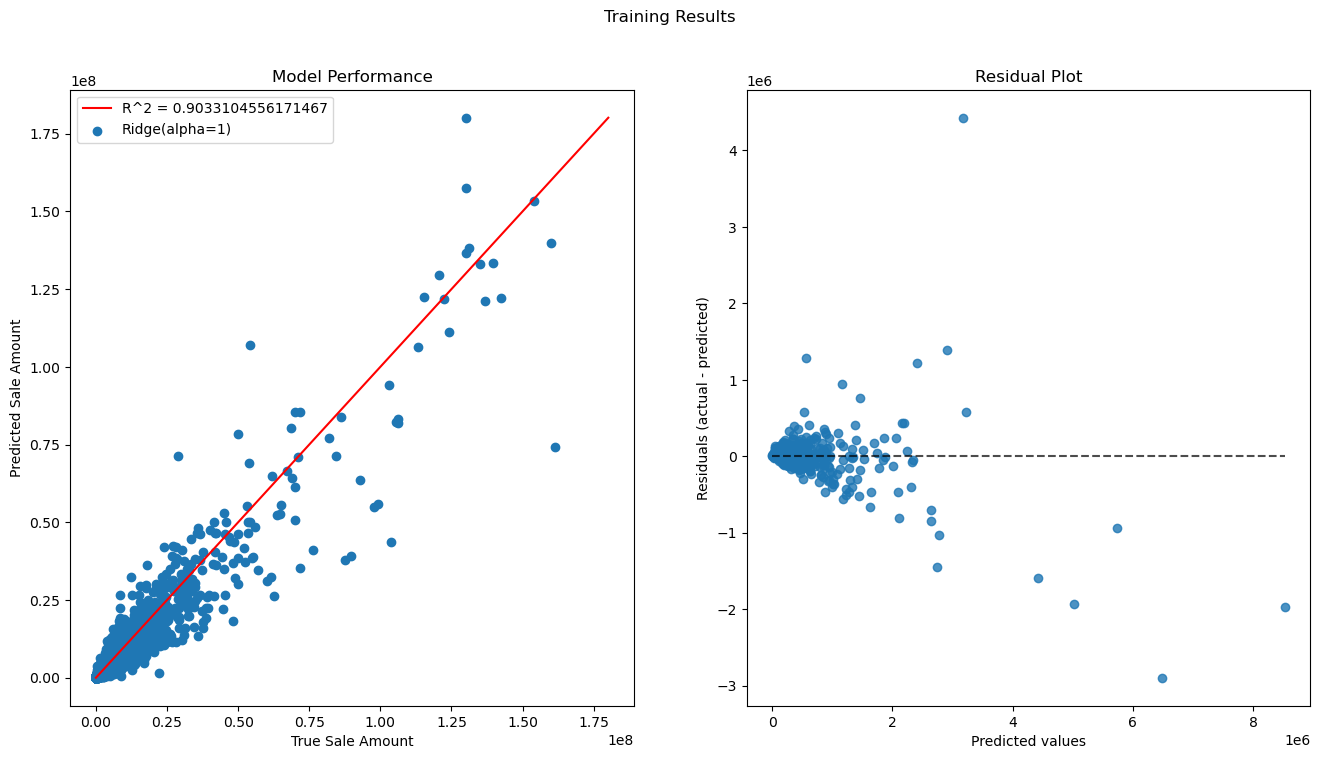

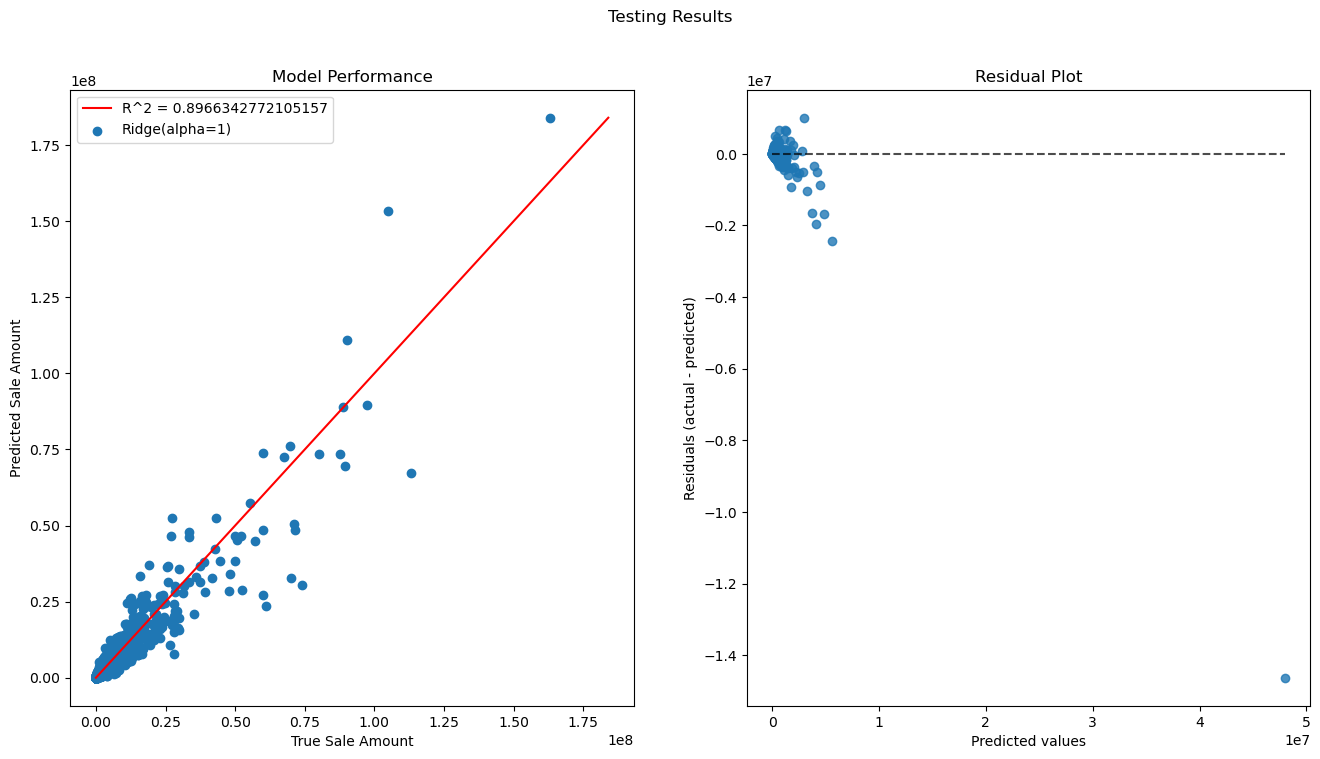

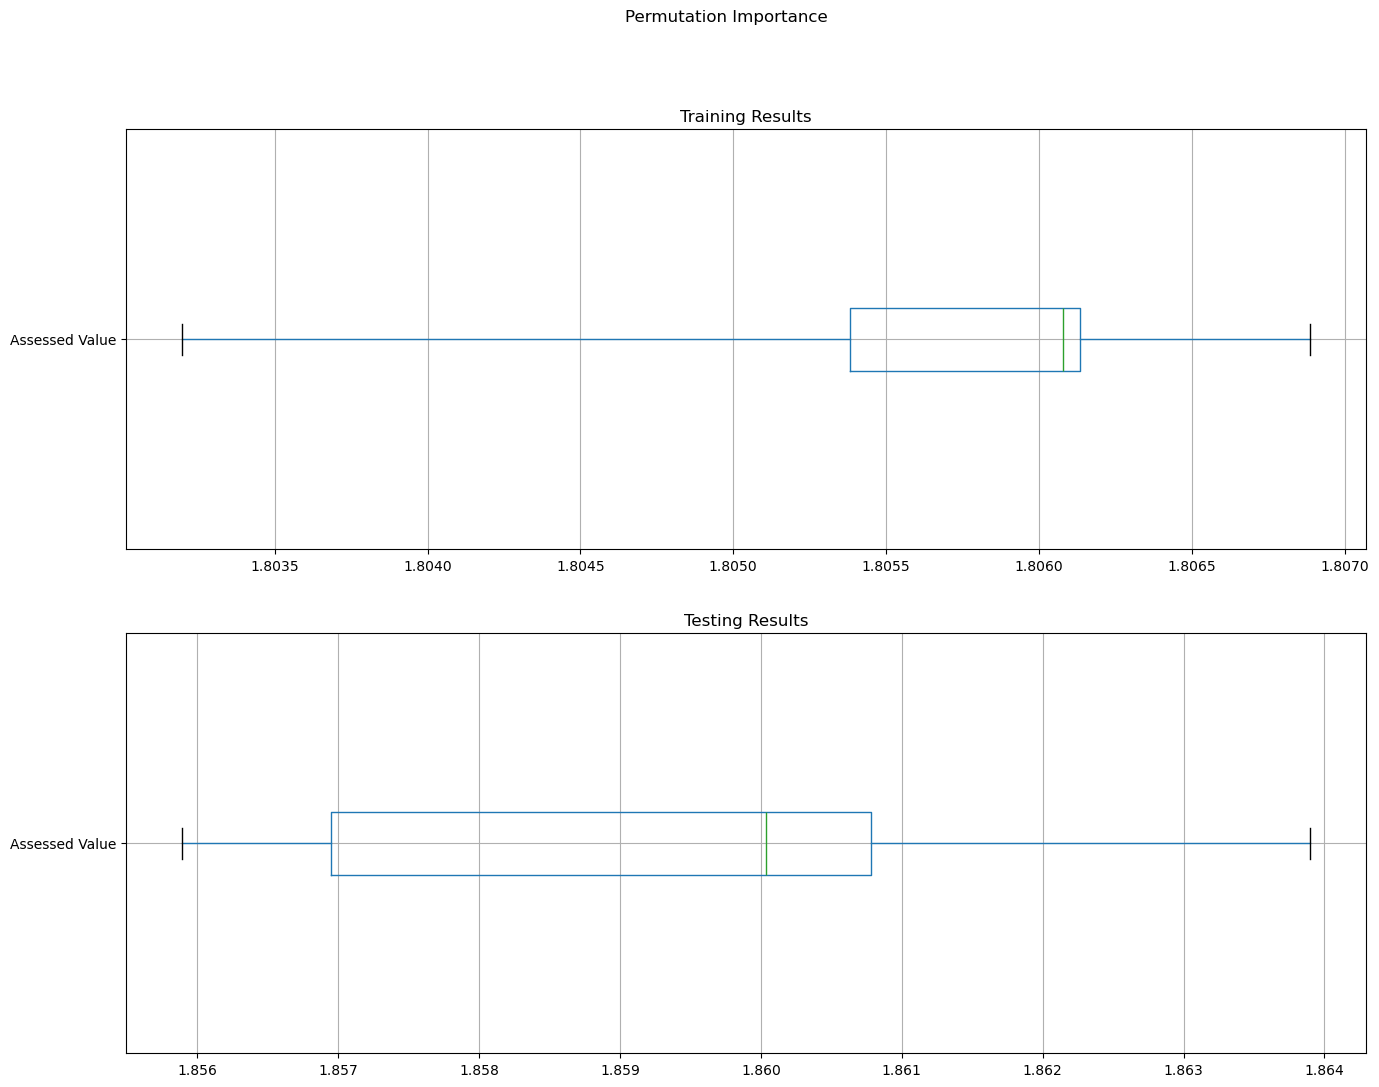

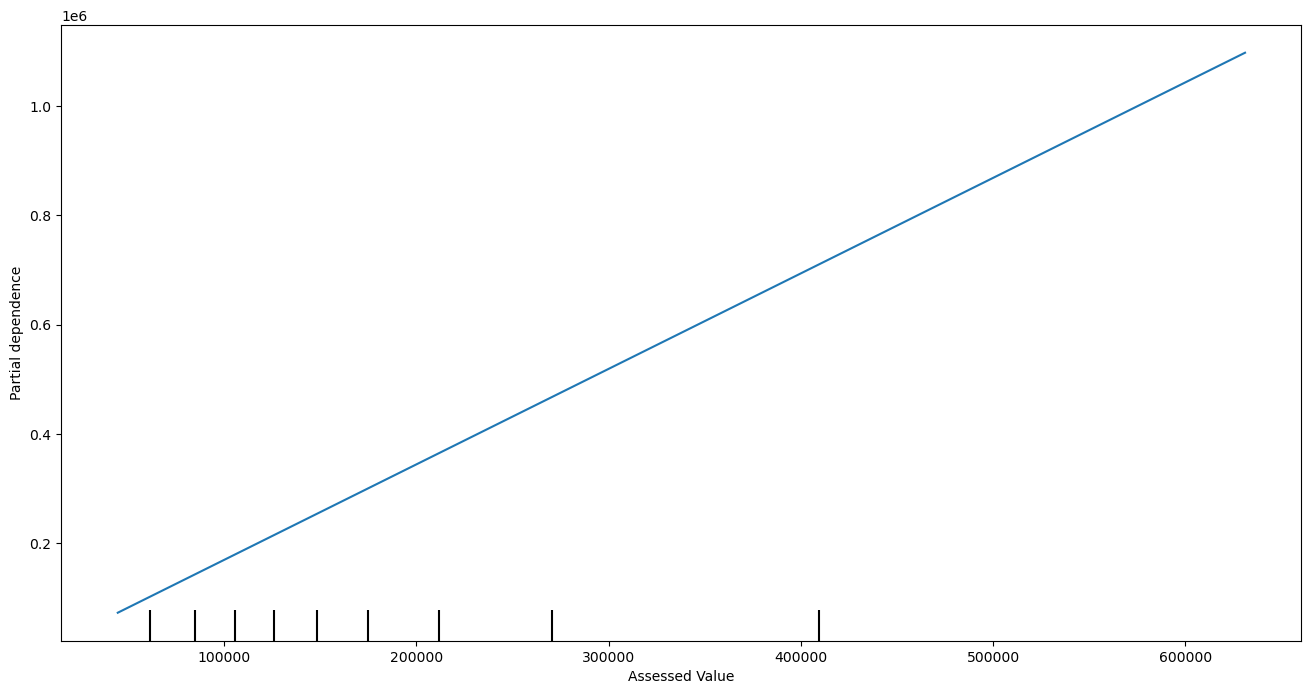

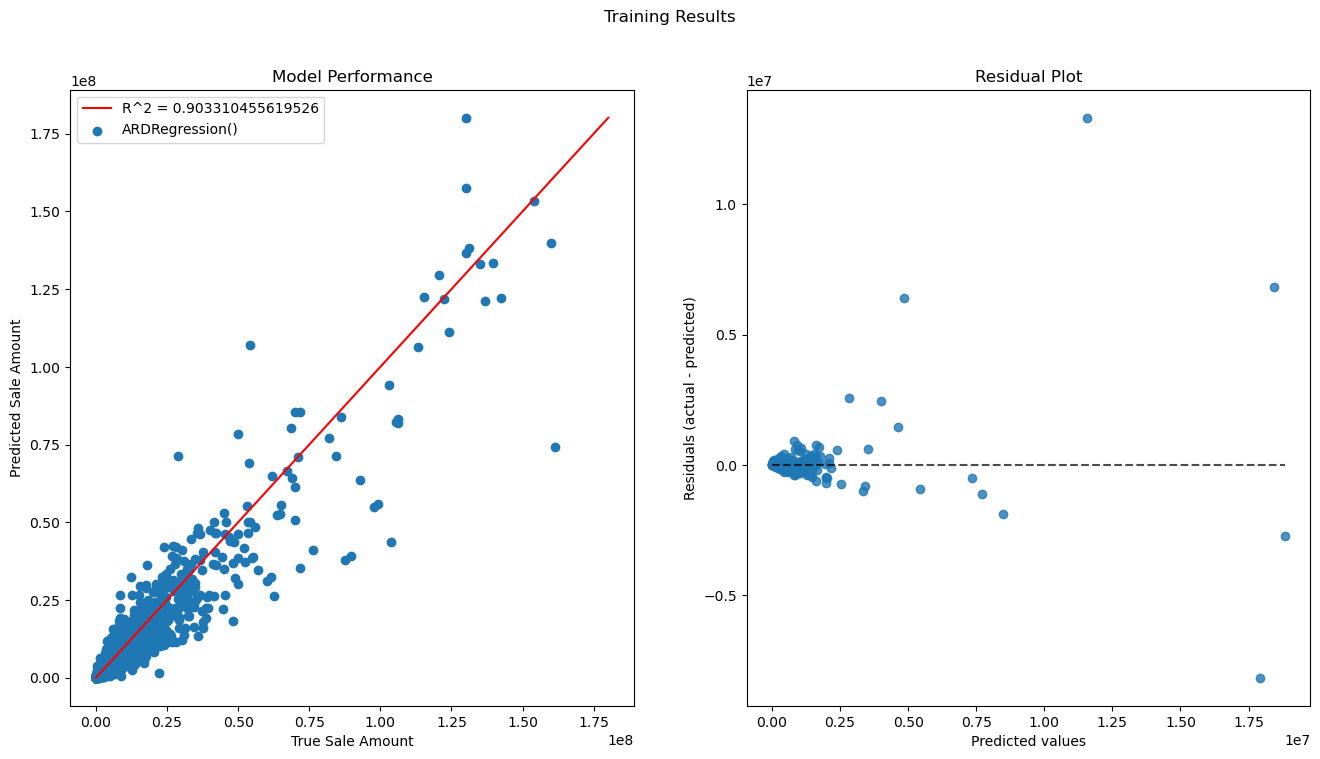

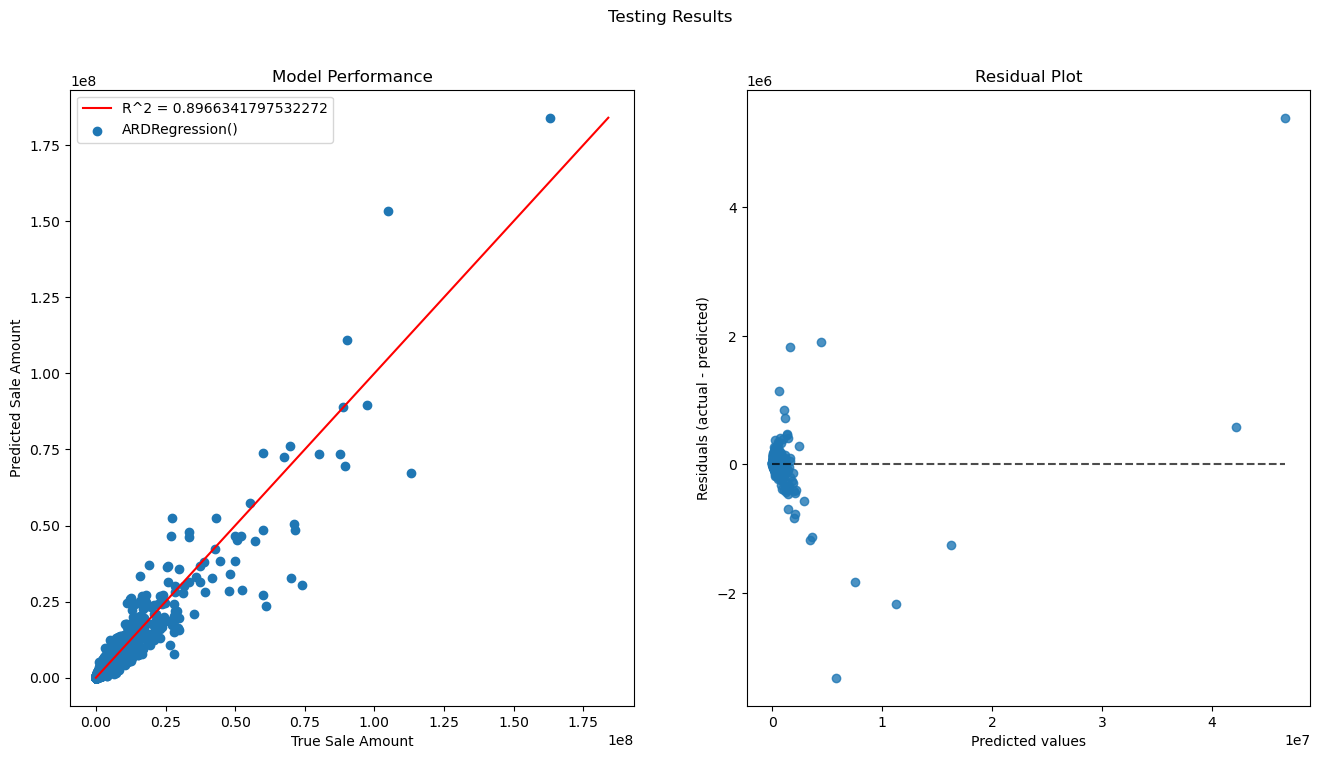

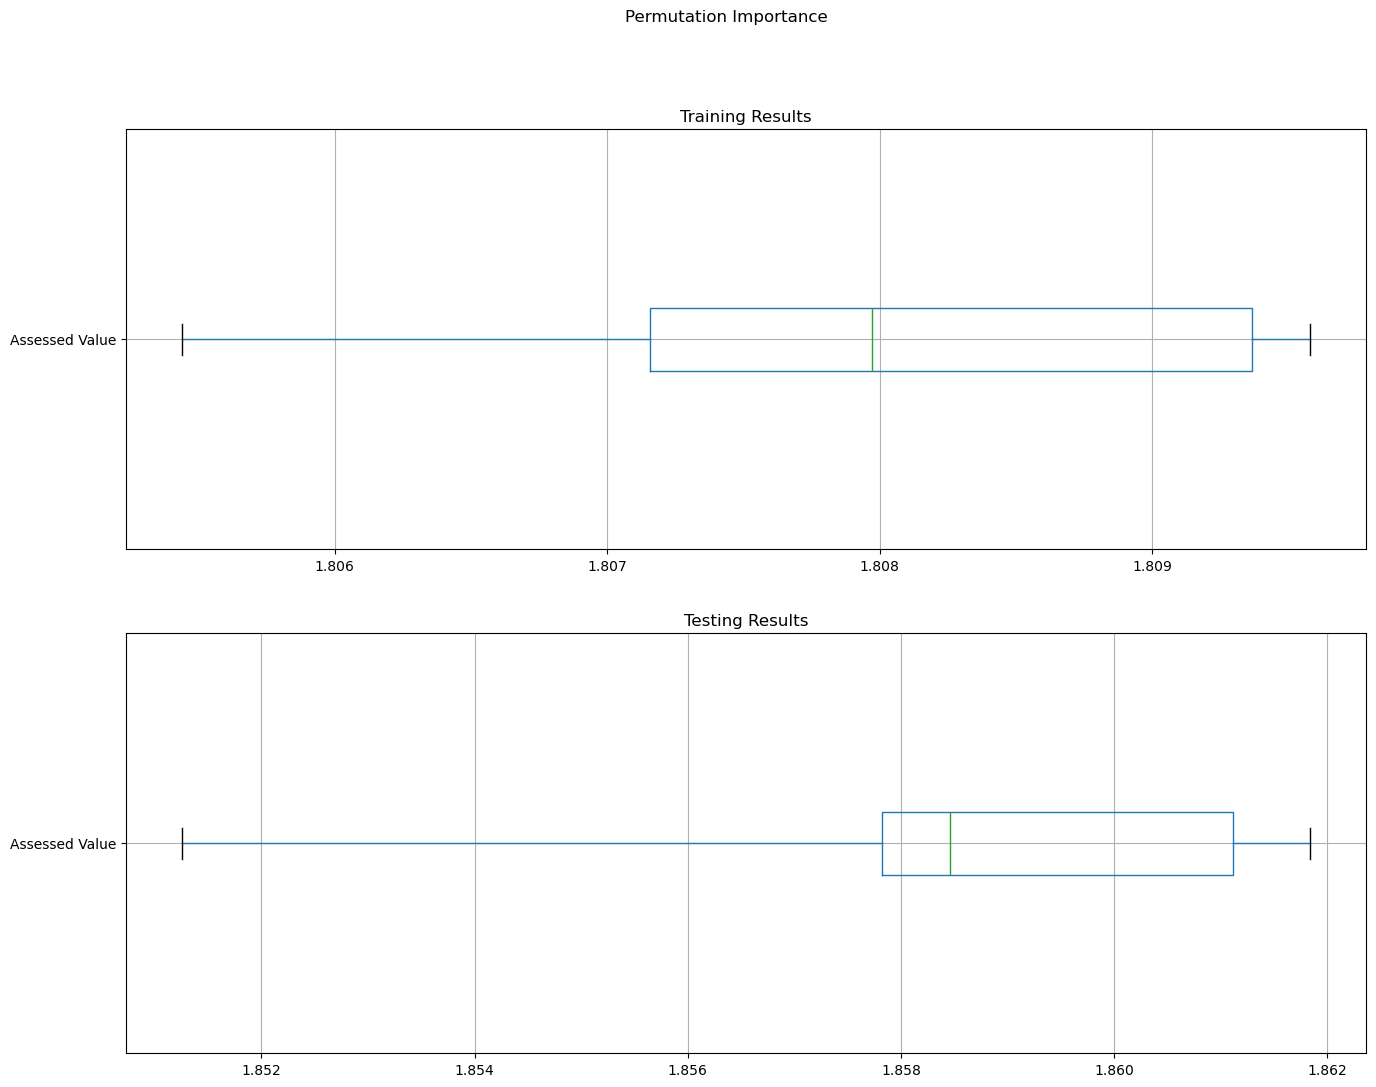

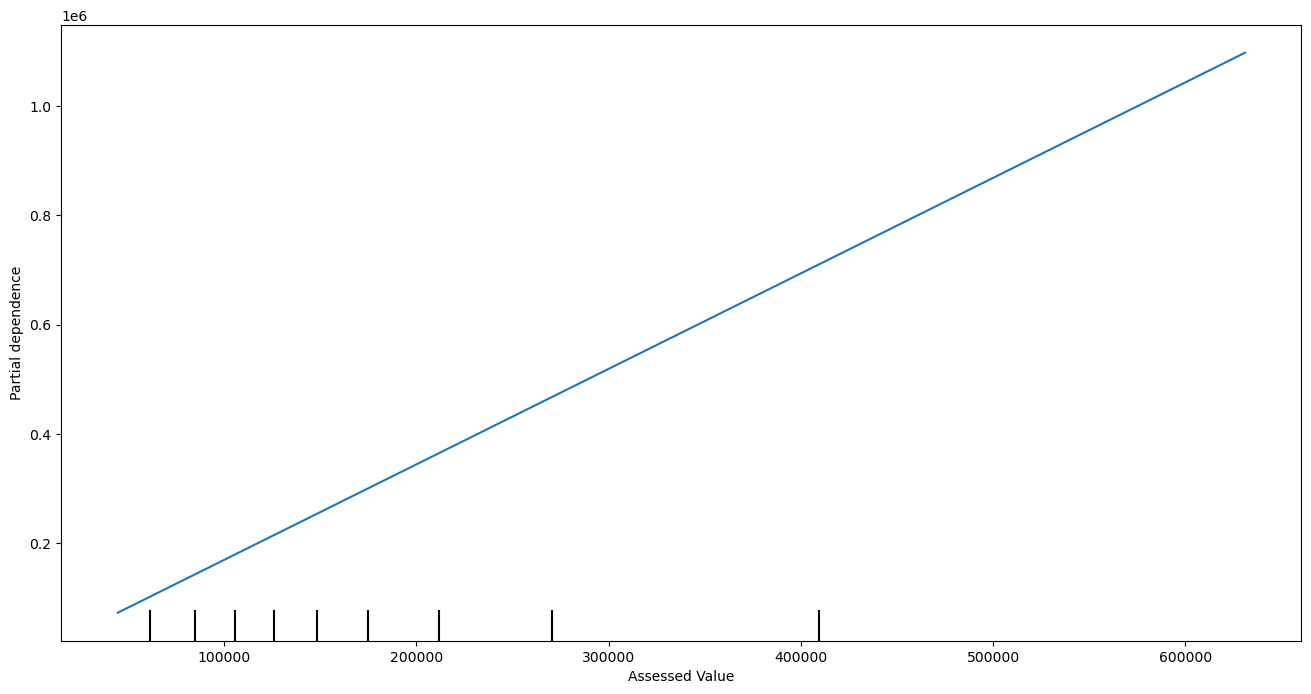

In [40]:

X_features = ['Assessed Value']
y_feature = 'Sale Amount'
estimators = make_estimators('linear')

for estimator in estimators:
    predict_and_plot(X_train, X_test, y_train, y_test, X_features, y_feature, estimator)


## Predicting Sale Amount Without Assessed Value

This experiment predicts `Sale Amount` using all features but `Assessed Value` to examine how much variance the other features explain.

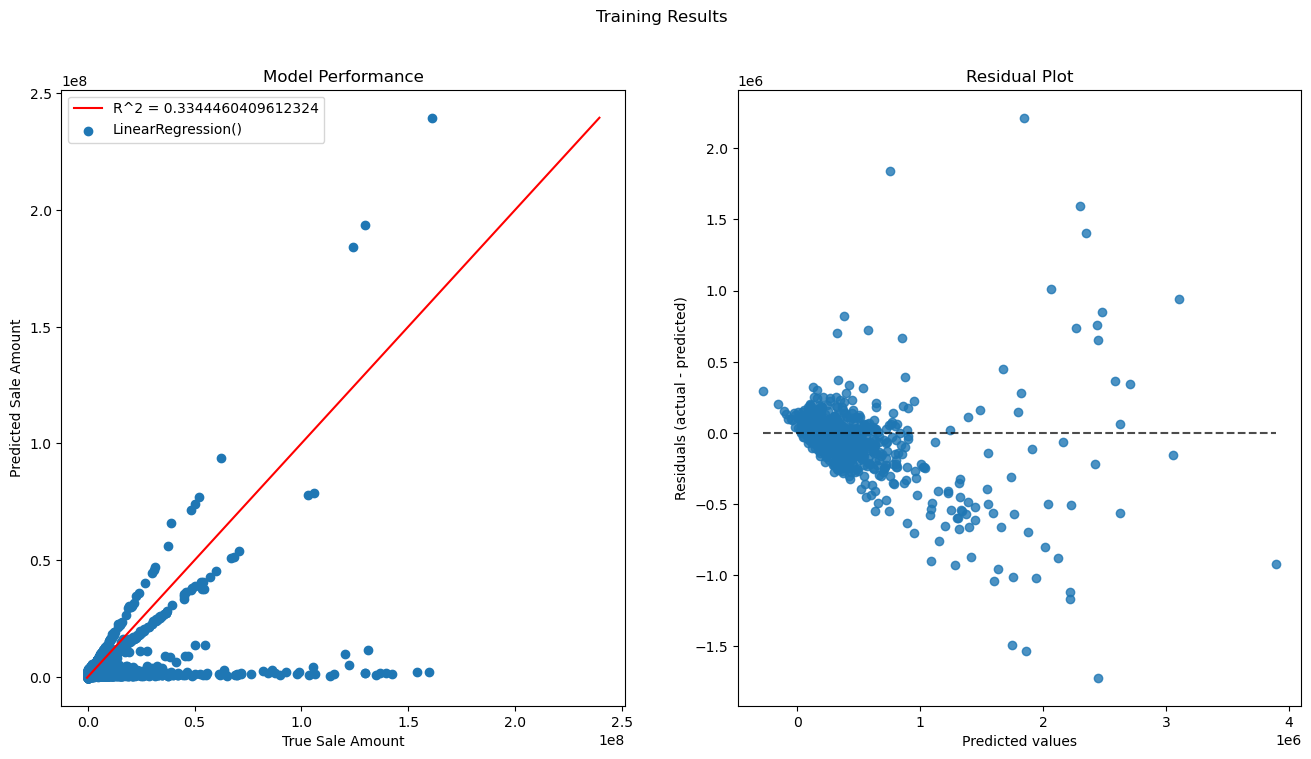

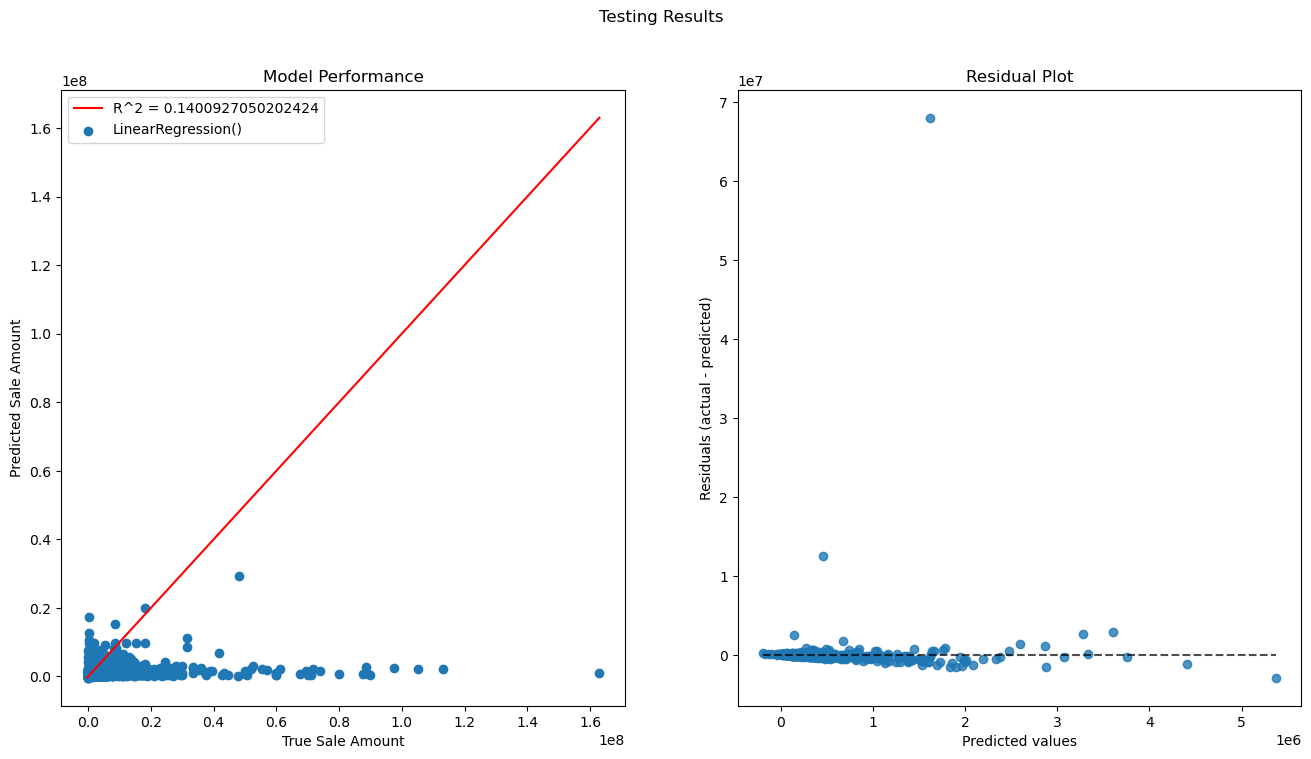

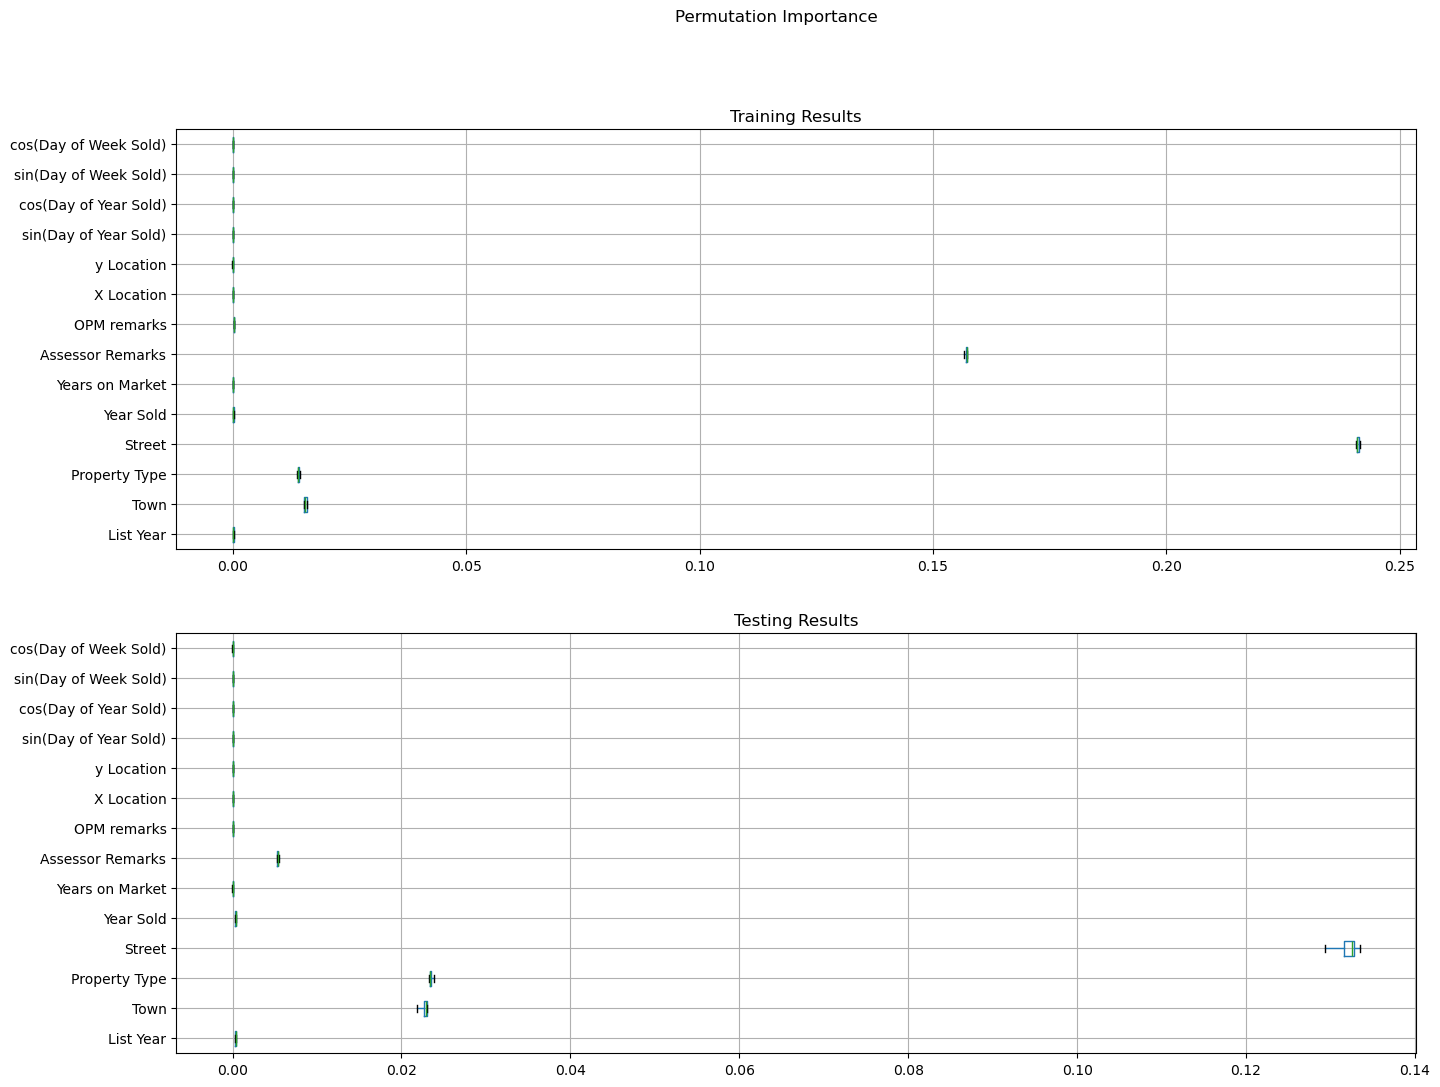

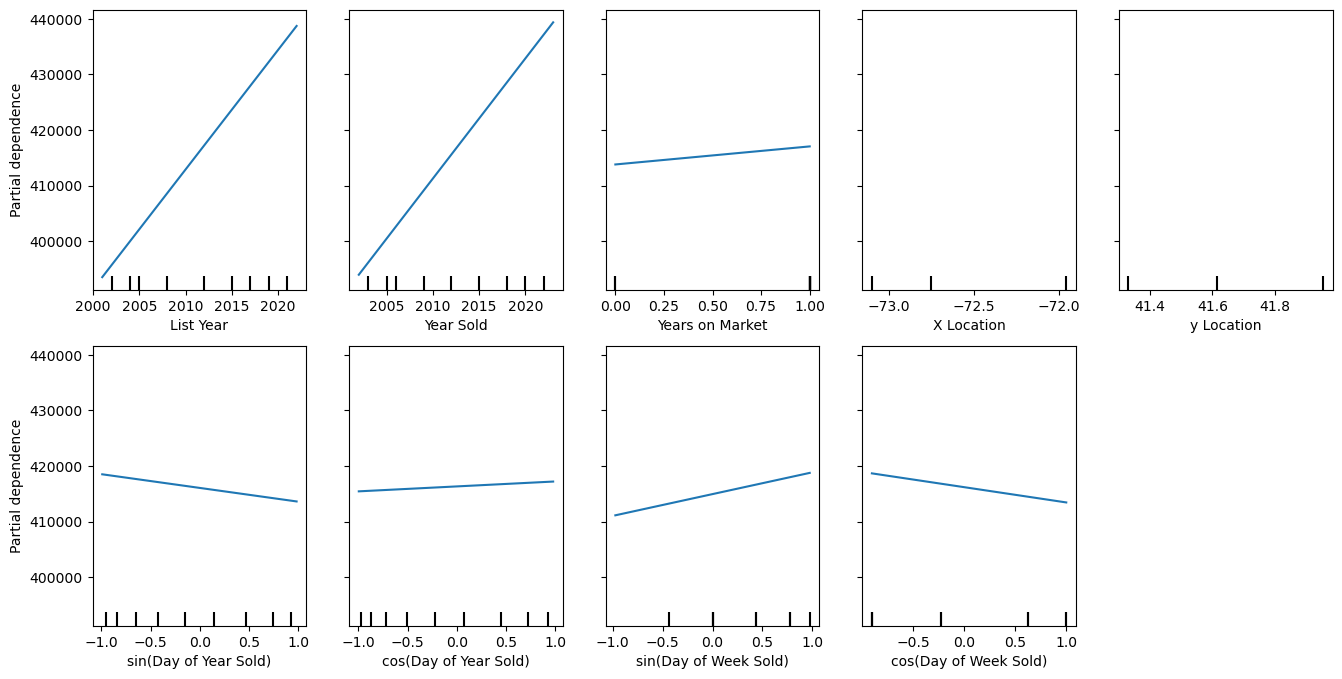

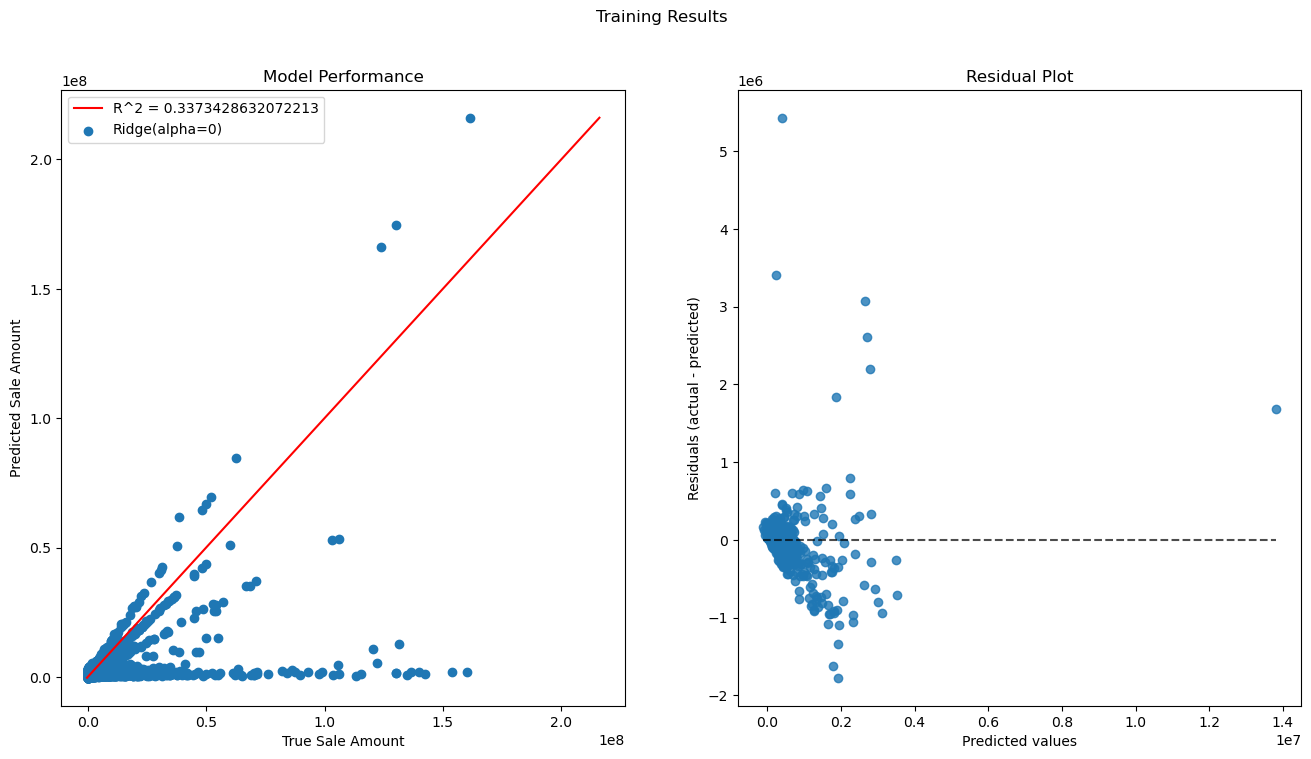

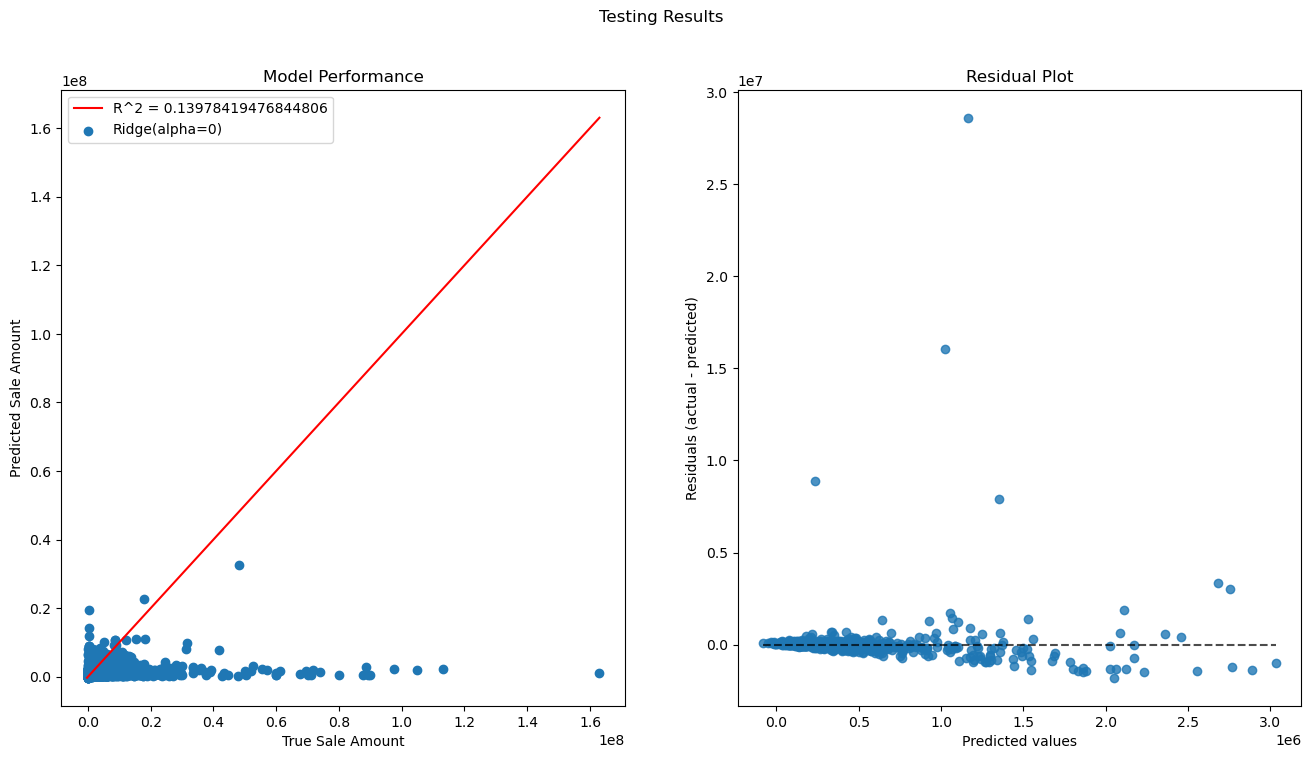

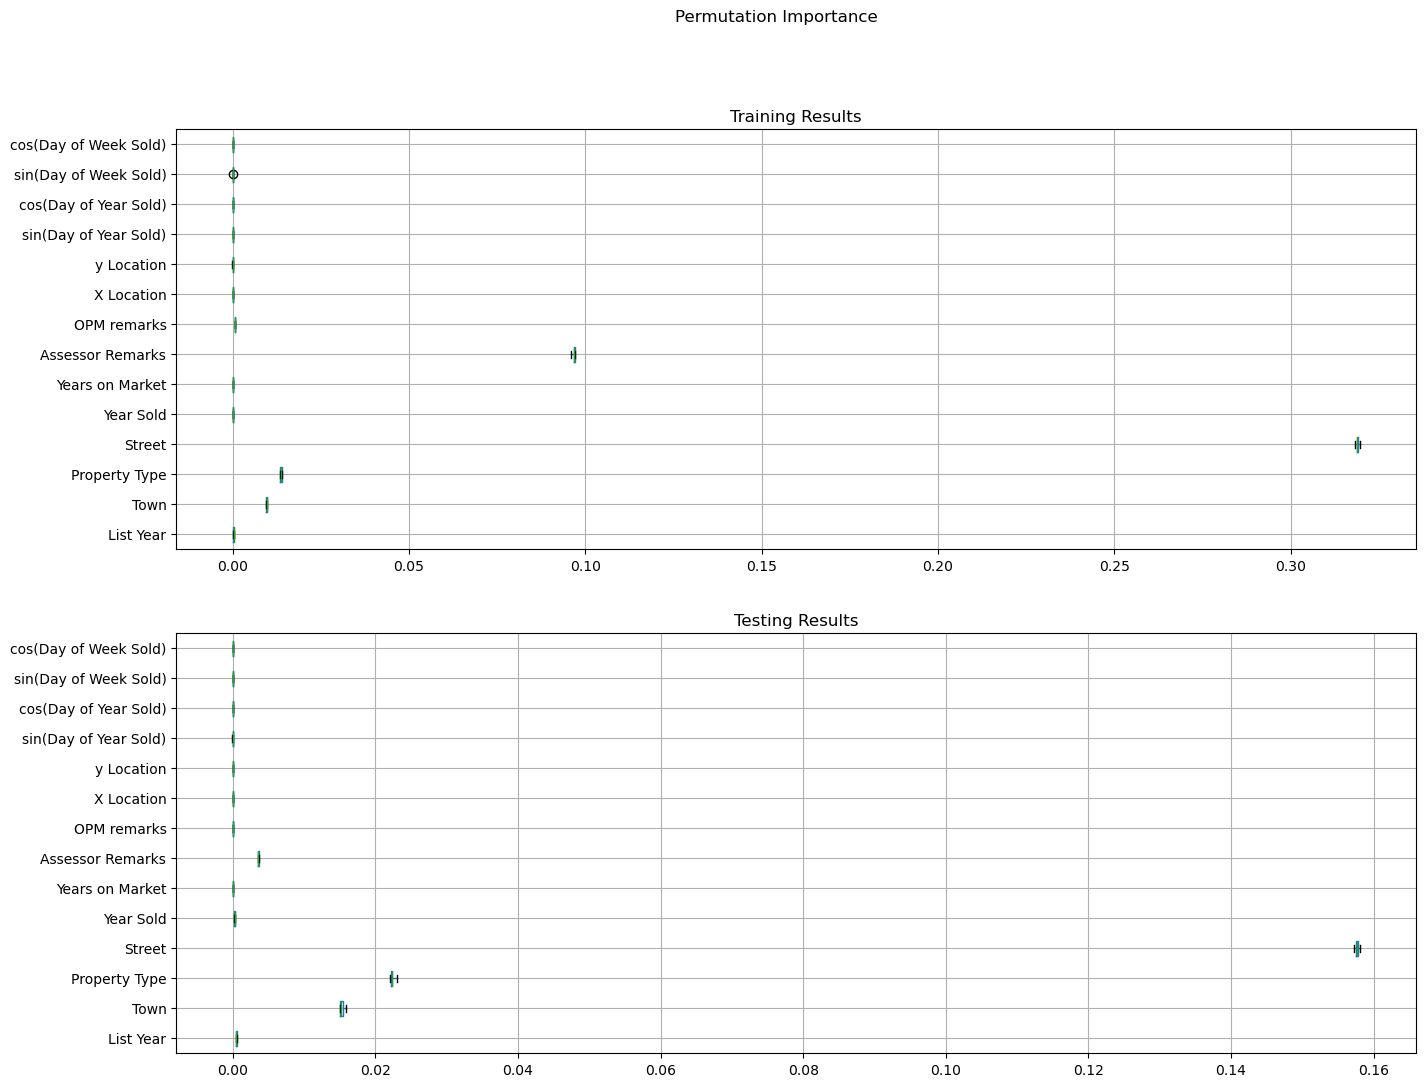

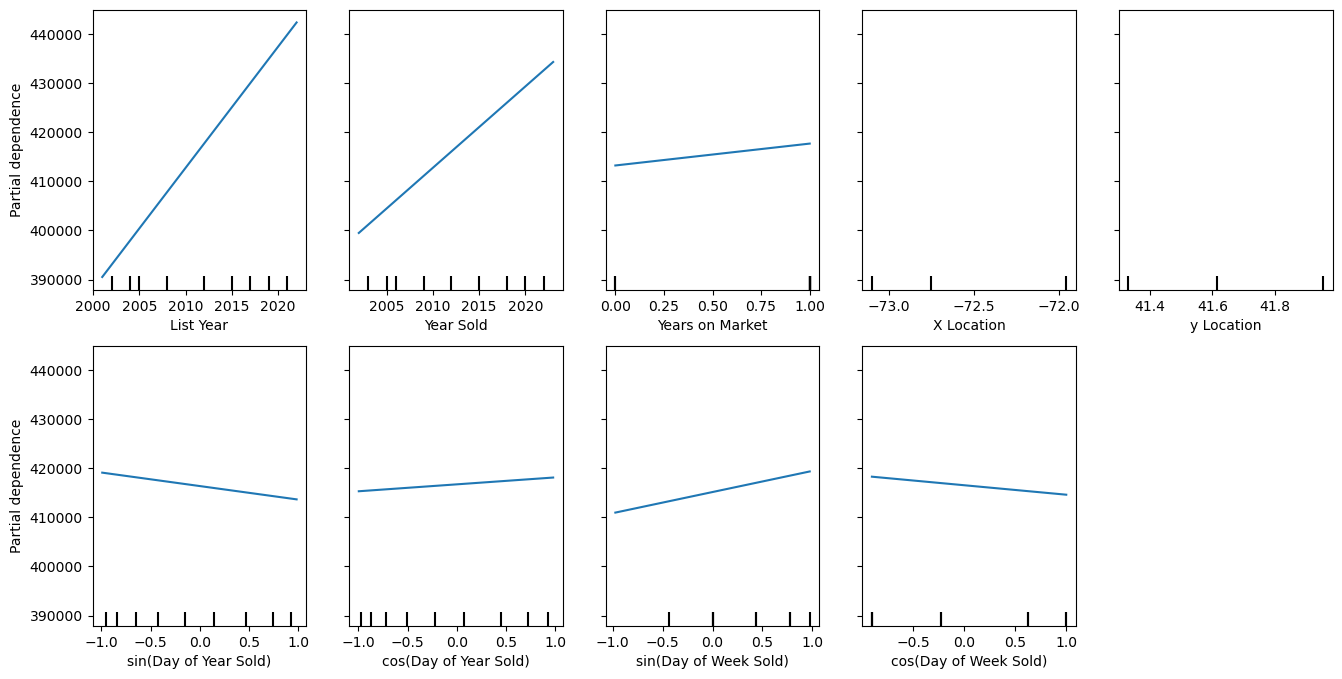

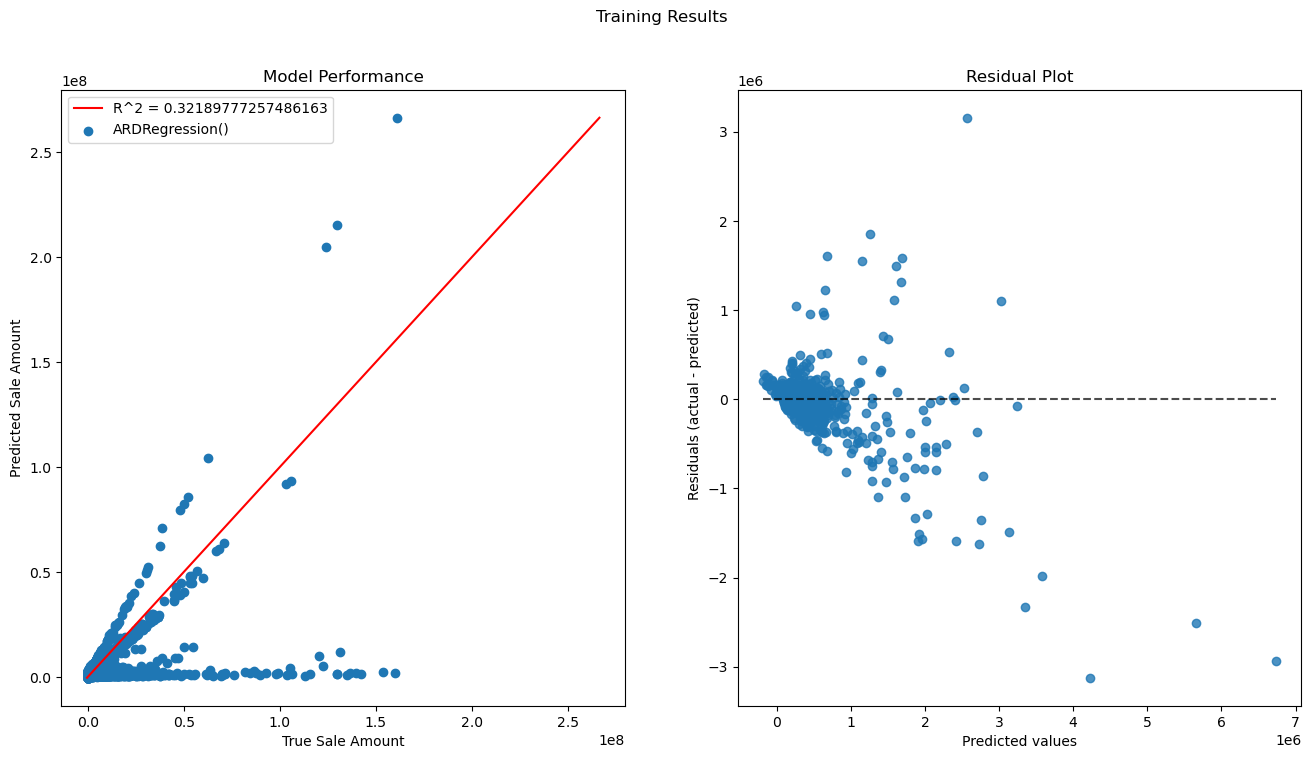

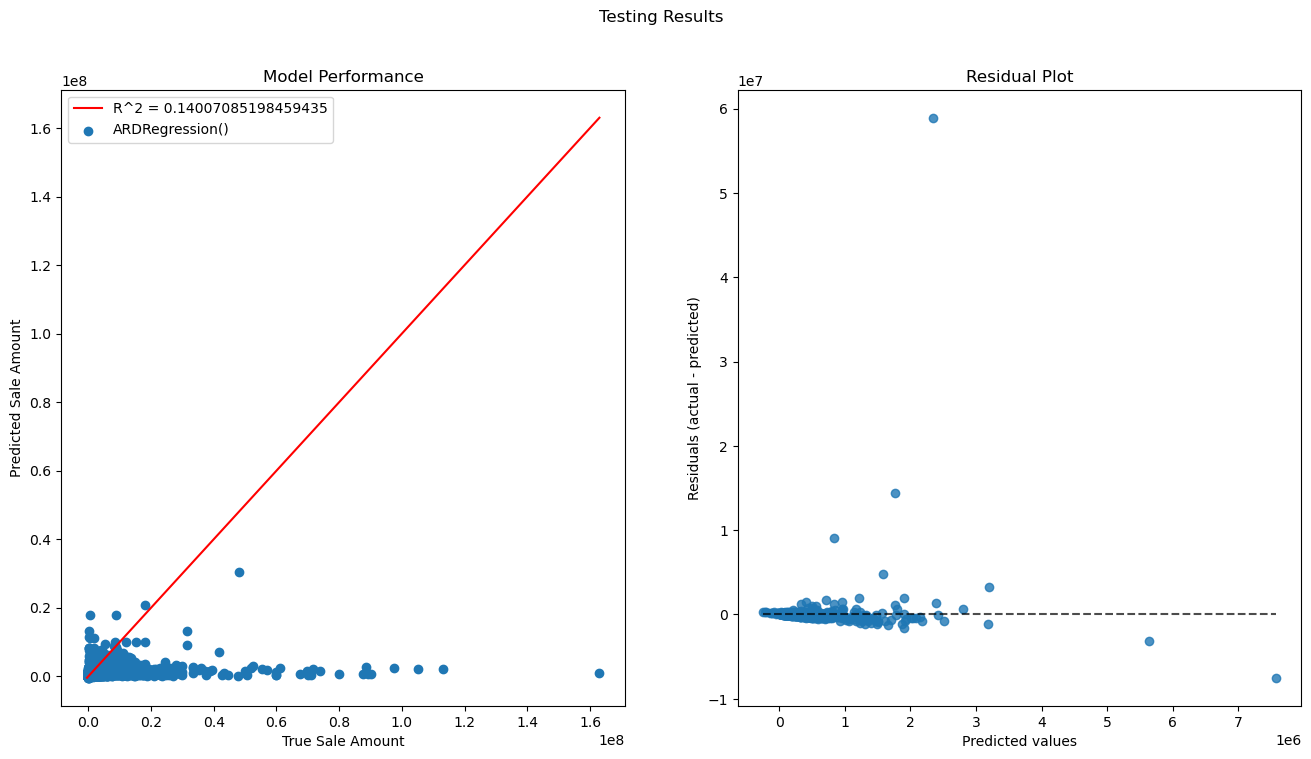

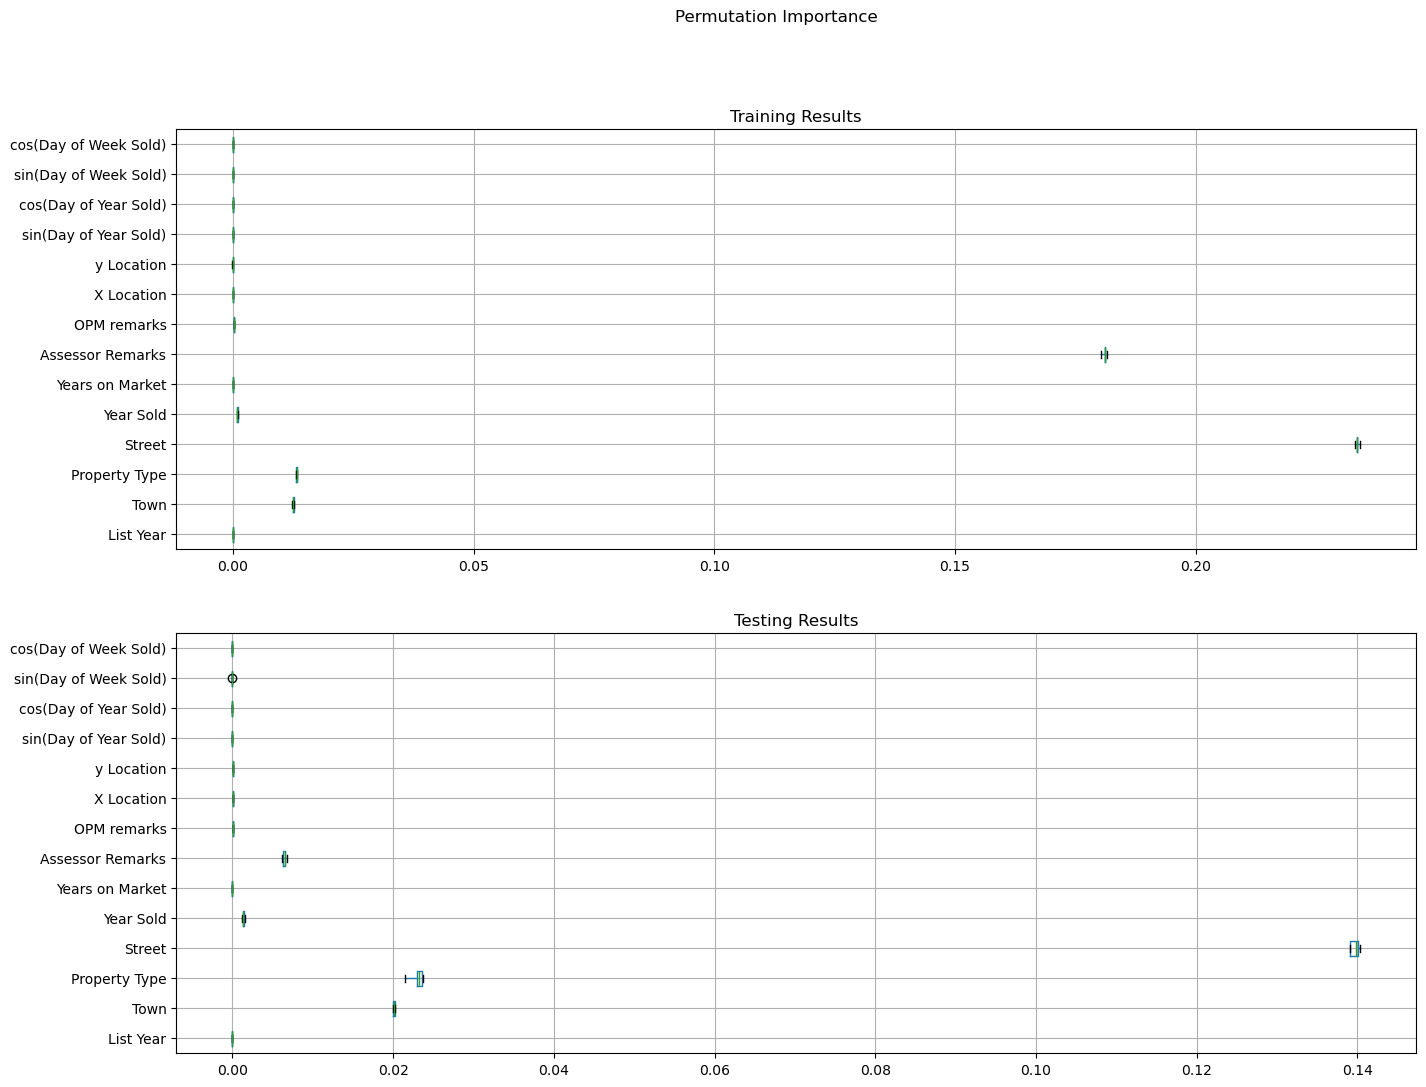

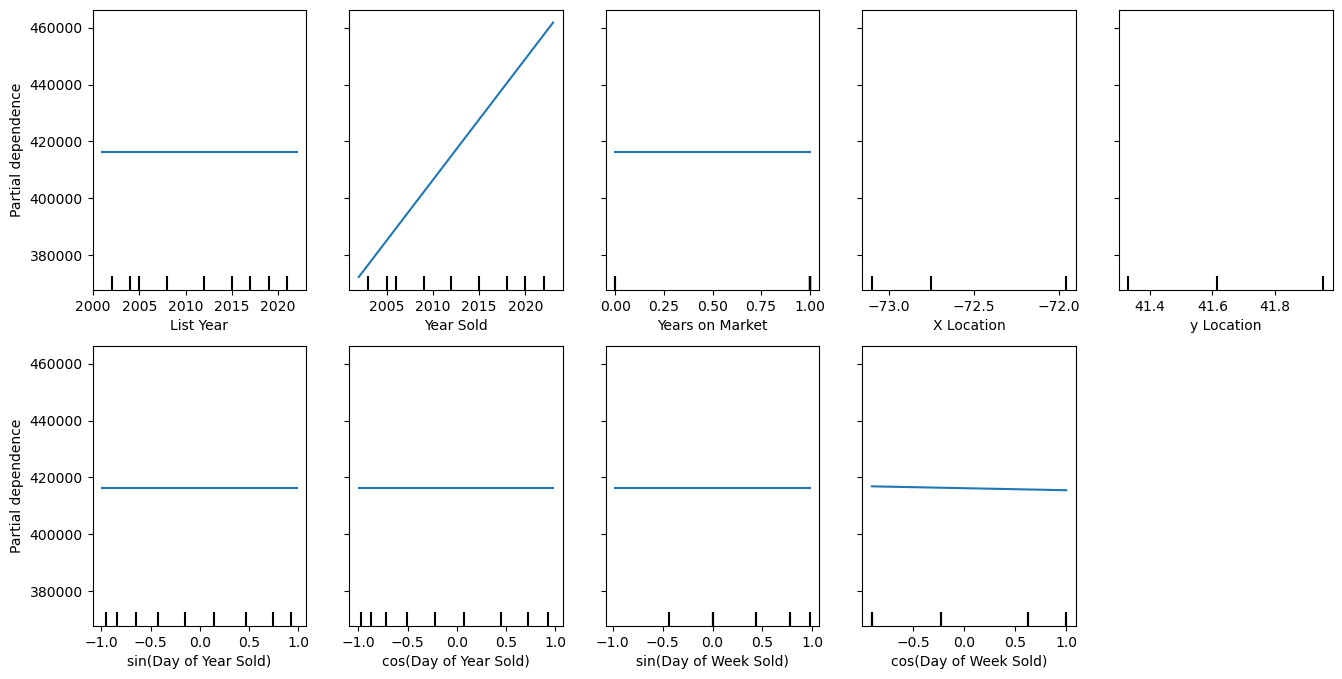

In [41]:

X_features = [
    'List Year',
    'Town',
    'Property Type',
    'Street',
    'Year Sold',
    'Years on Market',
    'Assessor Remarks',
    'OPM remarks',    
    'X Location',
    'y Location',
    'sin(Day of Year Sold)',
    'cos(Day of Year Sold)',
    'sin(Day of Week Sold)',
    'cos(Day of Week Sold)',
]

y_feature = 'Sale Amount'

estimators = make_estimators(['linear'])

for estimator in estimators:
    predict_and_plot(X_train, X_test, y_train, y_test, X_features, y_feature, estimator)


## Predicting Sales Ratio

This experiment predicts `Sales Ratio` using all selected features.

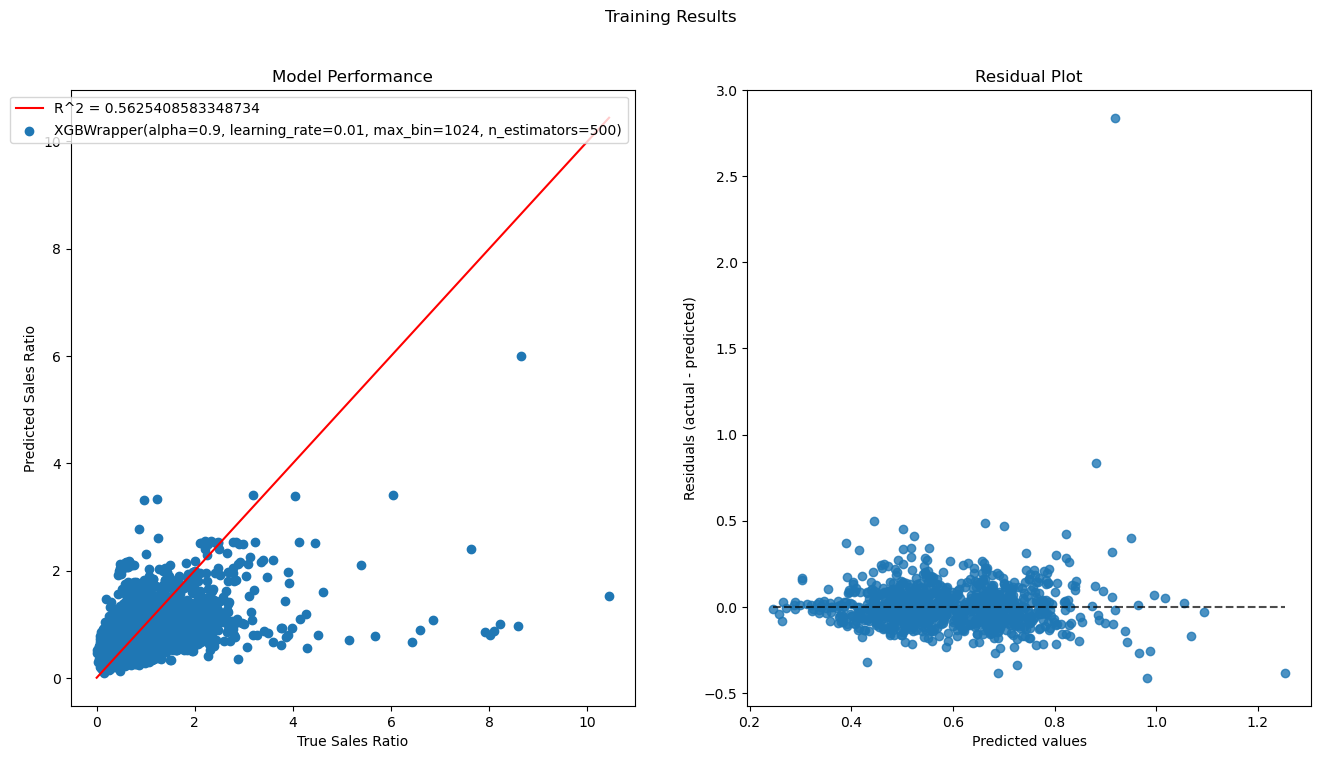

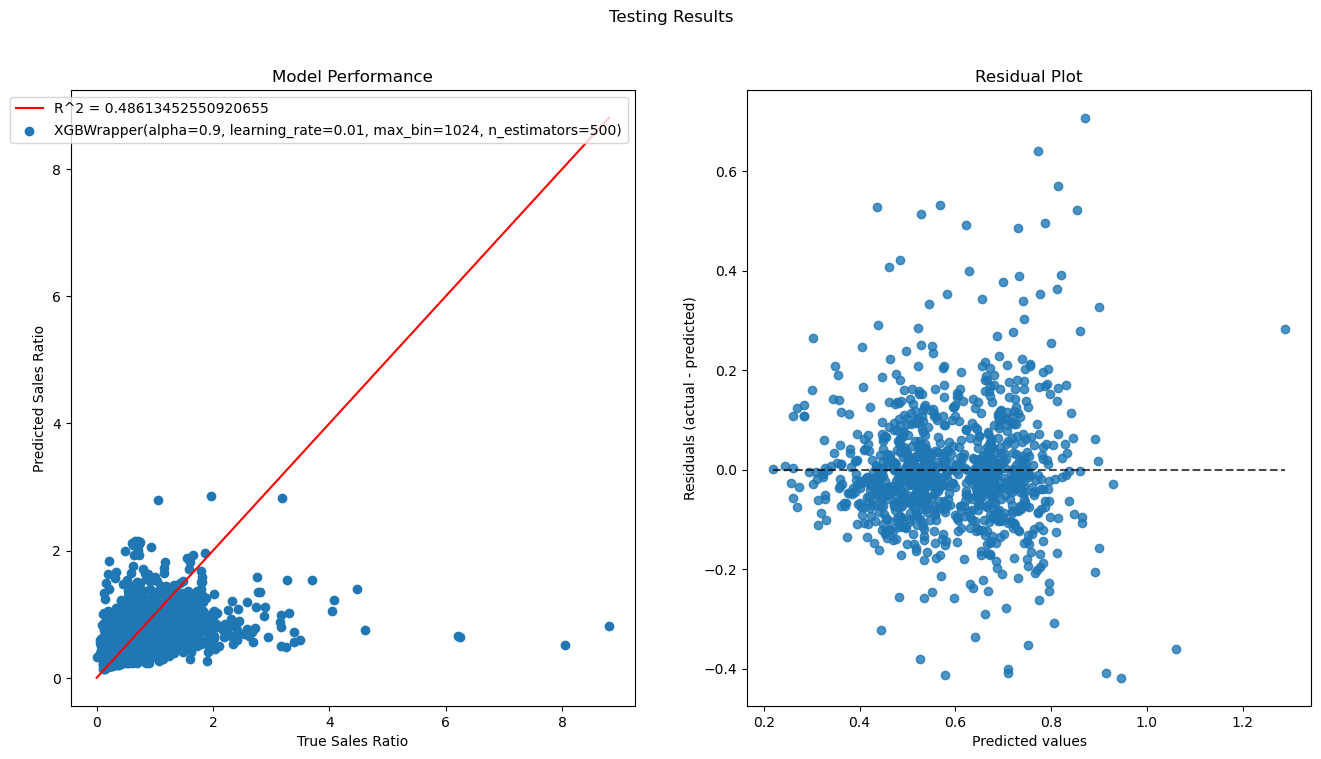

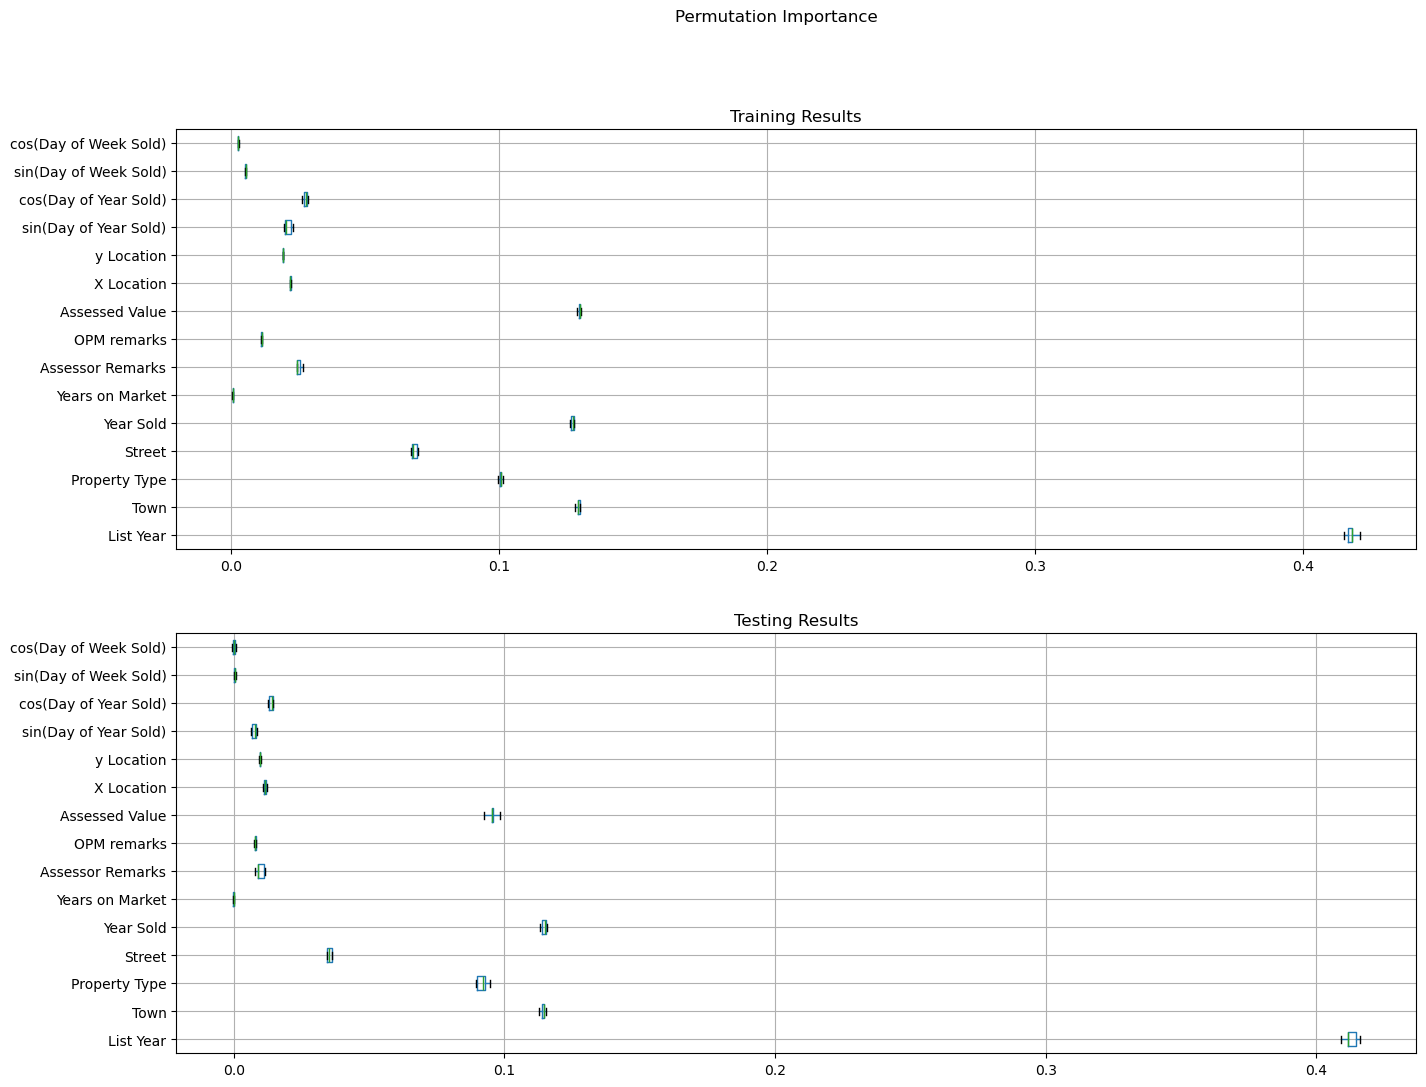

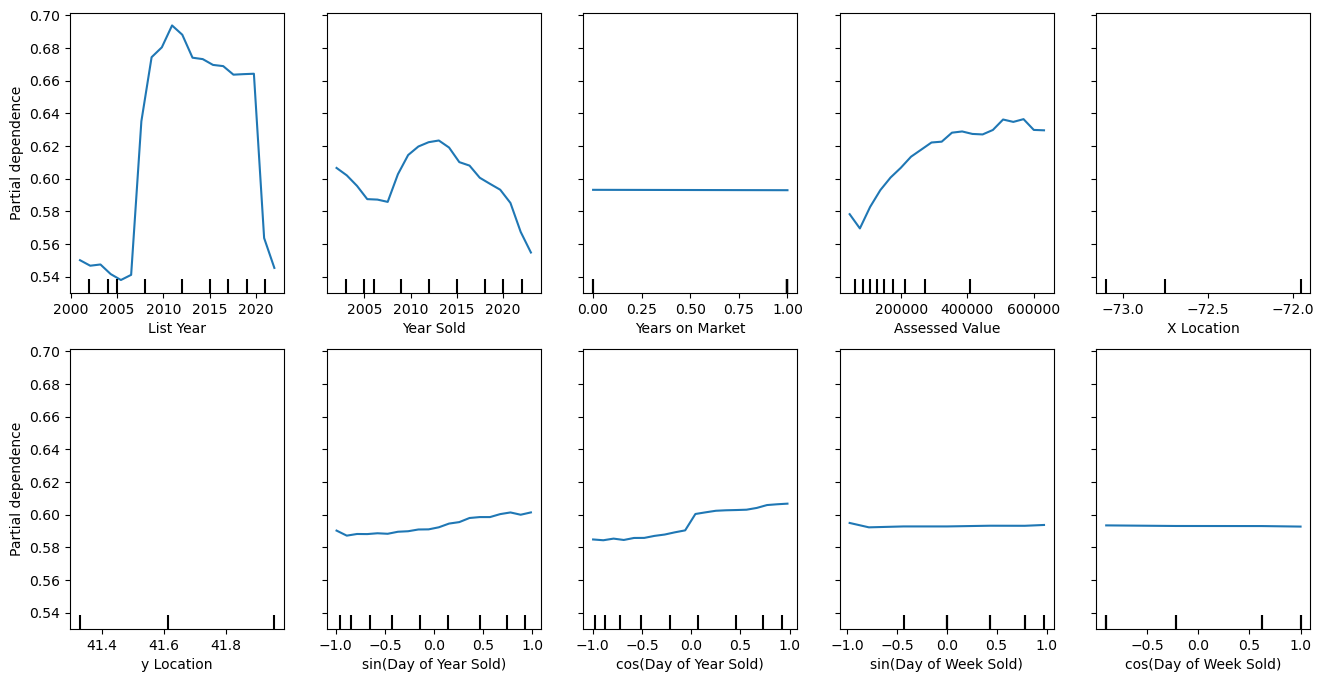

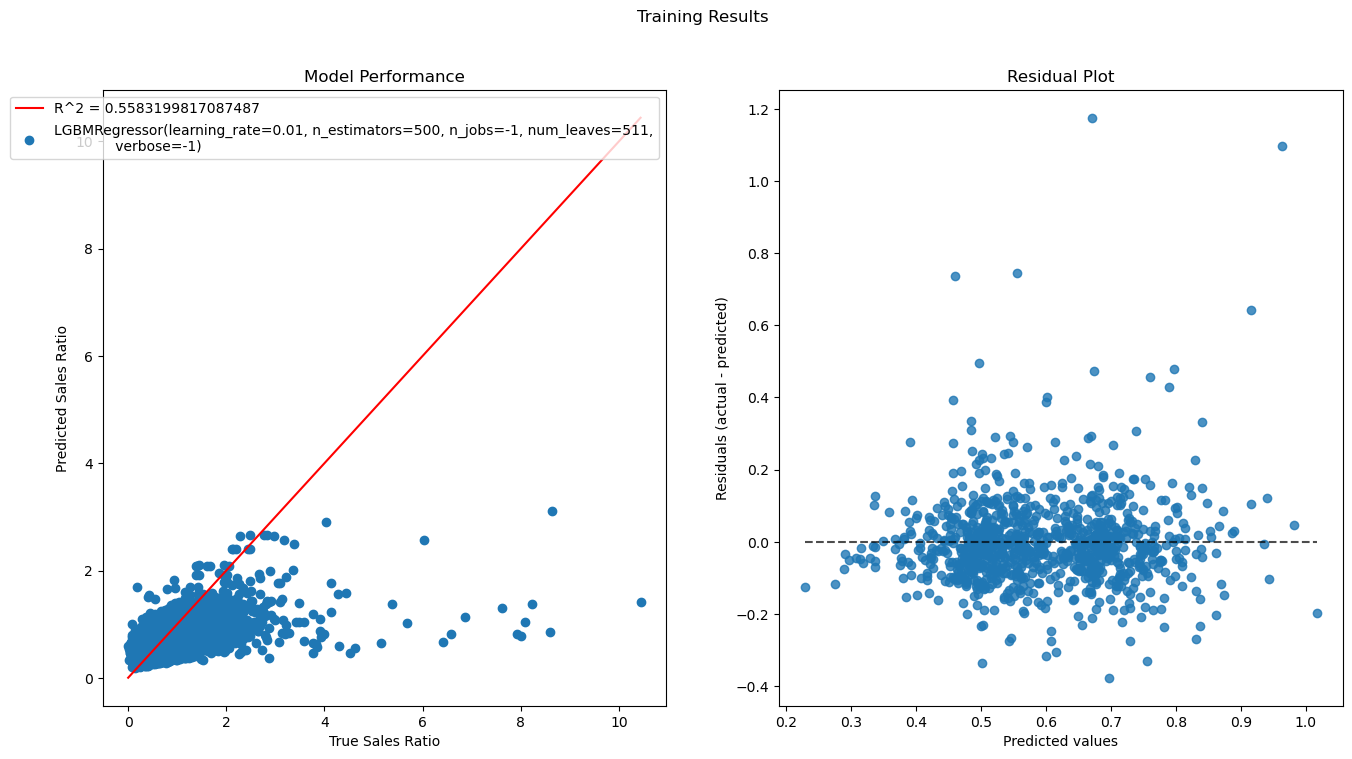

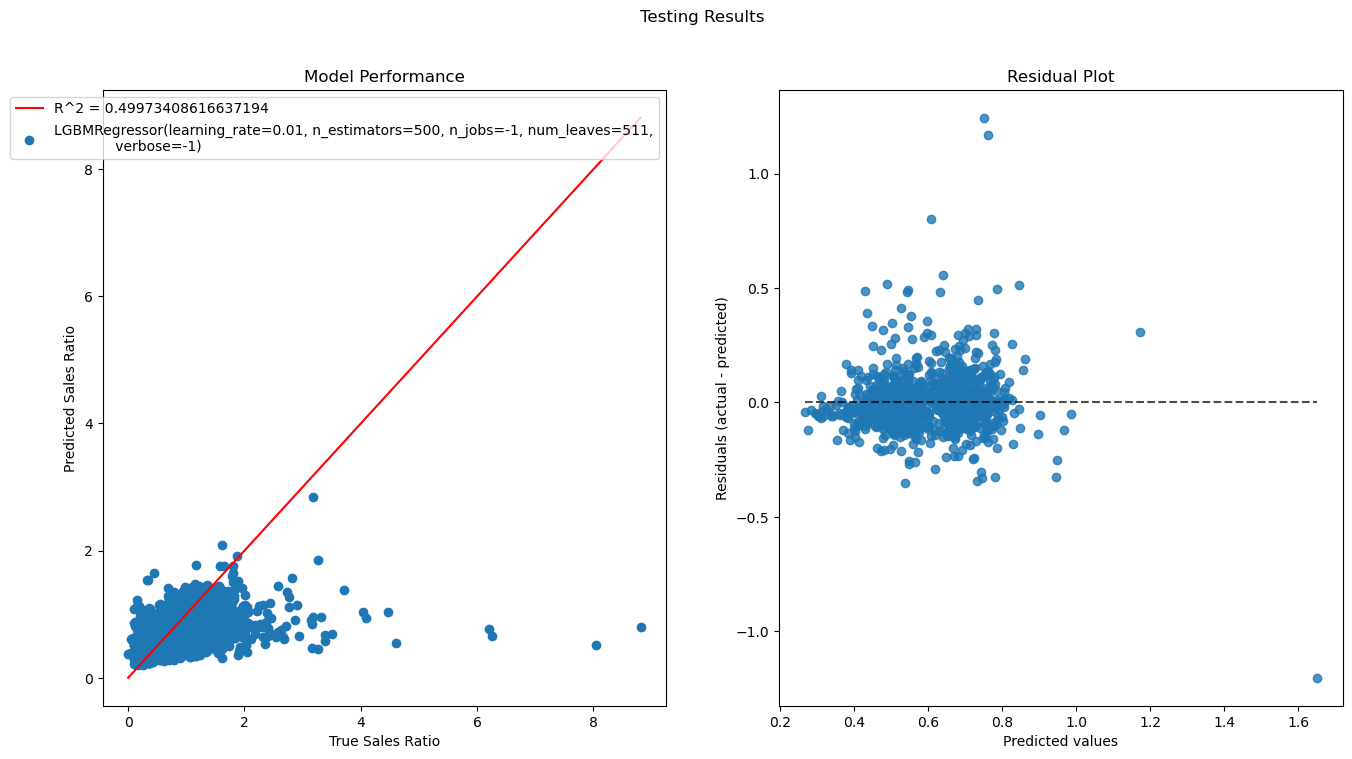

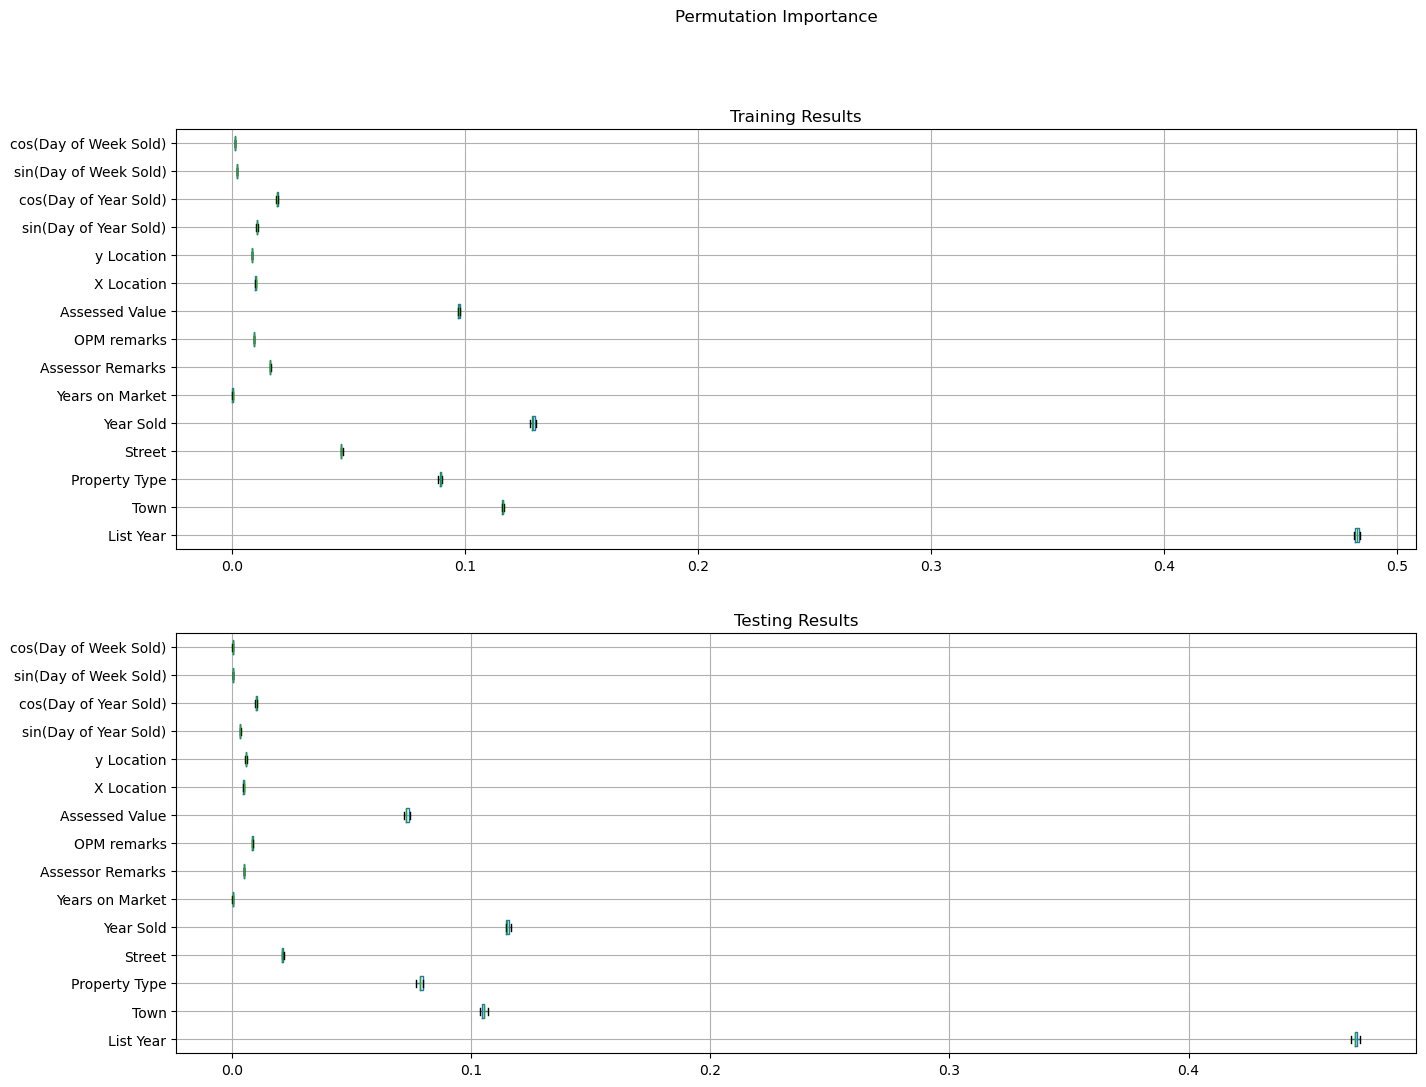

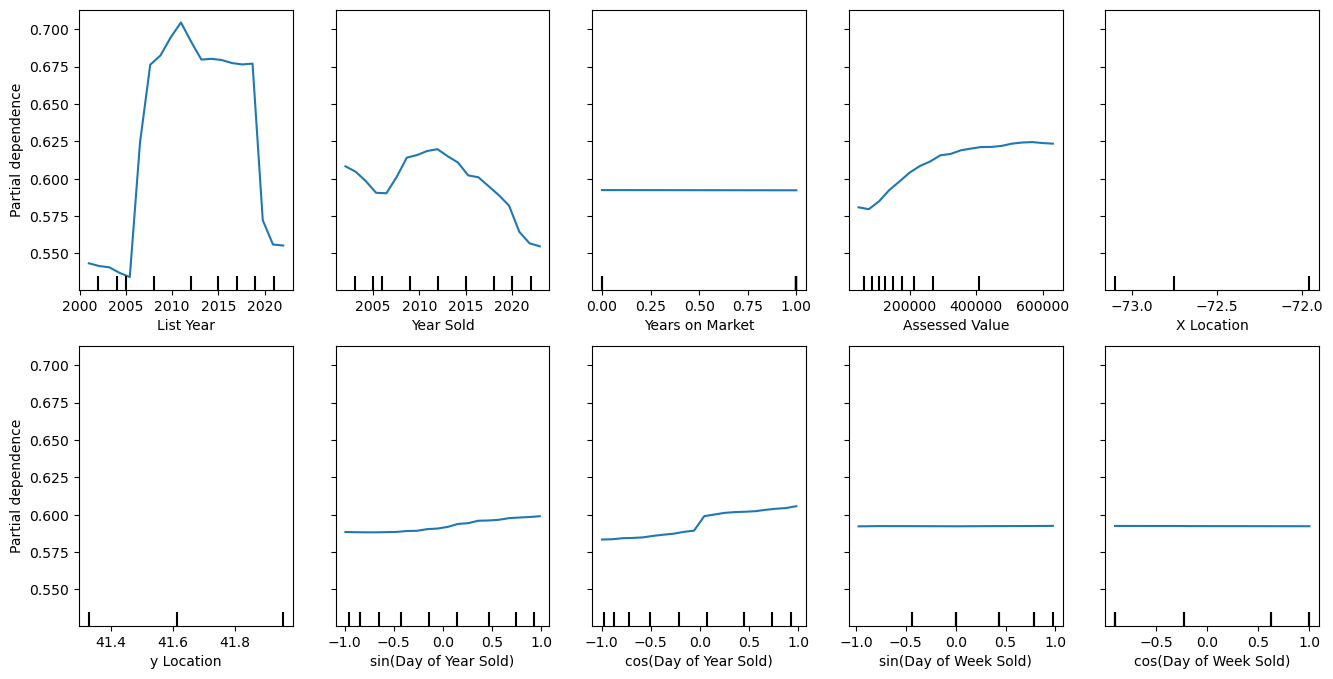

In [42]:

X_features = [
    'List Year',
    'Town',
    'Property Type',
    'Street',
    'Year Sold',
    'Years on Market',
    'Assessor Remarks',
    'OPM remarks',
    'Assessed Value',
    'X Location',
    'y Location',
    'sin(Day of Year Sold)',
    'cos(Day of Year Sold)',
    'sin(Day of Week Sold)',
    'cos(Day of Week Sold)',
]

y_feature = 'Sales Ratio'

estimators = make_estimators('tree')

for estimator in estimators:
    predict_and_plot(X_train, X_test, y_train, y_test, X_features, y_feature, estimator)
    

## Sales Ratios in properties listed since 2023

This experiemnt analyze properties listed since 2023 to assess recent trends in `Sales Ratio` and model performance on new listings.

In [43]:
df2 = df[df['List Year'] >= 2023]

X2 = df2.drop(['Serial Number','Address'],axis=1).copy()

y2 = df2[['Sale Amount','Sales Ratio']]
X2.head()

List Year      Town  Assessed Value  Sale Amount  Sales Ratio  \
1097629     2023.0    Bethel        103950.0     100000.0       1.0395   
1097630     2023.0    Bethel        104580.0     257000.0       0.4069   
1097631     2023.0  Branford        110700.0     290000.0       0.3817   
1097633     2023.0  Cornwall        414260.0     632769.0       0.6546   
1097634     2023.0     Derby        100100.0     304000.0       0.3292   

        Property Type Assessor Remarks OPM remarks                     Street  \
1097629   Vacant Land   M/B/L 87 70 10     Missing       SHELLEY ROAD, Bethel   
1097630   Vacant Land    MBL 64/57/54B     Missing   DODGINGTOWN ROAD, Bethel   
1097631         Condo          Missing     Missing  JEFFERSON WOODS, Branford   
1097633   Vacant Land          Missing     Missing      BRADFORD RD, Cornwall   
1097634         Condo          Missing     Missing          ORANGEWOOD, Derby   

         X Location  y Location  sin(Day of Week Sold)  cos(Day of Week Sold)  \
1097629         NaN         NaN               0.974928              -0.222521   
1097630         NaN         NaN               0.000000               1.000000   
1097631         NaN         NaN               0.433884              -0.900969   
1097633         NaN         NaN               0.000000               1.000000   
1097634         NaN         NaN               0.433884              -0.900969   

         sin(Day of Year Sold)  cos(Day of Year Sold)  Year Sold  \
1097629               0.608477               0.793572     2024.0   
1097630              -0.128748              -0.991677     2024.0   
1097631              -0.171293               0.985220     2023.0   
1097633               0.478734               0.877960     2024.0   
1097634               0.409356              -0.912375     2024.0   

         Years on Market  
1097629              1.0  
1097630              1.0  
1097631              0.0  
1097633              1.0  
1097634              1.0

In [44]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2)

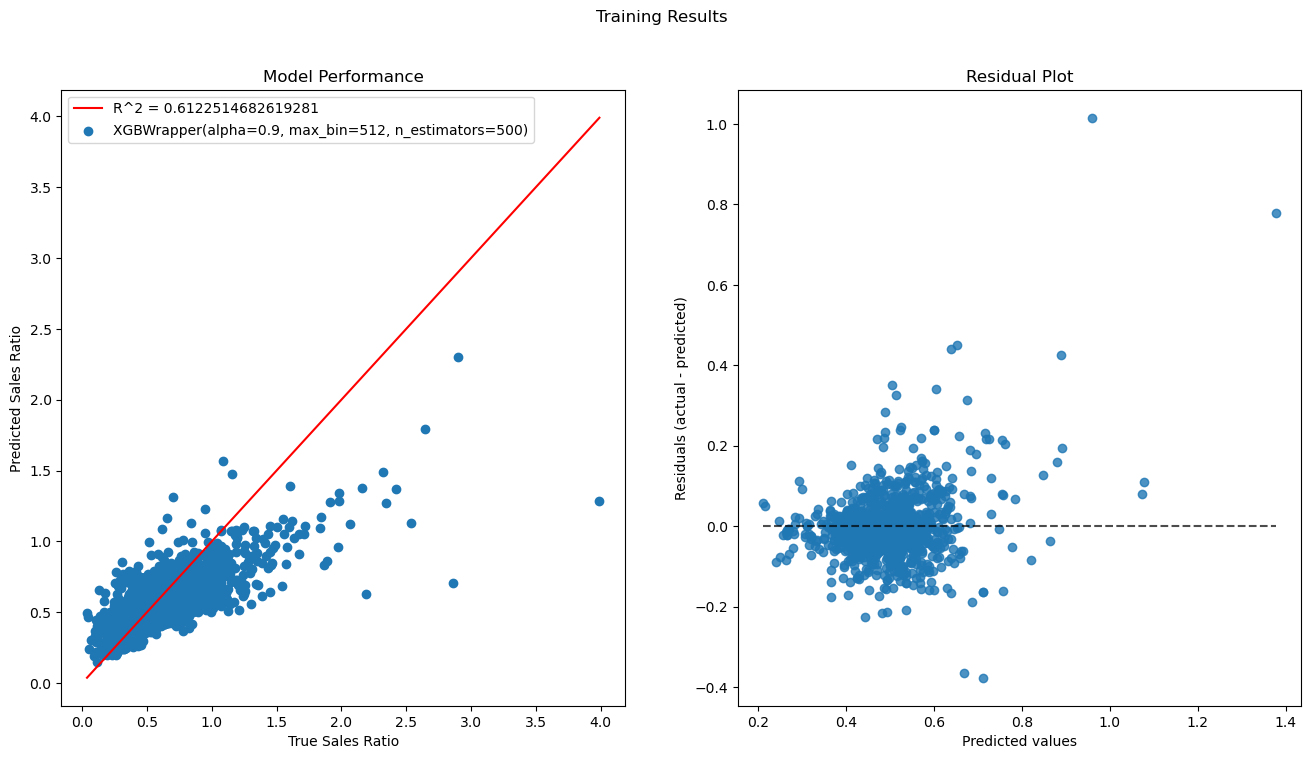

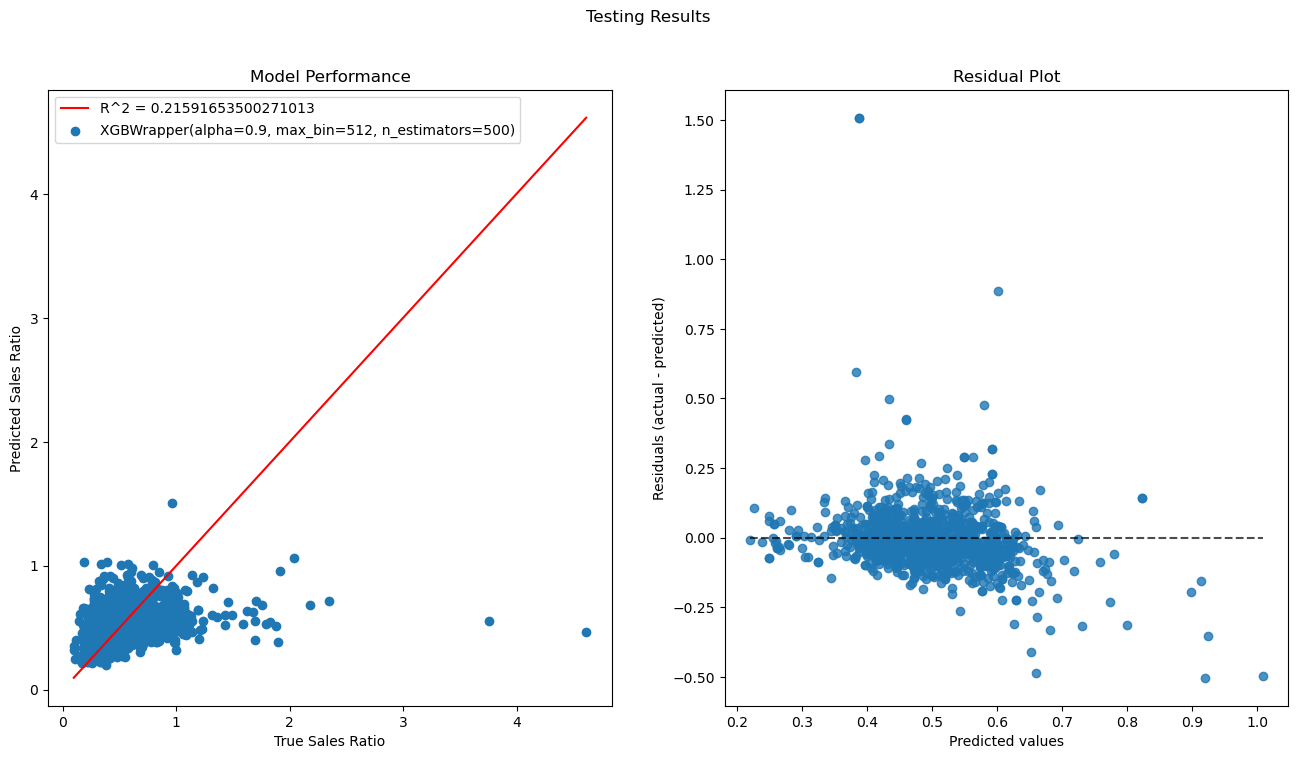

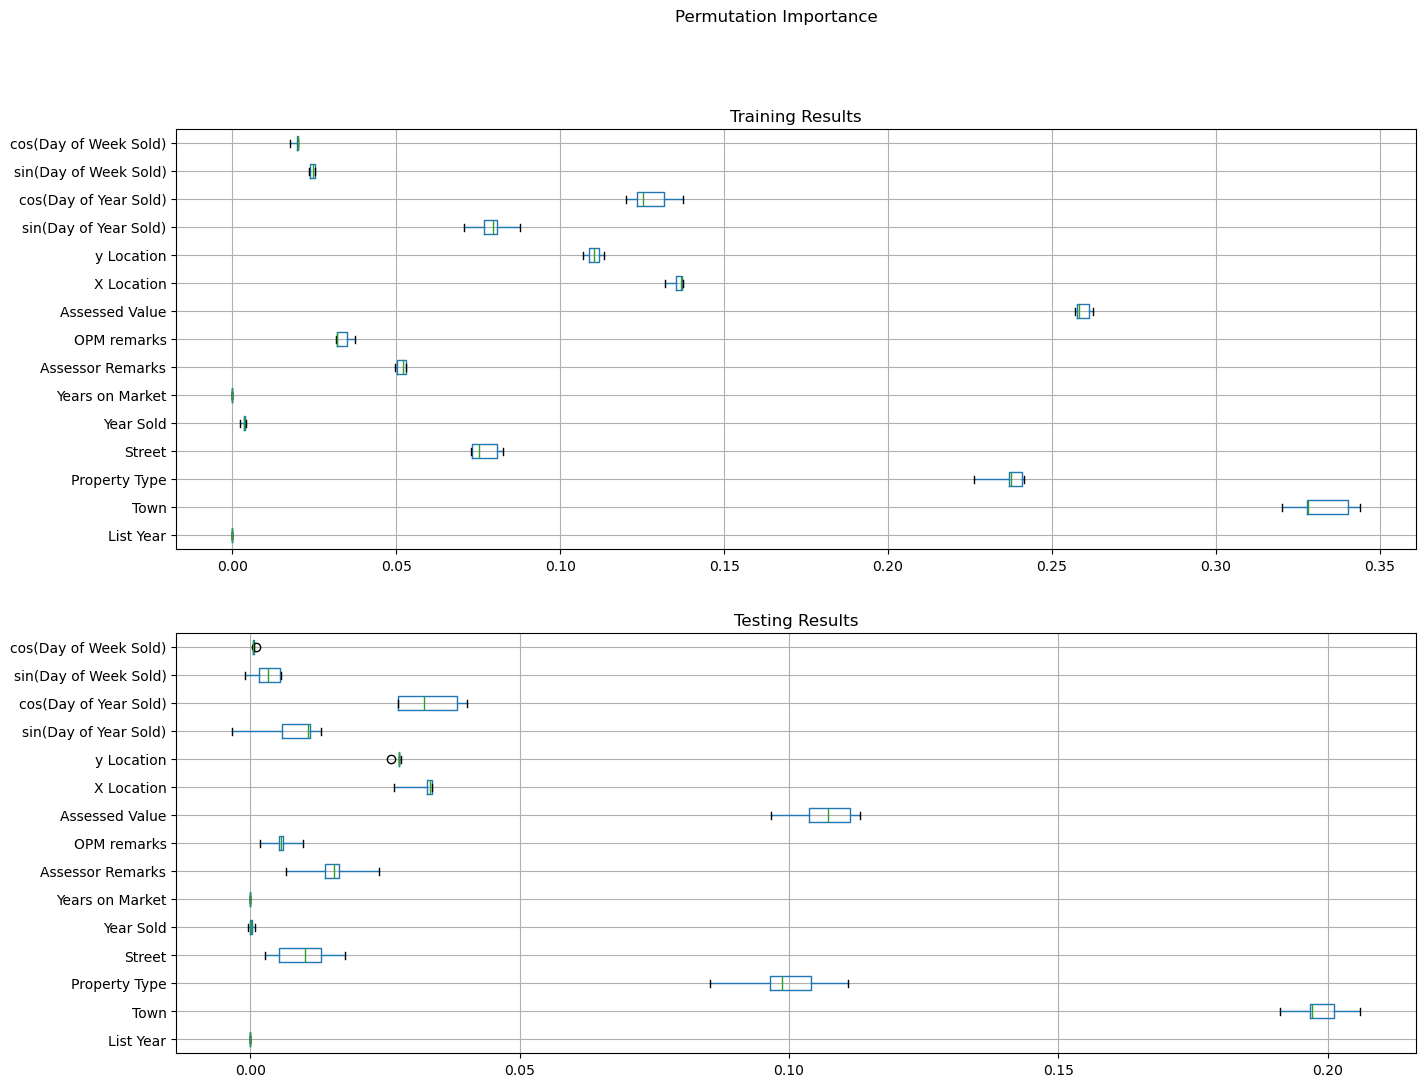

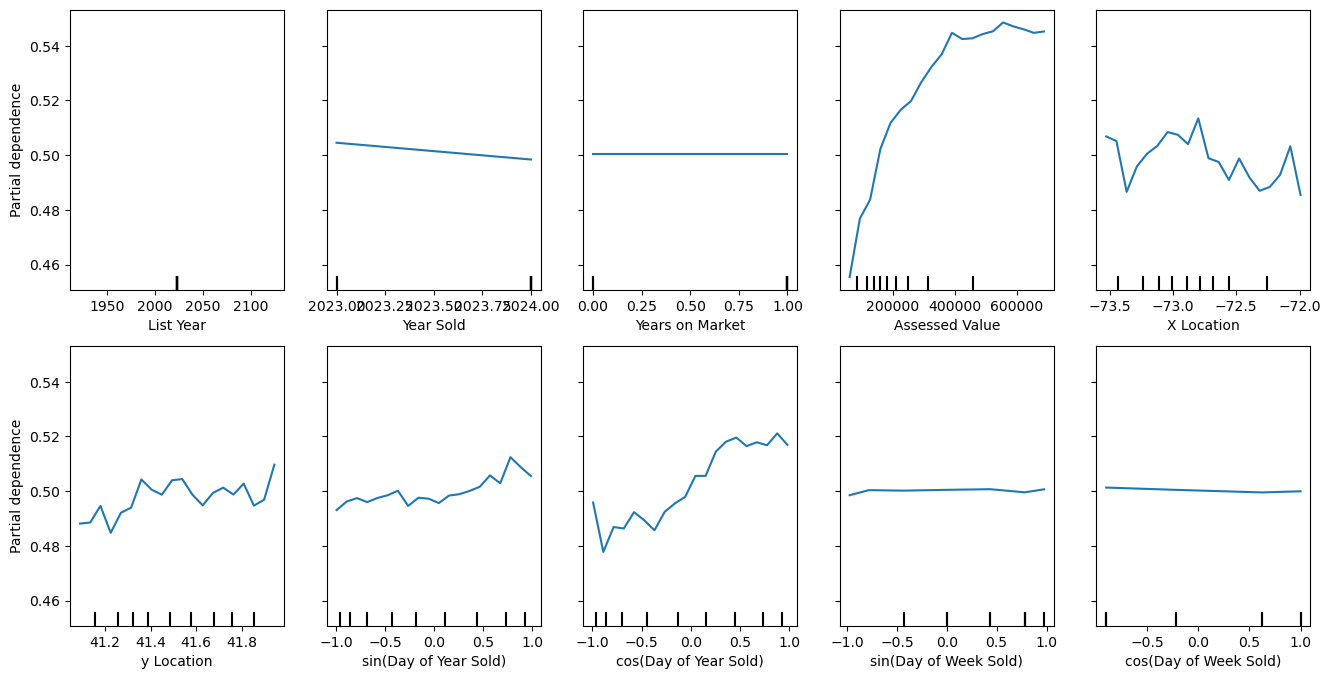

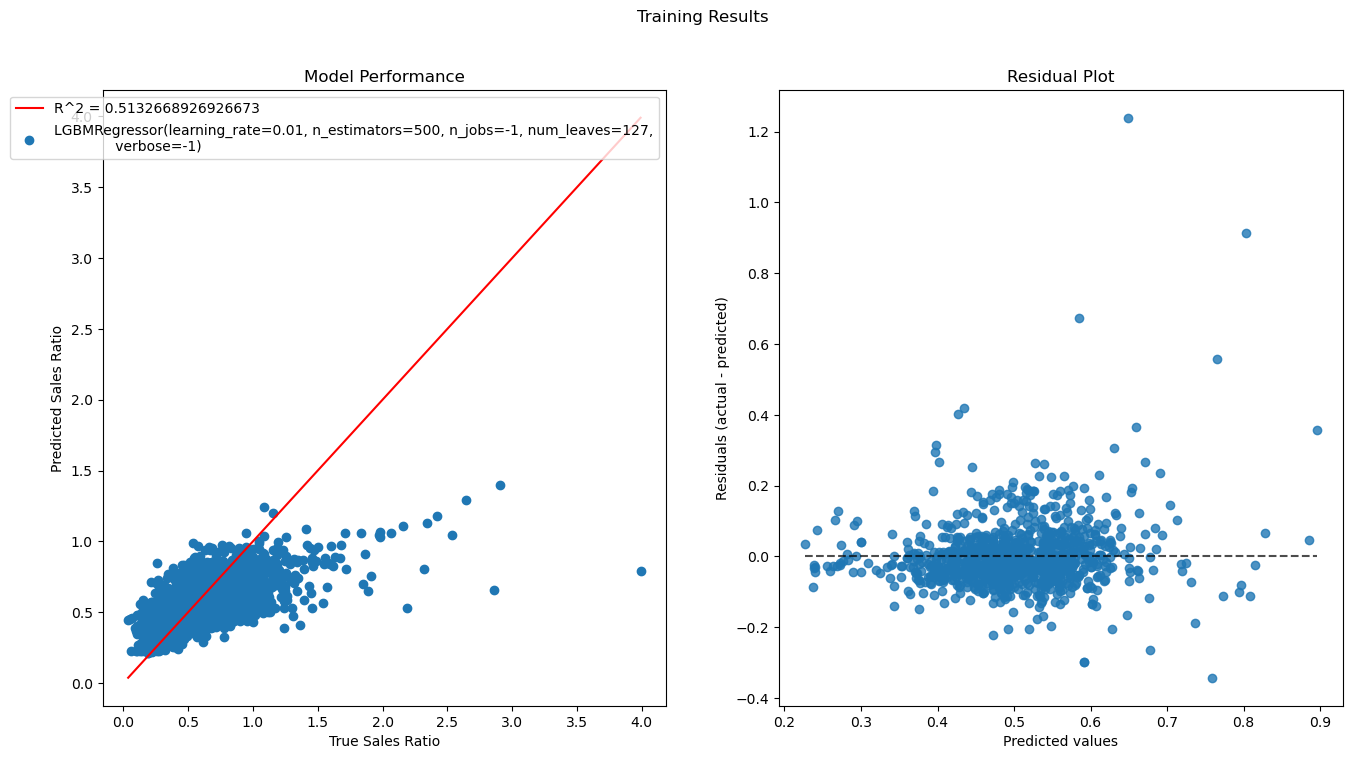

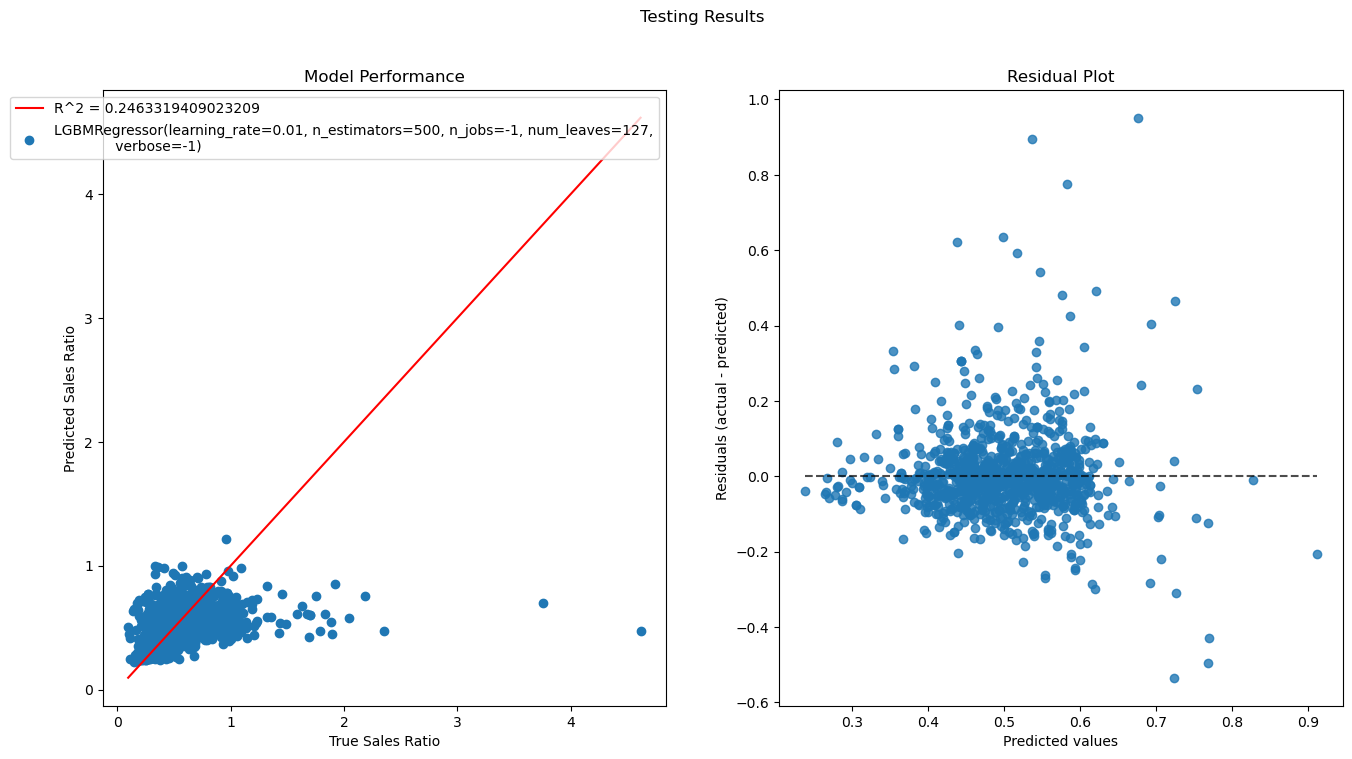

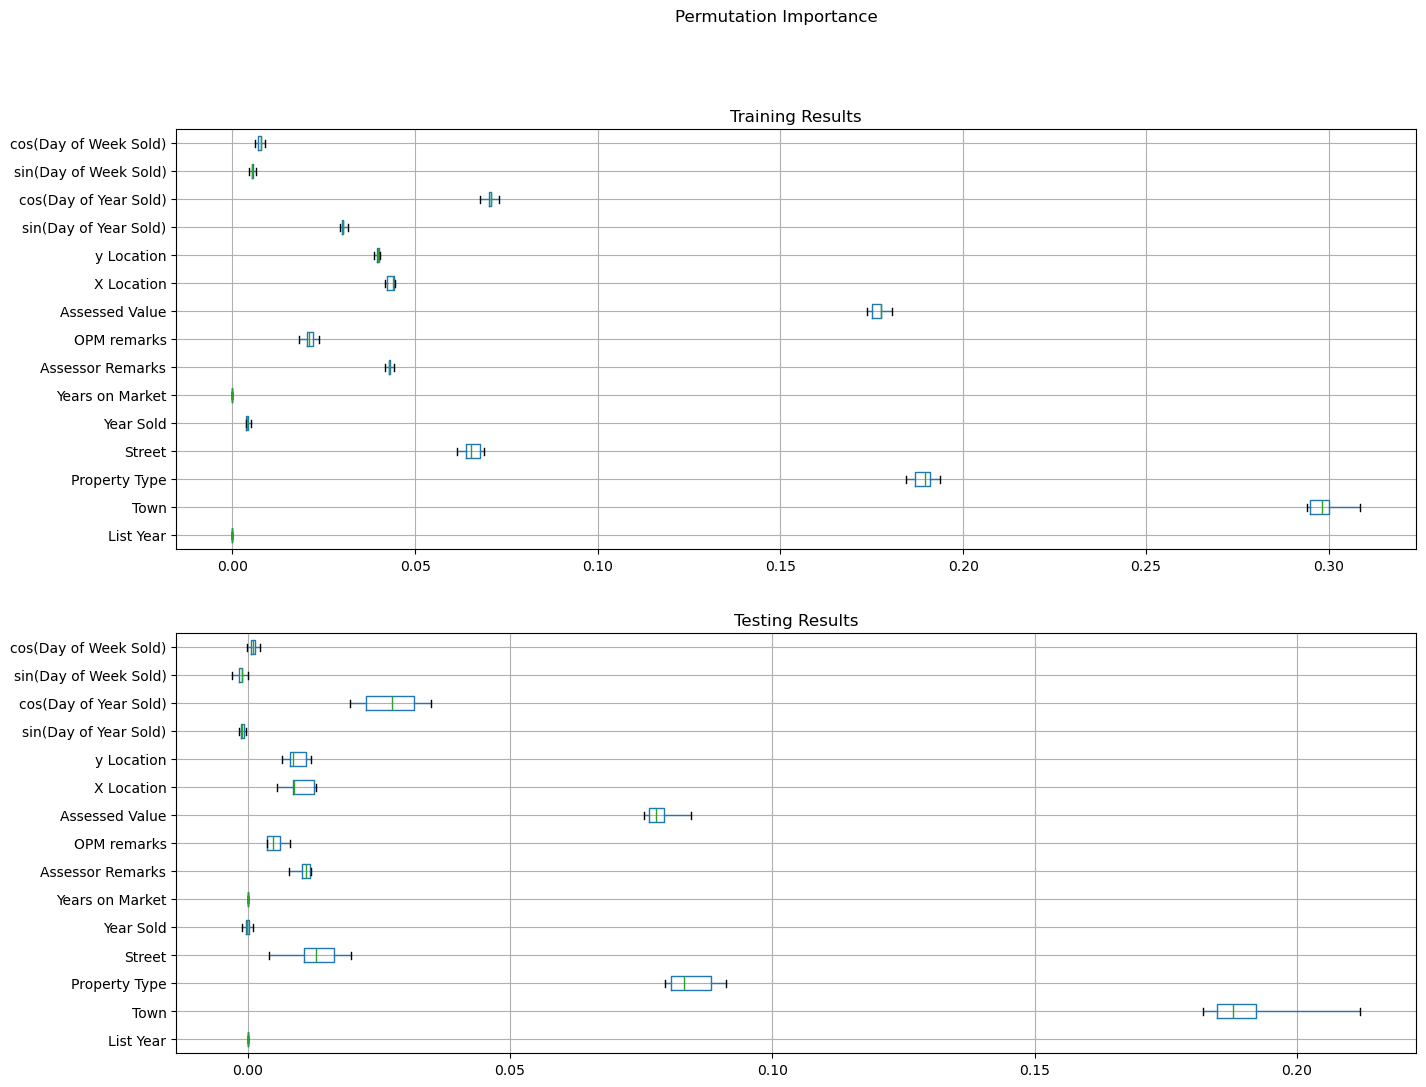

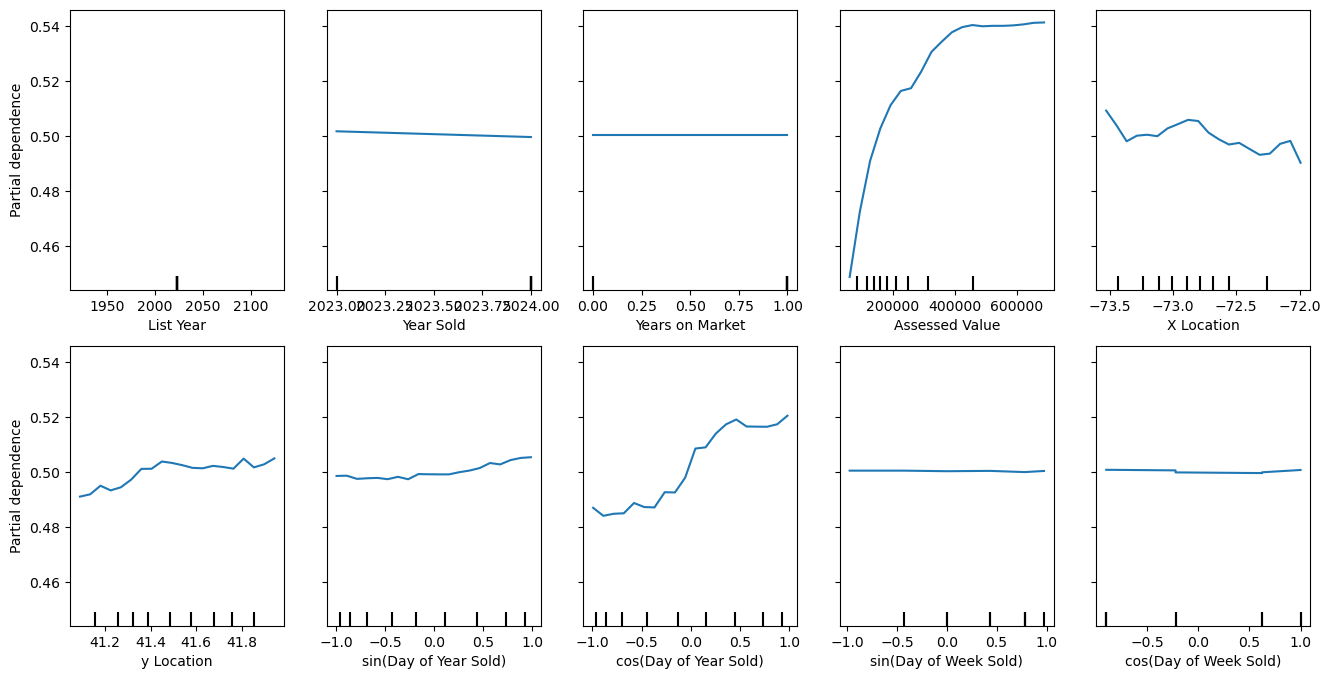

In [45]:
X_features = [
    'List Year',
    'Town',
    'Property Type',
    'Street',
    'Year Sold',
    'Years on Market',
    'Assessor Remarks',
    'OPM remarks',
    'Assessed Value',
    'X Location',
    'y Location',
    'sin(Day of Year Sold)',
    'cos(Day of Year Sold)',
    'sin(Day of Week Sold)',
    'cos(Day of Week Sold)',
]

y_feature = 'Sales Ratio'

estimators = make_estimators('tree')

for estimator in estimators:
    predict_and_plot(X2_train, X2_test, y2_train, y2_test, X_features, y_feature, estimator)

# Conclusion

Our analysis reveals a difference betweeen predicting `Sale Amount` and `Sales Ratio`.

Ridge regression performed the best for predicting `Sale Amount`, with an $R^2\approx 0.90$. This high performance is largely due to `Assessed Value`, as model performance remains close to $R^2 \approx 0.90$ with `Assessed Value` as the sole feature and model performance drops to $R^2 \approx 0.14$ with all features but `Assessed Value`. This indicates that `Sale Amount` is largely determined by `Assessed Value` in a mostly linear relationship. This means that buyers and sellers can make reliable estimates for listing prices and offers based on the assessed value of the proerty.

LightBGM performed the best for predicting `Sales Ratio`, with performance plateuing around $R^2 \approx 0.50$. This result indicates that `Sales Ratio` is determined by more complex features not found in the dataset. Among the features, 'List Year' contributed the most. The partial dependence plot for `List Year` shows `Sale Ratio` increased greatly for prperties listed around 2008 and decreased around 2020, corresponding to the historic housng market crash in 2008 and the 2020 COVID-19 pandemic respecitvely. This means that while the typical sale amount can be predicted based off assessed value, buyers and sellers should anticipate large fluxuations in sale amount based on outside market conditions.

Limiting data to properties with `List Year` since 2023 further reduces the perfomance of the model to $R^2 \approx 0.24$ , indicating that the recent listings don't contain enough information to make an accurate precition for 'Sales Ratio'.

In conclusion, while `Sale Amount` can be predicted with high certainty using linear models, `Sale Ratio` is more unpredictable. While tree based models can account for some of the variation in the dataset, substantial variance remains undetermined.